# Mapas Auto Organizativos

En este ejemplo se implementa una Red de Kohonen o Mapa Auto Organizativo para agrupar los dígitos manuscritos del conjunto de datos Mixed National Institute of Standards and Technology (MNIST). Esta muestra de entrenamiento fue construida por Yann LeCun y otros para servir como benchmark para los algoritmos de aprendizaje automático.

In [1]:
import os
import struct
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib.lines import Line2D

# Obtener los datos de MNIST

In [2]:
def load_mnist(path, kind='train'):
    """Leer los datos de MNIST de la ruta 'path'"""
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
    return images, labels
    

In [3]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


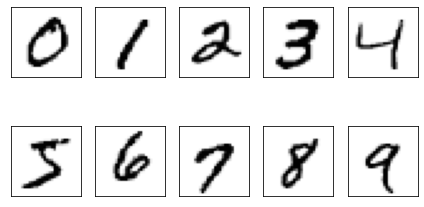

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

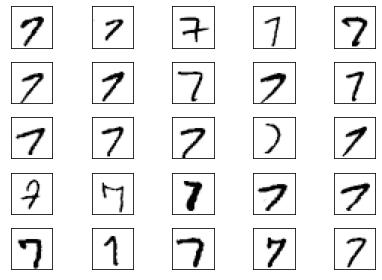

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
np.savez_compressed('mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [7]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [8]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

# Construcción de la red SOM

In [9]:
Raw_Data_Shape = np.array([60000, 784])
SOM_Network_Shape = np.array([50, 50])

## Normalización de los datos de entrenamiento

In [10]:
X_train_norm = X_train/np.linalg.norm(X_train, axis=1).reshape(Raw_Data_Shape[0], 1)



## Inicialización de los pesos y normalización

In [11]:
W_Initial_Guess = np.random.uniform(0, 1, (SOM_Network_Shape[0]*SOM_Network_Shape[1], Raw_Data_Shape[1]))

In [12]:
W_Initial_Guess_Norm = W_Initial_Guess/np.linalg.norm(W_Initial_Guess, axis=1).reshape(SOM_Network_Shape[0]*SOM_Network_Shape[1], 1)

In [13]:
Index = np.mgrid[0:SOM_Network_Shape[0],0:SOM_Network_Shape[1]].reshape(2, SOM_Network_Shape[0]*SOM_Network_Shape[1]).T

## Parámetros 

In [14]:
Epoch = 0 
Max_Epoch = 20000
eta_0 = 0.1
eta_time_const = 1000
sigma_0 = np.max(SOM_Network_Shape) * 0.5
sigma_time_const = 1000/np.log10(sigma_0)

Saturation = np.array([[221, 65, 50], [107, 91, 149], [254, 132, 14], [103, 46, 159], [198, 33, 104], [255, 0, 0], 
                 [0, 110, 109], [0, 83, 156], [117, 81, 57], [191, 214, 65]])
Saturation_Norm = Saturation/np.linalg.norm(Saturation, axis=1).reshape(10, 1)

## Funciones

In [15]:
def winning_neuron(x, W):
    # Also called as Best Matching Neuron/Best Matching Unit (BMU)
    return np.argmin(np.linalg.norm(x - W, axis=1))

def update_weights(lr, var, x, W, Grid):
    i = winning_neuron(x, W)
    d = np.square(np.linalg.norm(Grid - Grid[i], axis=1))
    # Topological Neighbourhood Function
    h = np.exp(-d/(2 * var * var))
    W = W + lr * h[:, np.newaxis] * (x - W)
    return W

def decay_learning_rate(eta_initial, epoch, time_const):
    return eta_initial * np.exp(-epoch/time_const)

def decay_variance(sigma_initial, epoch, time_const):
    return sigma_initial * np.exp(-epoch/time_const)

# Entrenamiento

In [16]:
# Main Loop
W_new = deepcopy(W_Initial_Guess_Norm)
eta = deepcopy(eta_0)
sigma = deepcopy(sigma_0)
while Epoch <= Max_Epoch:
    # Update Weights
    i = np.random.randint(0, Raw_Data_Shape[0])
    W_new = update_weights(eta, sigma, X_train_norm[i], W_new, Index)
    # Print
    print('Epoch: ', Epoch, ' Learning Rate: ', eta, ' Varinance: ', sigma, '\n')
    # Next...
    eta = decay_learning_rate(eta_0, Epoch, eta_time_const)
    sigma = decay_variance(sigma_0, Epoch, sigma_time_const)
    Epoch += 1
print('Optimal Weights Reached!!!')

Epoch:  0  Learning Rate:  0.1  Varinance:  25.0 

Epoch:  1  Learning Rate:  0.1  Varinance:  25.0 

Epoch:  2  Learning Rate:  0.09990004998333751  Varinance:  24.965075916357588 

Epoch:  3  Learning Rate:  0.09980019986673332  Varinance:  24.930200620379903 

Epoch:  4  Learning Rate:  0.0997004495503373  Varinance:  24.895374043912373 

Epoch:  5  Learning Rate:  0.09960079893439916  Varinance:  24.86059611889562 

Epoch:  6  Learning Rate:  0.09950124791926823  Varinance:  24.825866777365356 

Epoch:  7  Learning Rate:  0.09940179640539354  Varinance:  24.79118595145223 

Epoch:  8  Learning Rate:  0.09930244429332352  Varinance:  24.756553573381705 

Epoch:  9  Learning Rate:  0.09920319148370607  Varinance:  24.72196957547392 

Epoch:  10  Learning Rate:  0.09910403787728837  Varinance:  24.687433890143556 

Epoch:  11  Learning Rate:  0.09900498337491681  Varinance:  24.65294644989972 

Epoch:  12  Learning Rate:  0.09890602787753688  Varinance:  24.61850718734579 

Epoch:  13

Epoch:  104  Learning Rate:  0.09021269734815165  Varinance:  21.647457346569183 

Epoch:  105  Learning Rate:  0.09012252974212048  Varinance:  21.617216642128497 

Epoch:  106  Learning Rate:  0.09003245225862656  Varinance:  21.58701818284346 

Epoch:  107  Learning Rate:  0.08994246480759241  Varinance:  21.556861909699148 

Epoch:  108  Learning Rate:  0.08985256729903056  Varinance:  21.52674776376305 

Epoch:  109  Learning Rate:  0.08976275964304349  Varinance:  21.49667568618502 

Epoch:  110  Learning Rate:  0.08967304174982355  Varinance:  21.466645618197095 

Epoch:  111  Learning Rate:  0.08958341352965282  Varinance:  21.436657501113416 

Epoch:  112  Learning Rate:  0.08949387489290311  Varinance:  21.40671127633011 

Epoch:  113  Learning Rate:  0.08940442575003572  Varinance:  21.376806885325166 

Epoch:  114  Learning Rate:  0.08931506601160155  Varinance:  21.346944269658337 

Epoch:  115  Learning Rate:  0.08922579558824084  Varinance:  21.317123370970993 

Epoch:  

Epoch:  204  Learning Rate:  0.08162782414256099  Varinance:  18.823272498133893 

Epoch:  205  Learning Rate:  0.08154623711872927  Varinance:  18.79697707640794 

Epoch:  206  Learning Rate:  0.08146473164114146  Varinance:  18.770718388422303 

Epoch:  207  Learning Rate:  0.08138330762829207  Varinance:  18.744496382861282 

Epoch:  208  Learning Rate:  0.08130196499875711  Varinance:  18.718311008480885 

Epoch:  209  Learning Rate:  0.08122070367119391  Varinance:  18.69216221410869 

Epoch:  210  Learning Rate:  0.08113952356434115  Varinance:  18.666049948643764 

Epoch:  211  Learning Rate:  0.08105842459701872  Varinance:  18.639974161056568 

Epoch:  212  Learning Rate:  0.08097740668812764  Varinance:  18.613934800388844 

Epoch:  213  Learning Rate:  0.08089646975664999  Varinance:  18.587931815753514 

Epoch:  214  Learning Rate:  0.08081561372164885  Varinance:  18.5619651563346 

Epoch:  215  Learning Rate:  0.08073483850226815  Varinance:  18.536034771387104 

Epoch:  

Epoch:  311  Learning Rate:  0.07334469562242893  Varinance:  16.208153566236255 

Epoch:  312  Learning Rate:  0.07327138758693325  Varinance:  16.185511369802803 

Epoch:  313  Learning Rate:  0.07319815282283126  Varinance:  16.162900803687833 

Epoch:  314  Learning Rate:  0.0731249912568882  Varinance:  16.14032182370495 

Epoch:  315  Learning Rate:  0.0730519028159425  Varinance:  16.11777438572949 

Epoch:  316  Learning Rate:  0.07297888742690568  Varinance:  16.09525844569842 

Epoch:  317  Learning Rate:  0.07290594501676238  Varinance:  16.072773959610267 

Epoch:  318  Learning Rate:  0.07283307551257016  Varinance:  16.050320883525025 

Epoch:  319  Learning Rate:  0.07276027884145955  Varinance:  16.027899173564073 

Epoch:  320  Learning Rate:  0.07268755493063382  Varinance:  16.005508785910084 

Epoch:  321  Learning Rate:  0.0726149037073691  Varinance:  15.983149676806944 

Epoch:  322  Learning Rate:  0.07254232509901412  Varinance:  15.96082180255966 

Epoch:  323

Epoch:  416  Learning Rate:  0.06603402807049828  Varinance:  13.995428229786445 

Epoch:  417  Learning Rate:  0.0659680270484389  Varinance:  13.975877129542106 

Epoch:  418  Learning Rate:  0.06590209199441208  Varinance:  13.956353341468178 

Epoch:  419  Learning Rate:  0.06583622284248272  Varinance:  13.936856827410557 

Epoch:  420  Learning Rate:  0.0657704195267817  Varinance:  13.917387549268446 

Epoch:  421  Learning Rate:  0.06570468198150568  Varinance:  13.89794546899426 

Epoch:  422  Learning Rate:  0.06563901014091712  Varinance:  13.878530548593588 

Epoch:  423  Learning Rate:  0.06557340393934417  Varinance:  13.859142750125072 

Epoch:  424  Learning Rate:  0.06550786331118062  Varinance:  13.83978203570037 

Epoch:  425  Learning Rate:  0.06544238819088587  Varinance:  13.82044836748407 

Epoch:  426  Learning Rate:  0.06537697851298473  Varinance:  13.801141707693601 

Epoch:  427  Learning Rate:  0.06531163421206757  Varinance:  13.781862018599192 

Epoch:  4

Epoch:  515  Learning Rate:  0.059809839406276134  Varinance:  12.1865716414177 

Epoch:  516  Learning Rate:  0.05975005946182375  Varinance:  12.169547447524936 

Epoch:  517  Learning Rate:  0.059690339267435805  Varinance:  12.152547035807029 

Epoch:  518  Learning Rate:  0.0596306787633921  Varinance:  12.135570373041151 

Epoch:  519  Learning Rate:  0.059571077890032124  Varinance:  12.118617426050893 

Epoch:  520  Learning Rate:  0.059511536587755015  Varinance:  12.10168816170618 

Epoch:  521  Learning Rate:  0.05945205479701944  Varinance:  12.084782546923227 

Epoch:  522  Learning Rate:  0.059392632458343614  Varinance:  12.067900548664461 

Epoch:  523  Learning Rate:  0.0593332695123052  Varinance:  12.051042133938465 

Epoch:  524  Learning Rate:  0.05927396589954125  Varinance:  12.034207269799909 

Epoch:  525  Learning Rate:  0.05921472156074813  Varinance:  12.017395923349483 

Epoch:  526  Learning Rate:  0.05915553643668151  Varinance:  12.000608061733843 

Epoc

Epoch:  622  Learning Rate:  0.053740676203966366  Varinance:  10.493490153193068 

Epoch:  623  Learning Rate:  0.053686962389145956  Varinance:  10.47883113208063 

Epoch:  624  Learning Rate:  0.05363330226129242  Varinance:  10.46419258908337 

Epoch:  625  Learning Rate:  0.05357969576674561  Varinance:  10.44957449559411 

Epoch:  626  Learning Rate:  0.05352614285189903  Varinance:  10.434976823045641 

Epoch:  627  Learning Rate:  0.05347264346319976  Varinance:  10.420399542910651 

Epoch:  628  Learning Rate:  0.05341919754714841  Varinance:  10.405842626701693 

Epoch:  629  Learning Rate:  0.053365805050299066  Varinance:  10.391306045971104 

Epoch:  630  Learning Rate:  0.053312465919259214  Varinance:  10.376789772310968 

Epoch:  631  Learning Rate:  0.053259180100689724  Varinance:  10.362293777353052 

Epoch:  632  Learning Rate:  0.05320594754130477  Varinance:  10.34781803276875 

Epoch:  633  Learning Rate:  0.05315276818787179  Varinance:  10.333362510269033 

Epo

Epoch:  722  Learning Rate:  0.04862657469990346  Varinance:  9.124481524447596 

Epoch:  723  Learning Rate:  0.0485779724303885  Varinance:  9.111734958209459 

Epoch:  724  Learning Rate:  0.04852941873885003  Varinance:  9.099006198457138 

Epoch:  725  Learning Rate:  0.04848091357673433  Varinance:  9.086295220315627 

Epoch:  726  Learning Rate:  0.04843245689553625  Varinance:  9.07360199894467 

Epoch:  727  Learning Rate:  0.0483840486467991  Varinance:  9.060926509538705 

Epoch:  728  Learning Rate:  0.04833568878211464  Varinance:  9.048268727326828 

Epoch:  729  Learning Rate:  0.04828737725312298  Varinance:  9.035628627572741 

Epoch:  730  Learning Rate:  0.048239114011512596  Varinance:  9.023006185574694 

Epoch:  731  Learning Rate:  0.048190899009020245  Varinance:  9.010401376665454 

Epoch:  732  Learning Rate:  0.048142732197430926  Varinance:  8.997814176212238 

Epoch:  733  Learning Rate:  0.0480946135285778  Varinance:  8.985244559616682 

Epoch:  734  Lear

Epoch:  828  Learning Rate:  0.0437359398365983  Varinance:  7.86780752880472 

Epoch:  829  Learning Rate:  0.04369222575744412  Varinance:  7.856816490075984 

Epoch:  830  Learning Rate:  0.04364855537051934  Varinance:  7.845840805425483 

Epoch:  831  Learning Rate:  0.04360492863215357  Varinance:  7.834880453404133 

Epoch:  832  Learning Rate:  0.04356134549872005  Varinance:  7.823935412592814 

Epoch:  833  Learning Rate:  0.04351780592663568  Varinance:  7.813005661602325 

Epoch:  834  Learning Rate:  0.043474309872360846  Varinance:  7.802091179073346 

Epoch:  835  Learning Rate:  0.04343085729239951  Varinance:  7.7911919436764 

Epoch:  836  Learning Rate:  0.04338744814329909  Varinance:  7.780307934111796 

Epoch:  837  Learning Rate:  0.04334408238165043  Varinance:  7.769439129109609 

Epoch:  838  Learning Rate:  0.04330075996408777  Varinance:  7.758585507429625 

Epoch:  839  Learning Rate:  0.04325748084728867  Varinance:  7.747747047861292 

Epoch:  840  Learni

Epoch:  932  Learning Rate:  0.03941593538723422  Varinance:  6.80320399394965 

Epoch:  933  Learning Rate:  0.039376539153247  Varinance:  6.793700167336805 

Epoch:  934  Learning Rate:  0.039337182295802214  Varinance:  6.784209617221385 

Epoch:  935  Learning Rate:  0.039297864775543  Varinance:  6.774732325056604 

Epoch:  936  Learning Rate:  0.03925858655315184  Varinance:  6.765268272321594 

Epoch:  937  Learning Rate:  0.0392193475893505  Varinance:  6.7558174405213585 

Epoch:  938  Learning Rate:  0.039180147844900017  Varinance:  6.746379811186731 

Epoch:  939  Learning Rate:  0.039140987280600656  Varinance:  6.736955365874356 

Epoch:  940  Learning Rate:  0.03910186585729183  Varinance:  6.727544086166636 

Epoch:  941  Learning Rate:  0.039062783535852116  Varinance:  6.718145953671704 

Epoch:  942  Learning Rate:  0.039023740277199195  Varinance:  6.708760950023384 

Epoch:  943  Learning Rate:  0.0389847360422898  Varinance:  6.699389056881161 

Epoch:  944  Lear

Epoch:  1036  Learning Rate:  0.03552263809249515  Varinance:  5.882653383912138 

Epoch:  1037  Learning Rate:  0.03548713320980274  Varinance:  5.8744355327593745 

Epoch:  1038  Learning Rate:  0.035451663814246505  Varinance:  5.866229161643452 

Epoch:  1039  Learning Rate:  0.03541622987035702  Varinance:  5.85803425452718 

Epoch:  1040  Learning Rate:  0.035380831342700376  Varinance:  5.849850795395771 

Epoch:  1041  Learning Rate:  0.03534546819587802  Varinance:  5.841678768256809 

Epoch:  1042  Learning Rate:  0.035310140394526804  Varinance:  5.833518157140221 

Epoch:  1043  Learning Rate:  0.03527484790331891  Varinance:  5.825368946098241 

Epoch:  1044  Learning Rate:  0.03523959068696188  Varinance:  5.817231119205382 

Epoch:  1045  Learning Rate:  0.03520436871019846  Varinance:  5.809104660558407 

Epoch:  1046  Learning Rate:  0.035169181937806694  Varinance:  5.800989554276293 

Epoch:  1047  Learning Rate:  0.03513403033459978  Varinance:  5.7928857845002 

Ep

Epoch:  1135  Learning Rate:  0.03217437042203702  Varinance:  5.122342505540285 

Epoch:  1136  Learning Rate:  0.03214221213343914  Varinance:  5.115186780815941 

Epoch:  1137  Learning Rate:  0.03211008598705607  Varinance:  5.108041052376749 

Epoch:  1138  Learning Rate:  0.03207799195076166  Varinance:  5.100905306258266 

Epoch:  1139  Learning Rate:  0.032045929992461884  Varinance:  5.0937795285155545 

Epoch:  1140  Learning Rate:  0.03201390008009476  Varinance:  5.086663705223159 

Epoch:  1141  Learning Rate:  0.0319819021816304  Varinance:  5.079557822475077 

Epoch:  1142  Learning Rate:  0.031949936265070866  Varinance:  5.072461866384733 

Epoch:  1143  Learning Rate:  0.03191800229845027  Varinance:  5.065375823084951 

Epoch:  1144  Learning Rate:  0.03188610024983463  Varinance:  5.0582996787279235 

Epoch:  1145  Learning Rate:  0.031854230087321904  Varinance:  5.051233419485192 

Epoch:  1146  Learning Rate:  0.03182239177904191  Varinance:  5.044177031547614 



Epoch:  1236  Learning Rate:  0.029083476236785158  Varinance:  4.447845911538913 

Epoch:  1237  Learning Rate:  0.029054407297440462  Varinance:  4.4416324338331865 

Epoch:  1238  Learning Rate:  0.02902536741250547  Varinance:  4.435427636128066 

Epoch:  1239  Learning Rate:  0.028996356552940323  Varinance:  4.429231506297905 

Epoch:  1240  Learning Rate:  0.02896737468973414  Varinance:  4.423044032234002 

Epoch:  1241  Learning Rate:  0.028938421793905062  Varinance:  4.41686520184457 

Epoch:  1242  Learning Rate:  0.028909497836500188  Varinance:  4.41069500305471 

Epoch:  1243  Learning Rate:  0.02888060278859557  Varinance:  4.404533423806396 

Epoch:  1244  Learning Rate:  0.028851736621296132  Varinance:  4.3983804520584435 

Epoch:  1245  Learning Rate:  0.028822899305735727  Varinance:  4.392236075786489 

Epoch:  1246  Learning Rate:  0.028794090813077024  Varinance:  4.386100282982969 

Epoch:  1247  Learning Rate:  0.02876531111451154  Varinance:  4.37997306165709

Epoch:  1339  Learning Rate:  0.0262369883958126  Varinance:  3.8513821861660293 

Epoch:  1340  Learning Rate:  0.02621076452153925  Varinance:  3.846001946421688 

Epoch:  1341  Learning Rate:  0.0261845668580326  Varinance:  3.8406292226750587 

Epoch:  1342  Learning Rate:  0.026158395379094996  Varinance:  3.8352640044265702 

Epoch:  1343  Learning Rate:  0.02613225005855494  Varinance:  3.8299062811913176 

Epoch:  1344  Learning Rate:  0.02610613087026713  Varinance:  3.82455604249904 

Epoch:  1345  Learning Rate:  0.026080037788112367  Varinance:  3.819213277894107 

Epoch:  1346  Learning Rate:  0.02605397078599756  Varinance:  3.813877976935491 

Epoch:  1347  Learning Rate:  0.026027929837855714  Varinance:  3.8085501291967536 

Epoch:  1348  Learning Rate:  0.026001914917645877  Varinance:  3.803229724266017 

Epoch:  1349  Learning Rate:  0.02597592599935311  Varinance:  3.7979167517459533 

Epoch:  1350  Learning Rate:  0.025949963056988525  Varinance:  3.79261120125375

Epoch:  1438  Learning Rate:  0.02376396092000572  Varinance:  3.353605488848156 

Epoch:  1439  Learning Rate:  0.023740208837106508  Varinance:  3.3489206249043084 

Epoch:  1440  Learning Rate:  0.023716480494418105  Varinance:  3.3442423055436694 

Epoch:  1441  Learning Rate:  0.02369277586821218  Varinance:  3.3395705216236973 

Epoch:  1442  Learning Rate:  0.02366909493478409  Varinance:  3.3349052640146195 

Epoch:  1443  Learning Rate:  0.02364543767045291  Varinance:  3.3302465235994205 

Epoch:  1444  Learning Rate:  0.02362180405156137  Varinance:  3.32559429127382 

Epoch:  1445  Learning Rate:  0.023598194054475854  Varinance:  3.320948557946253 

Epoch:  1446  Learning Rate:  0.023574607655586353  Varinance:  3.3163093145378584 

Epoch:  1447  Learning Rate:  0.023551044831306475  Varinance:  3.3116765519824565 

Epoch:  1448  Learning Rate:  0.02352750555807339  Varinance:  3.3070502612265336 

Epoch:  1449  Learning Rate:  0.02350398981234783  Varinance:  3.3024304332

Epoch:  1536  Learning Rate:  0.02154556911697421  Varinance:  2.924249631567751 

Epoch:  1537  Learning Rate:  0.021524034317051757  Varinance:  2.920164562018786 

Epoch:  1538  Learning Rate:  0.02150252104116543  Varinance:  2.916085199162243 

Epoch:  1539  Learning Rate:  0.02148102926780192  Varinance:  2.912011535026085 

Epoch:  1540  Learning Rate:  0.02145955897546948  Varinance:  2.907943561649408 

Epoch:  1541  Learning Rate:  0.021438110142697794  Varinance:  2.903881271082429 

Epoch:  1542  Learning Rate:  0.021416682748038048  Varinance:  2.8998246553864724 

Epoch:  1543  Learning Rate:  0.021395276770062824  Varinance:  2.8957737066339515 

Epoch:  1544  Learning Rate:  0.021373892187366163  Varinance:  2.8917284169083515 

Epoch:  1545  Learning Rate:  0.021352528978563462  Varinance:  2.8876887783042213 

Epoch:  1546  Learning Rate:  0.021331187122291526  Varinance:  2.883654782927151 

Epoch:  1547  Learning Rate:  0.021309866597208484  Varinance:  2.8796264228

Epoch:  1641  Learning Rate:  0.019398004229089192  Varinance:  2.5250331987130537 

Epoch:  1642  Learning Rate:  0.019378615920630022  Varinance:  2.5215058198877855 

Epoch:  1643  Learning Rate:  0.019359246990788392  Varinance:  2.5179833686814415 

Epoch:  1644  Learning Rate:  0.019339897420195363  Varinance:  2.51446583821032 

Epoch:  1645  Learning Rate:  0.01932056718950137  Varinance:  2.510953221600334 

Epoch:  1646  Learning Rate:  0.019301256279376174  Varinance:  2.5074455119869996 

Epoch:  1647  Learning Rate:  0.019281964670508866  Varinance:  2.503942702515422 

Epoch:  1648  Learning Rate:  0.019262692343607835  Varinance:  2.500444786340284 

Epoch:  1649  Learning Rate:  0.019243439279400754  Varinance:  2.4969517566258292 

Epoch:  1650  Learning Rate:  0.01922420545863455  Varinance:  2.49346360654585 

Epoch:  1651  Learning Rate:  0.019204990862075416  Varinance:  2.489980329283677 

Epoch:  1652  Learning Rate:  0.019185795470508735  Varinance:  2.486501918

Epoch:  1747  Learning Rate:  0.01744704312712383  Varinance:  2.177271679282529 

Epoch:  1748  Learning Rate:  0.017429604804611157  Varinance:  2.1742301105529487 

Epoch:  1749  Learning Rate:  0.01741218391170474  Varinance:  2.171192790783396 

Epoch:  1750  Learning Rate:  0.017394780430983685  Varinance:  2.1681597140382314 

Epoch:  1751  Learning Rate:  0.017377394345044515  Varinance:  2.165130874390104 

Epoch:  1752  Learning Rate:  0.017360025636501134  Varinance:  2.162106265919945 

Epoch:  1753  Learning Rate:  0.017342674287984836  Varinance:  2.1590858827169535 

Epoch:  1754  Learning Rate:  0.01732534028214427  Varinance:  2.156069718878588 

Epoch:  1755  Learning Rate:  0.017308023601645434  Varinance:  2.153057768510548 

Epoch:  1756  Learning Rate:  0.01729072422917164  Varinance:  2.1500500257267716 

Epoch:  1757  Learning Rate:  0.017273442147423514  Varinance:  2.147046484649417 

Epoch:  1758  Learning Rate:  0.017256177339118977  Varinance:  2.1440471394

Epoch:  1846  Learning Rate:  0.01580253208896478  Varinance:  1.8958674837783962 

Epoch:  1847  Learning Rate:  0.01578673745550876  Varinance:  1.8932190263952604 

Epoch:  1848  Learning Rate:  0.015770958608791515  Varinance:  1.8905742688100107 

Epoch:  1849  Learning Rate:  0.015755195533034193  Varinance:  1.887933205854166 

Epoch:  1850  Learning Rate:  0.015739448212473715  Varinance:  1.8852958323664644 

Epoch:  1851  Learning Rate:  0.015723716631362763  Varinance:  1.8826621431928536 

Epoch:  1852  Learning Rate:  0.01570800077396975  Varinance:  1.8800321331864827 

Epoch:  1853  Learning Rate:  0.015692300624578822  Varinance:  1.87740579720769 

Epoch:  1854  Learning Rate:  0.01567661616748983  Varinance:  1.8747831301239928 

Epoch:  1855  Learning Rate:  0.0156609473870183  Varinance:  1.8721641268100793 

Epoch:  1856  Learning Rate:  0.015645294267495474  Varinance:  1.8695487821477972 

Epoch:  1857  Learning Rate:  0.015629656793268214  Varinance:  1.86693709

Epoch:  1950  Learning Rate:  0.014241641681885416  Varinance:  1.639335124864185 

Epoch:  1951  Learning Rate:  0.01422740715865136  Varinance:  1.6370450337834366 

Epoch:  1952  Learning Rate:  0.014213186862825642  Varinance:  1.6347581418759873 

Epoch:  1953  Learning Rate:  0.014198980780187978  Varinance:  1.6324744446727073 

Epoch:  1954  Learning Rate:  0.014184788896532272  Varinance:  1.630193937710713 

Epoch:  1955  Learning Rate:  0.01417061119766665  Varinance:  1.6279166165333547 

Epoch:  1956  Learning Rate:  0.014156447669413402  Varinance:  1.6256424766902071 

Epoch:  1957  Learning Rate:  0.014142298297609008  Varinance:  1.6233715137370635 

Epoch:  1958  Learning Rate:  0.014128163068104086  Varinance:  1.6211037232359247 

Epoch:  1959  Learning Rate:  0.014114041966763411  Varinance:  1.6188391007549925 

Epoch:  1960  Learning Rate:  0.014099934979465876  Varinance:  1.6165776418686575 

Epoch:  1961  Learning Rate:  0.0140858420921045  Varinance:  1.61431

Epoch:  2047  Learning Rate:  0.012925087445593073  Varinance:  1.4314537941720096 

Epoch:  2048  Learning Rate:  0.012912168818537557  Varinance:  1.4294541056904928 

Epoch:  2049  Learning Rate:  0.01289926310365194  Varinance:  1.4274572107004877 

Epoch:  2050  Learning Rate:  0.012886370288030503  Varinance:  1.4254631052995888 

Epoch:  2051  Learning Rate:  0.012873490358780423  Varinance:  1.4234717855908423 

Epoch:  2052  Learning Rate:  0.012860623303021774  Varinance:  1.4214832476827393 

Epoch:  2053  Learning Rate:  0.012847769107887503  Varinance:  1.4194974876892048 

Epoch:  2054  Learning Rate:  0.012834927760523413  Varinance:  1.4175145017295945 

Epoch:  2055  Learning Rate:  0.01282209924808815  Varinance:  1.4155342859286848 

Epoch:  2056  Learning Rate:  0.012809283557753199  Varinance:  1.4135568364166655 

Epoch:  2057  Learning Rate:  0.01279648067670288  Varinance:  1.4115821493291327 

Epoch:  2058  Learning Rate:  0.012783690592134304  Varinance:  1.40

Epoch:  2151  Learning Rate:  0.011648415777349697  Varinance:  1.2377618712725258 

Epoch:  2152  Learning Rate:  0.01163677318383932  Varinance:  1.2360327633076573 

Epoch:  2153  Learning Rate:  0.011625142227103091  Varinance:  1.2343060708432365 

Epoch:  2154  Learning Rate:  0.011613522895510063  Varinance:  1.2325817905048977 

Epoch:  2155  Learning Rate:  0.0116019151774409  Varinance:  1.230859918922989 

Epoch:  2156  Learning Rate:  0.01159031906128788  Varinance:  1.2291404527325667 

Epoch:  2157  Learning Rate:  0.011578734535454882  Varinance:  1.2274233885733867 

Epoch:  2158  Learning Rate:  0.01156716158835739  Varinance:  1.225708723089899 

Epoch:  2159  Learning Rate:  0.011555600208422449  Varinance:  1.223996452931242 

Epoch:  2160  Learning Rate:  0.01154405038408868  Varinance:  1.2222865747512344 

Epoch:  2161  Learning Rate:  0.011532512103806252  Varinance:  1.2205790852083696 

Epoch:  2162  Learning Rate:  0.011520985356036894  Varinance:  1.21887398

Epoch:  2250  Learning Rate:  0.01055046765036094  Varinance:  1.0777857934474961 

Epoch:  2251  Learning Rate:  0.010539922456186434  Varinance:  1.0762801661995374 

Epoch:  2252  Learning Rate:  0.010529387801935262  Varinance:  1.0747766422576566 

Epoch:  2253  Learning Rate:  0.01051886367707277  Varinance:  1.0732752186836116 

Epoch:  2254  Learning Rate:  0.010508350071074826  Varinance:  1.071775892543266 

Epoch:  2255  Learning Rate:  0.010497846973427835  Varinance:  1.070278660906582 

Epoch:  2256  Learning Rate:  0.010487354373628691  Varinance:  1.0687835208476146 

Epoch:  2257  Learning Rate:  0.010476872261184794  Varinance:  1.067290469444506 

Epoch:  2258  Learning Rate:  0.010466400625614027  Varinance:  1.0657995037794805 

Epoch:  2259  Learning Rate:  0.010455939456444763  Varinance:  1.0643106209388389 

Epoch:  2260  Learning Rate:  0.010445488743215827  Varinance:  1.062823818012952 

Epoch:  2261  Learning Rate:  0.010435048475476504  Varinance:  1.06133

Epoch:  2351  Learning Rate:  0.009536916221554961  Varinance:  0.9358657937682233 

Epoch:  2352  Learning Rate:  0.00952738407220243  Varinance:  0.9345584235578378 

Epoch:  2353  Learning Rate:  0.009517861450234763  Varinance:  0.9332528796957156 

Epoch:  2354  Learning Rate:  0.009508348346129339  Varinance:  0.9319491596305148 

Epoch:  2355  Learning Rate:  0.009498844750373055  Varinance:  0.9306472608144587 

Epoch:  2356  Learning Rate:  0.009489350653462313  Varinance:  0.929347180703328 

Epoch:  2357  Learning Rate:  0.009479866045903014  Varinance:  0.9280489167564588 

Epoch:  2358  Learning Rate:  0.009470390918210548  Varinance:  0.9267524664367366 

Epoch:  2359  Learning Rate:  0.009460925260909794  Varinance:  0.9254578272105907 

Epoch:  2360  Learning Rate:  0.00945146906453509  Varinance:  0.9241649965479893 

Epoch:  2361  Learning Rate:  0.009442022319630235  Varinance:  0.922873971922436 

Epoch:  2362  Learning Rate:  0.009432585016748485  Varinance:  0.921

Epoch:  2455  Learning Rate:  0.008594910158251982  Varinance:  0.8092325444738094 

Epoch:  2456  Learning Rate:  0.008586319544116683  Varinance:  0.8081020762710347 

Epoch:  2457  Learning Rate:  0.008577737516301644  Varinance:  0.8069731872909028 

Epoch:  2458  Learning Rate:  0.008569164066224835  Varinance:  0.8058458753272975 

Epoch:  2459  Learning Rate:  0.008560599185312804  Varinance:  0.8047201381771844 

Epoch:  2460  Learning Rate:  0.008552042865000675  Varinance:  0.8035959736406069 

Epoch:  2461  Learning Rate:  0.008543495096732124  Varinance:  0.802473379520682 

Epoch:  2462  Learning Rate:  0.008534955871959382  Varinance:  0.8013523536235942 

Epoch:  2463  Learning Rate:  0.008526425182143218  Varinance:  0.8002328937585944 

Epoch:  2464  Learning Rate:  0.008517903018752949  Varinance:  0.799114997737993 

Epoch:  2465  Learning Rate:  0.008509389373266412  Varinance:  0.7979986633771564 

Epoch:  2466  Learning Rate:  0.008500884237169956  Varinance:  0.7

Epoch:  2557  Learning Rate:  0.007761457866840563  Varinance:  0.7016933194452826 

Epoch:  2558  Learning Rate:  0.0077537002884094045  Varinance:  0.7007130795980974 

Epoch:  2559  Learning Rate:  0.007745950463679179  Varinance:  0.6997342091100487 

Epoch:  2560  Learning Rate:  0.00773820838490006  Varinance:  0.6987567060681922 

Epoch:  2561  Learning Rate:  0.007730474044329975  Varinance:  0.6977805685622552 

Epoch:  2562  Learning Rate:  0.007722747434234577  Varinance:  0.6968057946846344 

Epoch:  2563  Learning Rate:  0.007715028546887258  Varinance:  0.695832382530391 

Epoch:  2564  Learning Rate:  0.007707317374569124  Varinance:  0.6948603301972474 

Epoch:  2565  Learning Rate:  0.007699613909569011  Varinance:  0.693889635785583 

Epoch:  2566  Learning Rate:  0.007691918144183451  Varinance:  0.6929202973984319 

Epoch:  2567  Learning Rate:  0.007684230070716673  Varinance:  0.6919523131414773 

Epoch:  2568  Learning Rate:  0.007676549681480605  Varinance:  0.6

Epoch:  2656  Learning Rate:  0.007029883866522847  Varinance:  0.6110020906344654 

Epoch:  2657  Learning Rate:  0.007022857496426902  Varinance:  0.610148543109705 

Epoch:  2658  Learning Rate:  0.0070158381491890395  Varinance:  0.6092961879595505 

Epoch:  2659  Learning Rate:  0.007008825817789912  Varinance:  0.6084450235182987 

Epoch:  2660  Learning Rate:  0.007001820495217186  Varinance:  0.607595048122572 

Epoch:  2661  Learning Rate:  0.006994822174465536  Varinance:  0.606746260111318 

Epoch:  2662  Learning Rate:  0.006987830848536646  Varinance:  0.6058986578258041 

Epoch:  2663  Learning Rate:  0.006980846510439187  Varinance:  0.6050522396096146 

Epoch:  2664  Learning Rate:  0.00697386915318882  Varinance:  0.6042070038086483 

Epoch:  2665  Learning Rate:  0.006966898769808185  Varinance:  0.6033629487711145 

Epoch:  2666  Learning Rate:  0.006959935353326902  Varinance:  0.6025200728475302 

Epoch:  2667  Learning Rate:  0.006952978896781554  Varinance:  0.60

Epoch:  2754  Learning Rate:  0.0063736365011003125  Varinance:  0.5327766323040691 

Epoch:  2755  Learning Rate:  0.006367266050355457  Varinance:  0.5320323628772966 

Epoch:  2756  Learning Rate:  0.006360901966877181  Varinance:  0.5312891331676327 

Epoch:  2757  Learning Rate:  0.006354544244301402  Varinance:  0.5305469417226306 

Epoch:  2758  Learning Rate:  0.0063481928762703956  Varinance:  0.5298057870918729 

Epoch:  2759  Learning Rate:  0.0063418478564327965  Varinance:  0.5290656678269676 

Epoch:  2760  Learning Rate:  0.0063355091784435815  Varinance:  0.5283265824815468 

Epoch:  2761  Learning Rate:  0.006329176835964074  Varinance:  0.5275885296112629 

Epoch:  2762  Learning Rate:  0.006322850822661927  Varinance:  0.526851507773786 

Epoch:  2763  Learning Rate:  0.006316531132211131  Varinance:  0.5261155155288011 

Epoch:  2764  Learning Rate:  0.006310217758291995  Varinance:  0.525380551438005 

Epoch:  2765  Learning Rate:  0.0063039106945911435  Varinance:

Epoch:  2856  Learning Rate:  0.005755582112089005  Varinance:  0.4619757400975616 

Epoch:  2857  Learning Rate:  0.005749829406808949  Varinance:  0.4613303769220444 

Epoch:  2858  Learning Rate:  0.005744082451358776  Varinance:  0.46068591529522795 

Epoch:  2859  Learning Rate:  0.005738341239991535  Varinance:  0.46004235395768184 

Epoch:  2860  Learning Rate:  0.005732605766966013  Varinance:  0.45939969165173494 

Epoch:  2861  Learning Rate:  0.005726876026546736  Varinance:  0.4587579271214732 

Epoch:  2862  Learning Rate:  0.00572115201300396  Varinance:  0.45811705911273665 

Epoch:  2863  Learning Rate:  0.005715433720613676  Varinance:  0.45747708637311807 

Epoch:  2864  Learning Rate:  0.005709721143657589  Varinance:  0.45683800765195853 

Epoch:  2865  Learning Rate:  0.005704014276423122  Varinance:  0.4561998217003479 

Epoch:  2866  Learning Rate:  0.005698313113203404  Varinance:  0.45556252727111896 

Epoch:  2867  Learning Rate:  0.005692617648297276  Varinan

Epoch:  2954  Learning Rate:  0.0052182922123911735  Varinance:  0.4028298475374727 

Epoch:  2955  Learning Rate:  0.005213076528455389  Varinance:  0.40226710900591045 

Epoch:  2956  Learning Rate:  0.005207866057596569  Varinance:  0.40170515659944966 

Epoch:  2957  Learning Rate:  0.005202660794604241  Varinance:  0.40114398921990313 

Epoch:  2958  Learning Rate:  0.005197460734273142  Varinance:  0.40058360577061625 

Epoch:  2959  Learning Rate:  0.005192265871403208  Varinance:  0.4000240051564679 

Epoch:  2960  Learning Rate:  0.005187076200799579  Varinance:  0.39946518628386574 

Epoch:  2961  Learning Rate:  0.0051818917172725834  Varinance:  0.39890714806074506 

Epoch:  2962  Learning Rate:  0.005176712415637738  Varinance:  0.398349889396568 

Epoch:  2963  Learning Rate:  0.005171538290715736  Varinance:  0.3977934092023186 

Epoch:  2964  Learning Rate:  0.0051663693373324585  Varinance:  0.39723770639050343 

Epoch:  2965  Learning Rate:  0.005161205550318949  Vari

Epoch:  3058  Learning Rate:  0.0047028569511429925  Varinance:  0.34832240336532566 

Epoch:  3059  Learning Rate:  0.004698156444836711  Varinance:  0.3478358097353395 

Epoch:  3060  Learning Rate:  0.004693460636687265  Varinance:  0.34734989585881837 

Epoch:  3061  Learning Rate:  0.004688769521998849  Varinance:  0.34686466078617223 

Epoch:  3062  Learning Rate:  0.004684083096080345  Varinance:  0.3463801035691363 

Epoch:  3063  Learning Rate:  0.004679401354245328  Varinance:  0.3458962232607718 

Epoch:  3064  Learning Rate:  0.004674724291812053  Varinance:  0.3454130189154614 

Epoch:  3065  Learning Rate:  0.004670051904103461  Varinance:  0.34493048958891026 

Epoch:  3066  Learning Rate:  0.004665384186447163  Varinance:  0.34444863433814155 

Epoch:  3067  Learning Rate:  0.00466072113417544  Varinance:  0.3439674522214957 

Epoch:  3068  Learning Rate:  0.004656062742625237  Varinance:  0.3434869422986298 

Epoch:  3069  Learning Rate:  0.004651409007138167  Varinanc

Epoch:  3157  Learning Rate:  0.0042595783903756216  Varinance:  0.3033030396231832 

Epoch:  3158  Learning Rate:  0.00425532094106469  Varinance:  0.30287933639419135 

Epoch:  3159  Learning Rate:  0.004251067747075053  Varinance:  0.3024562250630797 

Epoch:  3160  Learning Rate:  0.0042468188041535175  Varinance:  0.30203370480298886 

Epoch:  3161  Learning Rate:  0.004242574108051139  Varinance:  0.30161177478821405 

Epoch:  3162  Learning Rate:  0.004238333654523223  Varinance:  0.3011904341942045 

Epoch:  3163  Learning Rate:  0.004234097439329314  Varinance:  0.3007696821975606 

Epoch:  3164  Learning Rate:  0.0042298654582332  Varinance:  0.30034951797603393 

Epoch:  3165  Learning Rate:  0.004225637707002893  Varinance:  0.2999299407085239 

Epoch:  3166  Learning Rate:  0.004221414181410647  Varinance:  0.29951094957507707 

Epoch:  3167  Learning Rate:  0.0042171948772329335  Varinance:  0.29909254375688604 

Epoch:  3168  Learning Rate:  0.00421297979025045  Varinanc

Epoch:  3255  Learning Rate:  0.003861942078087949  Varinance:  0.2644717170283803 

Epoch:  3256  Learning Rate:  0.003858082066337404  Varinance:  0.26410225973371837 

Epoch:  3257  Learning Rate:  0.0038542259126692472  Varinance:  0.2637333185573548 

Epoch:  3258  Learning Rate:  0.0038503736132273225  Varinance:  0.2633648927782911 

Epoch:  3259  Learning Rate:  0.003846525164159334  Varinance:  0.2629969816765366 

Epoch:  3260  Learning Rate:  0.00384268056161683  Varinance:  0.2626295845331056 

Epoch:  3261  Learning Rate:  0.0038388398017552075  Varinance:  0.2622627006300174 

Epoch:  3262  Learning Rate:  0.0038350028807337053  Varinance:  0.26189632925029377 

Epoch:  3263  Learning Rate:  0.003831169794715405  Varinance:  0.26153046967795873 

Epoch:  3264  Learning Rate:  0.0038273405398672185  Varinance:  0.2611651211980359 

Epoch:  3265  Learning Rate:  0.0038235151123598913  Varinance:  0.26080028309654774 

Epoch:  3266  Learning Rate:  0.0038196935083679925  Var

Epoch:  3354  Learning Rate:  0.003497925876037469  Varinance:  0.2302897398906018 

Epoch:  3355  Learning Rate:  0.003494429698541527  Varinance:  0.22996803356508475 

Epoch:  3356  Learning Rate:  0.003490937015475576  Varinance:  0.22964677665151248 

Epoch:  3357  Learning Rate:  0.0034874478233469317  Varinance:  0.22932596852207285 

Epoch:  3358  Learning Rate:  0.0034839621186663985  Varinance:  0.22900560854983124 

Epoch:  3359  Learning Rate:  0.0034804798979482772  Varinance:  0.22868569610872808 

Epoch:  3360  Learning Rate:  0.0034770011577103434  Varinance:  0.2283662305735792 

Epoch:  3361  Learning Rate:  0.0034735258944738564  Varinance:  0.22804721132007288 

Epoch:  3362  Learning Rate:  0.003470054104763552  Varinance:  0.22772863772477053 

Epoch:  3363  Learning Rate:  0.003466585785107644  Varinance:  0.2274105091651037 

Epoch:  3364  Learning Rate:  0.00346312093203781  Varinance:  0.22709282501937375 

Epoch:  3365  Learning Rate:  0.0034596595420891955  

Epoch:  3451  Learning Rate:  0.003174563637806794  Varinance:  0.20108708520022575 

Epoch:  3452  Learning Rate:  0.0031713906609218447  Varinance:  0.20080617391290814 

Epoch:  3453  Learning Rate:  0.0031682208554278204  Varinance:  0.20052565504836217 

Epoch:  3454  Learning Rate:  0.0031650542181549165  Varinance:  0.20024552805838788 

Epoch:  3455  Learning Rate:  0.003161890745936492  Varinance:  0.19996579239555073 

Epoch:  3456  Learning Rate:  0.0031587304356090785  Varinance:  0.1996864475131809 

Epoch:  3457  Learning Rate:  0.003155573284012364  Varinance:  0.1994074928653727 

Epoch:  3458  Learning Rate:  0.0031524192879891968  Varinance:  0.19912892790698244 

Epoch:  3459  Learning Rate:  0.003149268444385579  Varinance:  0.1988507520936286 

Epoch:  3460  Learning Rate:  0.0031461207500506692  Varinance:  0.19857296488168952 

Epoch:  3461  Learning Rate:  0.0031429762018367713  Varinance:  0.1982955657283036 

Epoch:  3462  Learning Rate:  0.003139834796599337 

Epoch:  3547  Learning Rate:  0.0028839768316676426  Varinance:  0.17583320258673618 

Epoch:  3548  Learning Rate:  0.0028810942963438473  Varinance:  0.17558757004776598 

Epoch:  3549  Learning Rate:  0.0028782146421145894  Varinance:  0.17534228064844942 

Epoch:  3550  Learning Rate:  0.0028753378661002136  Varinance:  0.1750973339094326 

Epoch:  3551  Learning Rate:  0.0028724639654239435  Varinance:  0.174852729352032 

Epoch:  3552  Learning Rate:  0.002869592937211877  Varinance:  0.1746084664982321 

Epoch:  3553  Learning Rate:  0.002866724778592988  Varinance:  0.1743645448706859 

Epoch:  3554  Learning Rate:  0.0028638594866991166  Varinance:  0.1741209639927125 

Epoch:  3555  Learning Rate:  0.002860997058664971  Varinance:  0.1738777233882973 

Epoch:  3556  Learning Rate:  0.0028581374916281203  Varinance:  0.17363482258209073 

Epoch:  3557  Learning Rate:  0.0028552807827290014  Varinance:  0.17339226109940692 

Epoch:  3558  Learning Rate:  0.0028524269291109027  

Epoch:  3649  Learning Rate:  0.0026043163053242582  Varinance:  0.152466660460385 

Epoch:  3650  Learning Rate:  0.002601713290743143  Varinance:  0.15225367012428115 

Epoch:  3651  Learning Rate:  0.002599112877875535  Varinance:  0.1520409773278697 

Epoch:  3652  Learning Rate:  0.002596515064121021  Varinance:  0.1518285816554988 

Epoch:  3653  Learning Rate:  0.002593919846881787  Varinance:  0.15161648269209704 

Epoch:  3654  Learning Rate:  0.0025913272235626172  Varinance:  0.15140468002317267 

Epoch:  3655  Learning Rate:  0.0025887371915708866  Varinance:  0.15119317323481346 

Epoch:  3656  Learning Rate:  0.0025861497483165635  Varinance:  0.1509819619136848 

Epoch:  3657  Learning Rate:  0.002583564891212203  Varinance:  0.1507710456470301 

Epoch:  3658  Learning Rate:  0.00258098261767295  Varinance:  0.15056042402266878 

Epoch:  3659  Learning Rate:  0.0025784029251165303  Varinance:  0.15035009662899662 

Epoch:  3660  Learning Rate:  0.00257582581096325  Varin

Epoch:  3748  Learning Rate:  0.0023588405029342768  Varinance:  0.13276091664517373 

Epoch:  3749  Learning Rate:  0.0023564828414585513  Varinance:  0.13257545451087938 

Epoch:  3750  Learning Rate:  0.002354127536465865  Varinance:  0.13239025146038857 

Epoch:  3751  Learning Rate:  0.0023517745856009107  Varinance:  0.1322053071317709 

Epoch:  3752  Learning Rate:  0.0023494239865107388  Varinance:  0.1320206211636013 

Epoch:  3753  Learning Rate:  0.002347075736844749  Varinance:  0.1318361931949596 

Epoch:  3754  Learning Rate:  0.00234472983425469  Varinance:  0.13165202286543012 

Epoch:  3755  Learning Rate:  0.002342386276394662  Varinance:  0.13146810981510026 

Epoch:  3756  Learning Rate:  0.0023400450609211056  Varinance:  0.1312844536845606 

Epoch:  3757  Learning Rate:  0.0023377061854928053  Varinance:  0.13110105411490341 

Epoch:  3758  Learning Rate:  0.002335369647770884  Varinance:  0.13091791074772277 

Epoch:  3759  Learning Rate:  0.0023330354454188062  

Epoch:  3845  Learning Rate:  0.0021407798659484325  Varinance:  0.11592572803881833 

Epoch:  3846  Learning Rate:  0.002138640156115709  Varinance:  0.11576378404592495 

Epoch:  3847  Learning Rate:  0.0021365025849233205  Varinance:  0.11560206628285362 

Epoch:  3848  Learning Rate:  0.002134367150233695  Varinance:  0.11544057443356973 

Epoch:  3849  Learning Rate:  0.002132233849911398  Varinance:  0.1152793081824798 

Epoch:  3850  Learning Rate:  0.002130102681823127  Varinance:  0.11511826721443168 

Epoch:  3851  Learning Rate:  0.002127973643837717  Varinance:  0.11495745121471307 

Epoch:  3852  Learning Rate:  0.0021258467338261277  Varinance:  0.11479685986905135 

Epoch:  3853  Learning Rate:  0.0021237219496614496  Varinance:  0.11463649286361326 

Epoch:  3854  Learning Rate:  0.0021215992892188967  Varinance:  0.11447634988500353 

Epoch:  3855  Learning Rate:  0.002119478750375811  Varinance:  0.1143164306202651 

Epoch:  3856  Learning Rate:  0.002117360331011653 

Epoch:  3947  Learning Rate:  0.0019331874825691707  Varinance:  0.1005203133168135 

Epoch:  3948  Learning Rate:  0.0019312552613582256  Varinance:  0.10037989012361194 

Epoch:  3949  Learning Rate:  0.0019293249714027027  Varinance:  0.10023966309646423 

Epoch:  3950  Learning Rate:  0.0019273966107723123  Varinance:  0.10009963196133355 

Epoch:  3951  Learning Rate:  0.0019254701775386922  Varinance:  0.09995979644456579 

Epoch:  3952  Learning Rate:  0.001923545669775411  Varinance:  0.0998201562728895 

Epoch:  3953  Learning Rate:  0.00192162308555796  Varinance:  0.09968071117341451 

Epoch:  3954  Learning Rate:  0.0019197024229637542  Varinance:  0.09954146087363233 

Epoch:  3955  Learning Rate:  0.001917783680072131  Varinance:  0.09940240510141471 

Epoch:  3956  Learning Rate:  0.0019158668549643485  Varinance:  0.099263543585014 

Epoch:  3957  Learning Rate:  0.0019139519457235807  Varinance:  0.09912487605306182 

Epoch:  3958  Learning Rate:  0.0019120389504349176

Epoch:  4044  Learning Rate:  0.001754475910787312  Varinance:  0.08777350140693947 

Epoch:  4045  Learning Rate:  0.0017527223118221419  Varinance:  0.0876508850427505 

Epoch:  4046  Learning Rate:  0.0017509704655794276  Varinance:  0.08752843996912794 

Epoch:  4047  Learning Rate:  0.0017492203703073248  Varinance:  0.08740616594678503 

Epoch:  4048  Learning Rate:  0.0017474720242557397  Varinance:  0.08728406273676954 

Epoch:  4049  Learning Rate:  0.0017457254256763232  Varinance:  0.08716213010046282 

Epoch:  4050  Learning Rate:  0.0017439805728224776  Varinance:  0.08704036779957959 

Epoch:  4051  Learning Rate:  0.0017422374639493516  Varinance:  0.08691877559616767 

Epoch:  4052  Learning Rate:  0.0017404960973138332  Varinance:  0.08679735325260697 

Epoch:  4053  Learning Rate:  0.0017387564711745587  Varinance:  0.08667610053160962 

Epoch:  4054  Learning Rate:  0.0017370185837918988  Varinance:  0.08655501719621901 

Epoch:  4055  Learning Rate:  0.0017352824334

Epoch:  4143  Learning Rate:  0.0015891037625985816  Varinance:  0.07642910567303643 

Epoch:  4144  Learning Rate:  0.0015875154531230806  Varinance:  0.07632233701386679 

Epoch:  4145  Learning Rate:  0.0015859287311631638  Varinance:  0.07621571750660056 

Epoch:  4146  Learning Rate:  0.0015843435951321116  Varinance:  0.07610924694287782 

Epoch:  4147  Learning Rate:  0.0015827600434447854  Varinance:  0.07600292511463008 

Epoch:  4148  Learning Rate:  0.0015811780745176342  Varinance:  0.07589675181407926 

Epoch:  4149  Learning Rate:  0.0015795976867686913  Varinance:  0.07579072683373753 

Epoch:  4150  Learning Rate:  0.0015780188786175646  Varinance:  0.07568484996640712 

Epoch:  4151  Learning Rate:  0.0015764416484854488  Varinance:  0.07557912100517947 

Epoch:  4152  Learning Rate:  0.0015748659947951136  Varinance:  0.07547353974343529 

Epoch:  4153  Learning Rate:  0.0015732919159709034  Varinance:  0.07536810597484371 

Epoch:  4154  Learning Rate:  0.00157171941

Epoch:  4241  Learning Rate:  0.0014407591843112351  Varinance:  0.0666440297908127 

Epoch:  4242  Learning Rate:  0.0014393191452664504  Varinance:  0.06655093052398546 

Epoch:  4243  Learning Rate:  0.0014378805455409294  Varinance:  0.06645796131342142 

Epoch:  4244  Learning Rate:  0.001436443383696074  Varinance:  0.06636512197743687 

Epoch:  4245  Learning Rate:  0.001435007658294723  Varinance:  0.06627241233460167 

Epoch:  4246  Learning Rate:  0.001433573367901149  Varinance:  0.06617983220373937 

Epoch:  4247  Learning Rate:  0.0014321405110810622  Varinance:  0.06608738140392642 

Epoch:  4248  Learning Rate:  0.0014307090864016068  Varinance:  0.06599505975449205 

Epoch:  4249  Learning Rate:  0.0014292790924313563  Varinance:  0.06590286707501798 

Epoch:  4250  Learning Rate:  0.001427850527740318  Varinance:  0.06581080318533784 

Epoch:  4251  Learning Rate:  0.0014264233908999257  Varinance:  0.0657188679055371 

Epoch:  4252  Learning Rate:  0.00142499768048304

Epoch:  4340  Learning Rate:  0.0013049571252078567  Varinance:  0.05803053898629489 

Epoch:  4341  Learning Rate:  0.0013036528203437736  Varinance:  0.057949472450400046 

Epoch:  4342  Learning Rate:  0.0013023498191326185  Varinance:  0.05786851916148436 

Epoch:  4343  Learning Rate:  0.001301048120271392  Varinance:  0.05778767896134605 

Epoch:  4344  Learning Rate:  0.0012997477224583932  Varinance:  0.05770695169200414 

Epoch:  4345  Learning Rate:  0.0012984486243932253  Varinance:  0.057626337195698554 

Epoch:  4346  Learning Rate:  0.0012971508247767909  Varinance:  0.05754583531488943 

Epoch:  4347  Learning Rate:  0.0012958543223112883  Varinance:  0.057465445892257015 

Epoch:  4348  Learning Rate:  0.001294559115700216  Varinance:  0.05738516877070144 

Epoch:  4349  Learning Rate:  0.0012932652036483684  Varinance:  0.057305003793342135 

Epoch:  4350  Learning Rate:  0.001291972584861831  Varinance:  0.05722495080351785 

Epoch:  4351  Learning Rate:  0.0012906812

Epoch:  4438  Learning Rate:  0.0011831379470155716  Varinance:  0.050600997289229586 

Epoch:  4439  Learning Rate:  0.0011819554004403898  Varinance:  0.05053030955076082 

Epoch:  4440  Learning Rate:  0.0011807740358207059  Varinance:  0.05045972056047174 

Epoch:  4441  Learning Rate:  0.0011795938519751563  Varinance:  0.050389230180414635 

Epoch:  4442  Learning Rate:  0.0011784148477235578  Varinance:  0.05031883827283475 

Epoch:  4443  Learning Rate:  0.0011772370218869044  Varinance:  0.05024854470016954 

Epoch:  4444  Learning Rate:  0.001176060373287372  Varinance:  0.05017834932504883 

Epoch:  4445  Learning Rate:  0.0011748849007483097  Varinance:  0.050108252010294195 

Epoch:  4446  Learning Rate:  0.001173710603094246  Varinance:  0.050038252618918866 

Epoch:  4447  Learning Rate:  0.0011725374791508845  Varinance:  0.04996835101412755 

Epoch:  4448  Learning Rate:  0.0011713655277450989  Varinance:  0.049898547059315894 

Epoch:  4449  Learning Rate:  0.00117019

Epoch:  4537  Learning Rate:  0.0010716185680953061  Varinance:  0.044061008242674456 

Epoch:  4538  Learning Rate:  0.001070547485157936  Varinance:  0.04399945662918498 

Epoch:  4539  Learning Rate:  0.0010694774727681405  Varinance:  0.04393799100104346 

Epoch:  4540  Learning Rate:  0.0010684085298559075  Varinance:  0.043876611238131434 

Epoch:  4541  Learning Rate:  0.0010673406553522926  Varinance:  0.04381531722049841 

Epoch:  4542  Learning Rate:  0.0010662738481894219  Varinance:  0.04375410882836128 

Epoch:  4543  Learning Rate:  0.0010652081073004892  Varinance:  0.04369298594210446 

Epoch:  4544  Learning Rate:  0.001064143431619752  Varinance:  0.04363194844227932 

Epoch:  4545  Learning Rate:  0.0010630798200825355  Varinance:  0.04357099620960411 

Epoch:  4546  Learning Rate:  0.001062017271625227  Varinance:  0.04351012912496383 

Epoch:  4547  Learning Rate:  0.0010609557851852787  Varinance:  0.04344934706940971 

Epoch:  4548  Learning Rate:  0.001059895359

Epoch:  4635  Learning Rate:  0.0009715818000059549  Varinance:  0.03841995951777805 

Epoch:  4636  Learning Rate:  0.0009706107038349598  Varinance:  0.038366288242588586 

Epoch:  4637  Learning Rate:  0.0009696405782747483  Varinance:  0.03831269194420324 

Epoch:  4638  Learning Rate:  0.000968671422355197  Varinance:  0.03825917051788224 

Epoch:  4639  Learning Rate:  0.0009677032351071476  Varinance:  0.03820572385903199 

Epoch:  4640  Learning Rate:  0.0009667360155624143  Varinance:  0.03815235186320513 

Epoch:  4641  Learning Rate:  0.0009657697627537777  Varinance:  0.03809905442610009 

Epoch:  4642  Learning Rate:  0.0009648044757149836  Varinance:  0.03804583144356115 

Epoch:  4643  Learning Rate:  0.0009638401534807457  Varinance:  0.037992682811577964 

Epoch:  4644  Learning Rate:  0.0009628767950867423  Varinance:  0.037939608426285486 

Epoch:  4645  Learning Rate:  0.0009619143995696134  Varinance:  0.0378866081839639 

Epoch:  4646  Learning Rate:  0.0009609529

Epoch:  4734  Learning Rate:  0.000880003130603788  Varinance:  0.03345432390037803 

Epoch:  4735  Learning Rate:  0.0008791235673281188  Varinance:  0.03340758943613416 

Epoch:  4736  Learning Rate:  0.00087824488317609  Varinance:  0.03336092025822378 

Epoch:  4737  Learning Rate:  0.0008773670772690184  Varinance:  0.03331431627544435 

Epoch:  4738  Learning Rate:  0.0008764901487290965  Varinance:  0.03326777739672059 

Epoch:  4739  Learning Rate:  0.0008756140966793962  Varinance:  0.0332213035311046 

Epoch:  4740  Learning Rate:  0.0008747389202438665  Varinance:  0.033174894587775366 

Epoch:  4741  Learning Rate:  0.000873864618547329  Varinance:  0.03312855047603891 

Epoch:  4742  Learning Rate:  0.0008729911907154838  Varinance:  0.03308227110532784 

Epoch:  4743  Learning Rate:  0.0008721186358749012  Varinance:  0.03303605638520128 

Epoch:  4744  Learning Rate:  0.0008712469531530272  Varinance:  0.032989906225344805 

Epoch:  4745  Learning Rate:  0.00087037614167

Epoch:  4837  Learning Rate:  0.0007938745608658545  Varinance:  0.028968041987669727 

Epoch:  4838  Learning Rate:  0.0007930810831099901  Varinance:  0.028927574694816365 

Epoch:  4839  Learning Rate:  0.0007922883984352743  Varinance:  0.028887163933287795 

Epoch:  4840  Learning Rate:  0.0007914965060490229  Varinance:  0.028846809624111874 

Epoch:  4841  Learning Rate:  0.0007907054051593442  Varinance:  0.02880651168842672 

Epoch:  4842  Learning Rate:  0.0007899150949751358  Varinance:  0.028766270047480592 

Epoch:  4843  Learning Rate:  0.000789125574706089  Varinance:  0.02872608462263186 

Epoch:  4844  Learning Rate:  0.000788336843562682  Varinance:  0.028685955335348654 

Epoch:  4845  Learning Rate:  0.0007875489007561842  Varinance:  0.028645882107208896 

Epoch:  4846  Learning Rate:  0.0007867617454986536  Varinance:  0.028605864859899965 

Epoch:  4847  Learning Rate:  0.0007859753770029332  Varinance:  0.028565903515218743 

Epoch:  4848  Learning Rate:  0.0007

Epoch:  4936  Learning Rate:  0.0007190460945896448  Varinance:  0.025224031247789824 

Epoch:  4937  Learning Rate:  0.0007183274078982913  Varinance:  0.025188794200705973 

Epoch:  4938  Learning Rate:  0.0007176094395344053  Varinance:  0.02515360637848528 

Epoch:  4939  Learning Rate:  0.0007168921887800194  Varinance:  0.025118467712362463 

Epoch:  4940  Learning Rate:  0.0007161756549178814  Varinance:  0.025083378133668243 

Epoch:  4941  Learning Rate:  0.000715459837231458  Varinance:  0.02504833757382925 

Epoch:  4942  Learning Rate:  0.000714744735004932  Varinance:  0.02501334596436798 

Epoch:  4943  Learning Rate:  0.0007140303475231999  Varinance:  0.02497840323690252 

Epoch:  4944  Learning Rate:  0.0007133166740718757  Varinance:  0.02494350932314655 

Epoch:  4945  Learning Rate:  0.0007126037139372842  Varinance:  0.024908664154909062 

Epoch:  4946  Learning Rate:  0.000711891466406466  Varinance:  0.0248738676640944 

Epoch:  4947  Learning Rate:  0.0007111799

Epoch:  5035  Learning Rate:  0.0006512707569073814  Varinance:  0.021963919848649028 

Epoch:  5036  Learning Rate:  0.0006506198116773342  Varinance:  0.021933237057692657 

Epoch:  5037  Learning Rate:  0.0006499695170671537  Varinance:  0.021902597129470576 

Epoch:  5038  Learning Rate:  0.0006493198724265435  Varinance:  0.021872000004105156 

Epoch:  5039  Learning Rate:  0.0006486708771058601  Varinance:  0.021841445621802357 

Epoch:  5040  Learning Rate:  0.0006480225304561085  Varinance:  0.02181093392285166 

Epoch:  5041  Learning Rate:  0.0006473748318289405  Varinance:  0.021780464847626038 

Epoch:  5042  Learning Rate:  0.0006467277805766585  Varinance:  0.02175003833658166 

Epoch:  5043  Learning Rate:  0.0006460813760522115  Varinance:  0.021719654330257968 

Epoch:  5044  Learning Rate:  0.0006454356176091937  Varinance:  0.021689312769277387 

Epoch:  5045  Learning Rate:  0.000644790504601848  Varinance:  0.02165901359434537 

Epoch:  5046  Learning Rate:  0.0006

Epoch:  5134  Learning Rate:  0.0005898837390178376  Varinance:  0.019125165616029307 

Epoch:  5135  Learning Rate:  0.0005892941501223998  Varinance:  0.019098448460683346 

Epoch:  5136  Learning Rate:  0.0005887051505211616  Varinance:  0.019071768628224087 

Epoch:  5137  Learning Rate:  0.0005881167396251225  Varinance:  0.019045126066512857 

Epoch:  5138  Learning Rate:  0.0005875289168458726  Varinance:  0.019018520723483777 

Epoch:  5139  Learning Rate:  0.0005869416815955879  Varinance:  0.01899195254714369 

Epoch:  5140  Learning Rate:  0.0005863550332870338  Varinance:  0.01896542148557213 

Epoch:  5141  Learning Rate:  0.0005857689713335623  Varinance:  0.01893892748692109 

Epoch:  5142  Learning Rate:  0.0005851834951491104  Varinance:  0.018912470499415062 

Epoch:  5143  Learning Rate:  0.0005845986041482025  Varinance:  0.018886050471350804 

Epoch:  5144  Learning Rate:  0.0005840142977459479  Varinance:  0.018859667351097356 

Epoch:  5145  Learning Rate:  0.000

Epoch:  5231  Learning Rate:  0.0005353525302659903  Varinance:  0.016699935522641415 

Epoch:  5232  Learning Rate:  0.0005348174453227866  Varinance:  0.016676606324840797 

Epoch:  5233  Learning Rate:  0.0005342828951970723  Varinance:  0.016653309717074374 

Epoch:  5234  Learning Rate:  0.0005337488793542983  Varinance:  0.016630045653815095 

Epoch:  5235  Learning Rate:  0.0005332153972604476  Varinance:  0.016606814089599447 

Epoch:  5236  Learning Rate:  0.0005326824483820385  Varinance:  0.016583614979027488 

Epoch:  5237  Learning Rate:  0.0005321500321861228  Varinance:  0.016560448276762646 

Epoch:  5238  Learning Rate:  0.0005316181481402831  Varinance:  0.016537313937531696 

Epoch:  5239  Learning Rate:  0.0005310867957126358  Varinance:  0.016514211916124698 

Epoch:  5240  Learning Rate:  0.000530555974371829  Varinance:  0.016491142167394796 

Epoch:  5241  Learning Rate:  0.0005300256835870402  Varinance:  0.016468104646258284 

Epoch:  5242  Learning Rate:  0.0

Epoch:  5330  Learning Rate:  0.00048489165051037705  Varinance:  0.014541531513882901 

Epoch:  5331  Learning Rate:  0.00048440700122489677  Varinance:  0.01452121752736772 

Epoch:  5332  Learning Rate:  0.00048392283634645793  Varinance:  0.014500931918747096 

Epoch:  5333  Learning Rate:  0.0004834391553908963  Varinance:  0.01448067464837817 

Epoch:  5334  Learning Rate:  0.0004829559578745299  Varinance:  0.01446044567667342 

Epoch:  5335  Learning Rate:  0.000482473243314162  Varinance:  0.014440244964100676 

Epoch:  5336  Learning Rate:  0.0004819910112270772  Varinance:  0.014420072471182953 

Epoch:  5337  Learning Rate:  0.00048150926113104385  Varinance:  0.014399928158498415 

Epoch:  5338  Learning Rate:  0.0004810279925443121  Varinance:  0.014379811986680336 

Epoch:  5339  Learning Rate:  0.00048054720498561264  Varinance:  0.01435972391641693 

Epoch:  5340  Learning Rate:  0.00048006689797415816  Varinance:  0.014339663908451377 

Epoch:  5341  Learning Rate:  0

Epoch:  5426  Learning Rate:  0.00044050661618084063  Varinance:  0.012715307171795972 

Epoch:  5427  Learning Rate:  0.00044006632974456826  Varinance:  0.012697544353747705 

Epoch:  5428  Learning Rate:  0.0004396264833746628  Varinance:  0.012679806349705157 

Epoch:  5429  Learning Rate:  0.00043918707663127685  Varinance:  0.012662093125004095 

Epoch:  5430  Learning Rate:  0.00043874810907500427  Varinance:  0.012644404645028673 

Epoch:  5431  Learning Rate:  0.00043830958026687763  Varinance:  0.012626740875211406 

Epoch:  5432  Learning Rate:  0.0004378714897683674  Varinance:  0.01260910178103313 

Epoch:  5433  Learning Rate:  0.00043743383714138343  Varinance:  0.012591487328022864 

Epoch:  5434  Learning Rate:  0.00043699662194827347  Varinance:  0.012573897481757818 

Epoch:  5435  Learning Rate:  0.0004365598437518214  Varinance:  0.012556332207863261 

Epoch:  5436  Learning Rate:  0.0004361235021152499  Varinance:  0.012538791472012482 

Epoch:  5437  Learning Rat

Epoch:  5526  Learning Rate:  0.0003985868692128291  Varinance:  0.011056434386744477 

Epoch:  5527  Learning Rate:  0.0003981884815706365  Varinance:  0.01104098895317209 

Epoch:  5528  Learning Rate:  0.0003977904921169584  Varinance:  0.011025565096304273 

Epoch:  5529  Learning Rate:  0.00039739290045380586  Varinance:  0.01101016278599915 

Epoch:  5530  Learning Rate:  0.0003969957061835865  Varinance:  0.01099478199215695 

Epoch:  5531  Learning Rate:  0.0003965989089091065  Varinance:  0.010979422684719986 

Epoch:  5532  Learning Rate:  0.0003962025082335688  Varinance:  0.010964084833672519 

Epoch:  5533  Learning Rate:  0.00039580650376057195  Varinance:  0.010948768409040775 

Epoch:  5534  Learning Rate:  0.0003954108950941118  Varinance:  0.010933473380892827 

Epoch:  5535  Learning Rate:  0.0003950156818385802  Varinance:  0.010918199719338566 

Epoch:  5536  Learning Rate:  0.00039462086359876285  Varinance:  0.01090294739452966 

Epoch:  5537  Learning Rate:  0.0

Epoch:  5623  Learning Rate:  0.0003617399071199604  Varinance:  0.009654386533217523 

Epoch:  5624  Learning Rate:  0.00036137834802251893  Varinance:  0.009640899709105427 

Epoch:  5625  Learning Rate:  0.000361017150303456  Varinance:  0.009627431725592274 

Epoch:  5626  Learning Rate:  0.0003606563136015731  Varinance:  0.009613982556358421 

Epoch:  5627  Learning Rate:  0.0003602958375560338  Varinance:  0.009600552175121025 

Epoch:  5628  Learning Rate:  0.0003599357218063625  Varinance:  0.009587140555633939 

Epoch:  5629  Learning Rate:  0.0003595759659924426  Varinance:  0.009573747671687671 

Epoch:  5630  Learning Rate:  0.000359216569754519  Varinance:  0.00956037349710938 

Epoch:  5631  Learning Rate:  0.00035885753273319477  Varinance:  0.009547018005762745 

Epoch:  5632  Learning Rate:  0.0003584988545694332  Varinance:  0.009533681171547993 

Epoch:  5633  Learning Rate:  0.00035814053490455637  Varinance:  0.009520362968401787 

Epoch:  5634  Learning Rate:  0.

Epoch:  5722  Learning Rate:  0.00032764328307501977  Varinance:  0.008406593296701783 

Epoch:  5723  Learning Rate:  0.0003273158035589926  Varinance:  0.008394849594004107 

Epoch:  5724  Learning Rate:  0.0003269886513587966  Varinance:  0.008383122296828645 

Epoch:  5725  Learning Rate:  0.00032666182614727885  Varinance:  0.008371411382257493 

Epoch:  5726  Learning Rate:  0.00032633532759761486  Varinance:  0.00835971682740473 

Epoch:  5727  Learning Rate:  0.0003260091553833053  Varinance:  0.008348038609416438 

Epoch:  5728  Learning Rate:  0.0003256833091781783  Varinance:  0.008336376705470635 

Epoch:  5729  Learning Rate:  0.0003253577886563879  Varinance:  0.008324731092777168 

Epoch:  5730  Learning Rate:  0.000325032593492413  Varinance:  0.008313101748577774 

Epoch:  5731  Learning Rate:  0.00032470772336105864  Varinance:  0.00830148865014596 

Epoch:  5732  Learning Rate:  0.00032438317793745505  Varinance:  0.008289891774787 

Epoch:  5733  Learning Rate:  0.0

Epoch:  5821  Learning Rate:  0.00029676051447809443  Varinance:  0.007320072654331437 

Epoch:  5822  Learning Rate:  0.00029646390229442603  Varinance:  0.0073098467811455094 

Epoch:  5823  Learning Rate:  0.00029616758657468434  Varinance:  0.0072996351931295875 

Epoch:  5824  Learning Rate:  0.0002958715670225539  Varinance:  0.0072894378703278265 

Epoch:  5825  Learning Rate:  0.00029557584334201543  Varinance:  0.007279254792812254 

Epoch:  5826  Learning Rate:  0.0002952804152373447  Varinance:  0.007269085940682706 

Epoch:  5827  Learning Rate:  0.000294985282413114  Varinance:  0.0072589312940668504 

Epoch:  5828  Learning Rate:  0.0002946904445741901  Varinance:  0.007248790833120106 

Epoch:  5829  Learning Rate:  0.0002943959014257353  Varinance:  0.0072386645380256255 

Epoch:  5830  Learning Rate:  0.00029410165267320667  Varinance:  0.007228552388994207 

Epoch:  5831  Learning Rate:  0.0002938076980223551  Varinance:  0.0072184543662643305 

Epoch:  5832  Learning

Epoch:  5920  Learning Rate:  0.0002687886720178509  Varinance:  0.006373980728402046 

Epoch:  5921  Learning Rate:  0.00026852001769538206  Varinance:  0.0063650765109582895 

Epoch:  5922  Learning Rate:  0.0002682516318929533  Varinance:  0.006356184732379923 

Epoch:  5923  Learning Rate:  0.000267983514342179  Varinance:  0.006347305375290321 

Epoch:  5924  Learning Rate:  0.00026771566477494117  Varinance:  0.006338438422337093 

Epoch:  5925  Learning Rate:  0.00026744808292339037  Varinance:  0.006329583856192132 

Epoch:  5926  Learning Rate:  0.00026718076851994506  Varinance:  0.006320741659551527 

Epoch:  5927  Learning Rate:  0.00026691372129729026  Varinance:  0.006311911815135512 

Epoch:  5928  Learning Rate:  0.0002666469409883793  Varinance:  0.006303094305688496 

Epoch:  5929  Learning Rate:  0.0002663804273264312  Varinance:  0.006294289113978978 

Epoch:  5930  Learning Rate:  0.00026611418004493276  Varinance:  0.006285496222799539 

Epoch:  5931  Learning Rat

Epoch:  6019  Learning Rate:  0.00024345337967950163  Varinance:  0.005550167634196964 

Epoch:  6020  Learning Rate:  0.00024321004798594649  Varinance:  0.005542414253449527 

Epoch:  6021  Learning Rate:  0.00024296695950245975  Varinance:  0.005534671703890789 

Epoch:  6022  Learning Rate:  0.0002427241139859526  Varinance:  0.005526939970389987 

Epoch:  6023  Learning Rate:  0.00024248151119357967  Varinance:  0.005519219037837494 

Epoch:  6024  Learning Rate:  0.0002422391508827383  Varinance:  0.005511508891144762 

Epoch:  6025  Learning Rate:  0.00024199703281106786  Varinance:  0.005503809515244349 

Epoch:  6026  Learning Rate:  0.00024175515673645036  Varinance:  0.005496120895089854 

Epoch:  6027  Learning Rate:  0.00024151352241700994  Varinance:  0.005488443015655904 

Epoch:  6028  Learning Rate:  0.00024127212961111183  Varinance:  0.005480775861938085 

Epoch:  6029  Learning Rate:  0.00024103097807736372  Varinance:  0.005473119418952977 

Epoch:  6030  Learning 

Epoch:  6114  Learning Rate:  0.00022138991428535676  Varinance:  0.004859929010137717 

Epoch:  6115  Learning Rate:  0.00022116863502913954  Varinance:  0.004853139867447865 

Epoch:  6116  Learning Rate:  0.00022094757694157563  Varinance:  0.004846360208941499 

Epoch:  6117  Learning Rate:  0.00022072673980160726  Varinance:  0.004839590021369571 

Epoch:  6118  Learning Rate:  0.00022050612338839692  Varinance:  0.004832829291501517 

Epoch:  6119  Learning Rate:  0.0002202857274813283  Varinance:  0.004826078006125278 

Epoch:  6120  Learning Rate:  0.0002200655518600057  Varinance:  0.004819336152047247 

Epoch:  6121  Learning Rate:  0.00021984559630425313  Varinance:  0.004812603716092253 

Epoch:  6122  Learning Rate:  0.0002196258605941152  Varinance:  0.004805880685103506 

Epoch:  6123  Learning Rate:  0.0002194063445098563  Varinance:  0.004799167045942623 

Epoch:  6124  Learning Rate:  0.00021918704783196005  Varinance:  0.004792462785489573 

Epoch:  6125  Learning Ra

Epoch:  6213  Learning Rate:  0.00020052230049392045  Varinance:  0.0042318014198520285 

Epoch:  6214  Learning Rate:  0.0002003218784211647  Varinance:  0.004225889748382234 

Epoch:  6215  Learning Rate:  0.000200121656670304  Varinance:  0.004219986335300787 

Epoch:  6216  Learning Rate:  0.00019992163504111687  Varinance:  0.004214091169071029 

Epoch:  6217  Learning Rate:  0.0001997218133335813  Varinance:  0.0042082042381724125 

Epoch:  6218  Learning Rate:  0.00019952219134787582  Varinance:  0.0042023255311004854 

Epoch:  6219  Learning Rate:  0.0001993227688843782  Varinance:  0.004196455036366851 

Epoch:  6220  Learning Rate:  0.00019912354574366602  Varinance:  0.004190592742499181 

Epoch:  6221  Learning Rate:  0.00019892452172651635  Varinance:  0.004184738638041173 

Epoch:  6222  Learning Rate:  0.00019872569663390485  Varinance:  0.004178892711552507 

Epoch:  6223  Learning Rate:  0.00019852707026700653  Varinance:  0.004173054951608867 

Epoch:  6224  Learning 

Epoch:  6312  Learning Rate:  0.00018162161146847522  Varinance:  0.0036848569638991933 

Epoch:  6313  Learning Rate:  0.0001814400806375497  Varinance:  0.0036797093537864894 

Epoch:  6314  Learning Rate:  0.0001812587312467201  Varinance:  0.0036745689346964314 

Epoch:  6315  Learning Rate:  0.0001810775631146367  Varinance:  0.00366943569658343 

Epoch:  6316  Learning Rate:  0.00018089657606013153  Varinance:  0.00366430962941591 

Epoch:  6317  Learning Rate:  0.00018071576990221763  Varinance:  0.0036591907231763314 

Epoch:  6318  Learning Rate:  0.00018053514446008854  Varinance:  0.003654078967861139 

Epoch:  6319  Learning Rate:  0.0001803546995531191  Varinance:  0.0036489743534807613 

Epoch:  6320  Learning Rate:  0.0001801744350008641  Varinance:  0.00364387687005956 

Epoch:  6321  Learning Rate:  0.00017999435062305912  Varinance:  0.0036387865076358537 

Epoch:  6322  Learning Rate:  0.00017981444623961992  Varinance:  0.003633703256261876 

Epoch:  6323  Learning 

Epoch:  6410  Learning Rate:  0.0001646670349359136  Varinance:  0.0032130915979515103 

Epoch:  6411  Learning Rate:  0.00016450245020705747  Varinance:  0.0032086030267628046 

Epoch:  6412  Learning Rate:  0.0001643380299806654  Varinance:  0.00320412072594353 

Epoch:  6413  Learning Rate:  0.00016417377409231682  Varinance:  0.0031996446867341996 

Epoch:  6414  Learning Rate:  0.00016400968237775606  Varinance:  0.0031951749003875773 

Epoch:  6415  Learning Rate:  0.00016384575467289148  Varinance:  0.0031907113581686446 

Epoch:  6416  Learning Rate:  0.00016368199081379504  Varinance:  0.0031862540513545898 

Epoch:  6417  Learning Rate:  0.00016351839063670308  Varinance:  0.003181802971234768 

Epoch:  6418  Learning Rate:  0.00016335495397801556  Varinance:  0.0031773581091107234 

Epoch:  6419  Learning Rate:  0.00016319168067429544  Varinance:  0.003172919456296148 

Epoch:  6420  Learning Rate:  0.00016302857056226975  Varinance:  0.003168487004116853 

Epoch:  6421  Lea

Epoch:  6509  Learning Rate:  0.00014914596614506266  Varinance:  0.002797811564317587 

Epoch:  6510  Learning Rate:  0.00014899689472704916  Varinance:  0.0027939031241140727 

Epoch:  6511  Learning Rate:  0.00014884797230594295  Varinance:  0.002790000143858257 

Epoch:  6512  Learning Rate:  0.0001486991987328213  Varinance:  0.0027861026159227975 

Epoch:  6513  Learning Rate:  0.00014855057385891092  Varinance:  0.0027822105326910074 

Epoch:  6514  Learning Rate:  0.00014840209753558666  Varinance:  0.002778323886556826 

Epoch:  6515  Learning Rate:  0.0001482537696143723  Varinance:  0.002774442669924831 

Epoch:  6516  Learning Rate:  0.00014810558994694  Varinance:  0.0027705668752102085 

Epoch:  6517  Learning Rate:  0.0001479575583851099  Varinance:  0.0027666964948387424 

Epoch:  6518  Learning Rate:  0.0001478096747808505  Varinance:  0.0027628315212467843 

Epoch:  6519  Learning Rate:  0.00014766193898627835  Varinance:  0.002758971946881266 

Epoch:  6520  Learning

Epoch:  6607  Learning Rate:  0.00013522302670474046  Varinance:  0.0024396129668077817 

Epoch:  6608  Learning Rate:  0.00013508787126701748  Varinance:  0.002436204916915464 

Epoch:  6609  Learning Rate:  0.00013495285091717717  Varinance:  0.002432801627943926 

Epoch:  6610  Learning Rate:  0.0001348179655201989  Varinance:  0.002429403093242341 

Epoch:  6611  Learning Rate:  0.00013468321494119735  Varinance:  0.0024260093061691584 

Epoch:  6612  Learning Rate:  0.0001345485990454221  Varinance:  0.00242262026009212 

Epoch:  6613  Learning Rate:  0.000134414117698257  Varinance:  0.0024192359483882282 

Epoch:  6614  Learning Rate:  0.00013427977076522078  Varinance:  0.0024158563644437418 

Epoch:  6615  Learning Rate:  0.00013414555811196667  Varinance:  0.0024124815016541446 

Epoch:  6616  Learning Rate:  0.0001340114796042817  Varinance:  0.0024091113534241617 

Epoch:  6617  Learning Rate:  0.00013387753510808763  Varinance:  0.0024057459131677297 

Epoch:  6618  Learni

Epoch:  6706  Learning Rate:  0.00012247727039469222  Varinance:  0.002124302144185855 

Epoch:  6707  Learning Rate:  0.0001223548543425249  Varinance:  0.0021213345719552417 

Epoch:  6708  Learning Rate:  0.00012223256064522226  Varinance:  0.002118371145314264 

Epoch:  6709  Learning Rate:  0.0001221103891804903  Varinance:  0.0021154118584716776 

Epoch:  6710  Learning Rate:  0.00012198833982615783  Varinance:  0.00211245670564434 

Epoch:  6711  Learning Rate:  0.00012186641246017523  Varinance:  0.0021095056810571866 

Epoch:  6712  Learning Rate:  0.00012174460696061525  Varinance:  0.00210655877894321 

Epoch:  6713  Learning Rate:  0.0001216229232056725  Varinance:  0.00210361599354347 

Epoch:  6714  Learning Rate:  0.00012150136107366295  Varinance:  0.0021006773191070676 

Epoch:  6715  Learning Rate:  0.00012137992044302462  Varinance:  0.0020977427498911415 

Epoch:  6716  Learning Rate:  0.00012125860119231697  Varinance:  0.002094812280160842 

Epoch:  6717  Learning

Epoch:  6804  Learning Rate:  0.00011104388293812027  Varinance:  0.0018523317018447713 

Epoch:  6805  Learning Rate:  0.00011093289455862089  Varinance:  0.0018497440623532245 

Epoch:  6806  Learning Rate:  0.00011082201711202541  Varinance:  0.0018471600376991964 

Epoch:  6807  Learning Rate:  0.00011071125048745618  Varinance:  0.0018445796228328943 

Epoch:  6808  Learning Rate:  0.00011060059457414668  Varinance:  0.0018420028127115802 

Epoch:  6809  Learning Rate:  0.00011049004926144104  Varinance:  0.0018394296022995512 

Epoch:  6810  Learning Rate:  0.00011037961443879381  Varinance:  0.001836859986568149 

Epoch:  6811  Learning Rate:  0.00011026928999577027  Varinance:  0.0018342939604957355 

Epoch:  6812  Learning Rate:  0.00011015907582204587  Varinance:  0.0018317315190676928 

Epoch:  6813  Learning Rate:  0.00011004897180740643  Varinance:  0.0018291726572763972 

Epoch:  6814  Learning Rate:  0.00010993897784174807  Varinance:  0.0018266173701212305 

Epoch:  681

Epoch:  6902  Learning Rate:  0.00010067781473442547  Varinance:  0.0016151811280942542 

Epoch:  6903  Learning Rate:  0.00010057718724182294  Varinance:  0.0016129247792616448 

Epoch:  6904  Learning Rate:  0.00010047666032641611  Varinance:  0.0016106715824656499 

Epoch:  6905  Learning Rate:  0.00010037623388767792  Varinance:  0.0016084215333029895 

Epoch:  6906  Learning Rate:  0.00010027590782518196  Varinance:  0.0016061746273765385 

Epoch:  6907  Learning Rate:  0.00010017568203860228  Varinance:  0.0016039308602953043 

Epoch:  6908  Learning Rate:  0.00010007555642771289  Varinance:  0.0016016902276744399 

Epoch:  6909  Learning Rate:  9.997553089238826e-05  Varinance:  0.00159945272513522 

Epoch:  6910  Learning Rate:  9.987560533260293e-05  Varinance:  0.001597218348305031 

Epoch:  6911  Learning Rate:  9.977577964843121e-05  Varinance:  0.001594987092817374 

Epoch:  6912  Learning Rate:  9.96760537400475e-05  Varinance:  0.0015927589543118484 

Epoch:  6913  Learn

Epoch:  7000  Learning Rate:  9.127943036130722e-05  Varinance:  0.0014083925000871395 

Epoch:  7001  Learning Rate:  9.118819655545162e-05  Varinance:  0.0014064250273881631 

Epoch:  7002  Learning Rate:  9.109705393780019e-05  Varinance:  0.0014044603031764307 

Epoch:  7003  Learning Rate:  9.100600241721036e-05  Varinance:  0.0014024983236124093 

Epoch:  7004  Learning Rate:  9.091504190263046e-05  Varinance:  0.001400539084861921 

Epoch:  7005  Learning Rate:  9.08241723031001e-05  Varinance:  0.001398582583096153 

Epoch:  7006  Learning Rate:  9.073339352774954e-05  Varinance:  0.0013966288144916373 

Epoch:  7007  Learning Rate:  9.064270548580009e-05  Varinance:  0.0013946777752302506 

Epoch:  7008  Learning Rate:  9.055210808656373e-05  Varinance:  0.0013927294614991955 

Epoch:  7009  Learning Rate:  9.046160123944293e-05  Varinance:  0.001390783869491009 

Epoch:  7010  Learning Rate:  9.037118485393092e-05  Varinance:  0.0013888409954035457 

Epoch:  7011  Learning Ra

Epoch:  7094  Learning Rate:  8.309009200505443e-05  Varinance:  0.0012349649910368629 

Epoch:  7095  Learning Rate:  8.300704344425048e-05  Varinance:  0.001233239790211165 

Epoch:  7096  Learning Rate:  8.292407789049694e-05  Varinance:  0.001231516999427785 

Epoch:  7097  Learning Rate:  8.284119526082812e-05  Varinance:  0.001229796615319984 

Epoch:  7098  Learning Rate:  8.275839547236149e-05  Varinance:  0.0012280786345257196 

Epoch:  7099  Learning Rate:  8.267567844229729e-05  Varinance:  0.0012263630536876533 

Epoch:  7100  Learning Rate:  8.259304408791836e-05  Varinance:  0.0012246498694531368 

Epoch:  7101  Learning Rate:  8.251049232659046e-05  Varinance:  0.0012229390784741982 

Epoch:  7102  Learning Rate:  8.24280230757617e-05  Varinance:  0.0012212306774075491 

Epoch:  7103  Learning Rate:  8.234563625296287e-05  Varinance:  0.0012195246629145699 

Epoch:  7104  Learning Rate:  8.226333177580725e-05  Varinance:  0.0012178210316613068 

Epoch:  7105  Learning Ra

Epoch:  7192  Learning Rate:  7.533354082919505e-05  Varinance:  0.0010768547260694597 

Epoch:  7193  Learning Rate:  7.525824494258378e-05  Varinance:  0.0010753503994884999 

Epoch:  7194  Learning Rate:  7.518302431422381e-05  Varinance:  0.0010738481743966359 

Epoch:  7195  Learning Rate:  7.510787886889435e-05  Varinance:  0.00107234804785816 

Epoch:  7196  Learning Rate:  7.503280853145001e-05  Varinance:  0.0010708500169414725 

Epoch:  7197  Learning Rate:  7.495781322682053e-05  Varinance:  0.001069354078719066 

Epoch:  7198  Learning Rate:  7.488289288001045e-05  Varinance:  0.0010678602302675257 

Epoch:  7199  Learning Rate:  7.48080474160995e-05  Varinance:  0.0010663684686675143 

Epoch:  7200  Learning Rate:  7.473327676024225e-05  Varinance:  0.0010648787910037788 

Epoch:  7201  Learning Rate:  7.465858083766792e-05  Varinance:  0.0010633911943651383 

Epoch:  7202  Learning Rate:  7.458395957368074e-05  Varinance:  0.001061905675844473 

Epoch:  7203  Learning Rat

Epoch:  7290  Learning Rate:  6.830107220869094e-05  Varinance:  0.0009389870234981562 

Epoch:  7291  Learning Rate:  6.823280527563766e-05  Varinance:  0.0009376752930442457 

Epoch:  7292  Learning Rate:  6.816460657539535e-05  Varinance:  0.0009363653950296971 

Epoch:  7293  Learning Rate:  6.809647603976534e-05  Varinance:  0.0009350573268946616 

Epoch:  7294  Learning Rate:  6.8028413600617e-05  Varinance:  0.0009337510860828643 

Epoch:  7295  Learning Rate:  6.7960419189888e-05  Varinance:  0.0009324466700416034 

Epoch:  7296  Learning Rate:  6.789249273958377e-05  Varinance:  0.000931144076221738 

Epoch:  7297  Learning Rate:  6.782463418177795e-05  Varinance:  0.0009298433020776933 

Epoch:  7298  Learning Rate:  6.775684344861203e-05  Varinance:  0.0009285443450674505 

Epoch:  7299  Learning Rate:  6.768912047229511e-05  Varinance:  0.0009272472026525369 

Epoch:  7300  Learning Rate:  6.762146518510434e-05  Varinance:  0.0009259518722980313 

Epoch:  7301  Learning Rat

Epoch:  7389  Learning Rate:  6.186319810321165e-05  Varinance:  0.000817626473755742 

Epoch:  7390  Learning Rate:  6.180136582639951e-05  Varinance:  0.0008164842795414336 

Epoch:  7391  Learning Rate:  6.17395953509584e-05  Varinance:  0.0008153436809305763 

Epoch:  7392  Learning Rate:  6.167788661511773e-05  Varinance:  0.0008142046756941721 

Epoch:  7393  Learning Rate:  6.161623955716883e-05  Varinance:  0.0008130672616063322 

Epoch:  7394  Learning Rate:  6.155465411546466e-05  Varinance:  0.0008119314364442819 

Epoch:  7395  Learning Rate:  6.14931302284197e-05  Varinance:  0.00081079719798835 

Epoch:  7396  Learning Rate:  6.143166783451013e-05  Varinance:  0.0008096645440219679 

Epoch:  7397  Learning Rate:  6.137026687227347e-05  Varinance:  0.0008085334723316588 

Epoch:  7398  Learning Rate:  6.130892728030879e-05  Varinance:  0.0008074039807070422 

Epoch:  7399  Learning Rate:  6.124764899727655e-05  Varinance:  0.000806276066940826 

Epoch:  7400  Learning Rate

Epoch:  7488  Learning Rate:  5.603214057700015e-05  Varinance:  0.0007119513197272214 

Epoch:  7489  Learning Rate:  5.5976136443157066e-05  Varinance:  0.000710956749829643 

Epoch:  7490  Learning Rate:  5.592018828545514e-05  Varinance:  0.0007099635693097551 

Epoch:  7491  Learning Rate:  5.586429604794611e-05  Varinance:  0.0007089717762266492 

Epoch:  7492  Learning Rate:  5.580845967473783e-05  Varinance:  0.0007079813686421268 

Epoch:  7493  Learning Rate:  5.575267910999382e-05  Varinance:  0.0007069923446206986 

Epoch:  7494  Learning Rate:  5.569695429793357e-05  Varinance:  0.000706004702229575 

Epoch:  7495  Learning Rate:  5.564128518283231e-05  Varinance:  0.0007050184395386705 

Epoch:  7496  Learning Rate:  5.558567170902083e-05  Varinance:  0.0007040335546205958 

Epoch:  7497  Learning Rate:  5.5530113820885685e-05  Varinance:  0.0007030500455506499 

Epoch:  7498  Learning Rate:  5.547461146286903e-05  Varinance:  0.000702067910406825 

Epoch:  7499  Learning

Epoch:  7586  Learning Rate:  5.0801478829122786e-05  Varinance:  0.0006208015198357657 

Epoch:  7587  Learning Rate:  5.0750702742568266e-05  Varinance:  0.0006199342828676032 

Epoch:  7588  Learning Rate:  5.0699977406720755e-05  Varinance:  0.0006190682573976962 

Epoch:  7589  Learning Rate:  5.064930277085484e-05  Varinance:  0.0006182034417336271 

Epoch:  7590  Learning Rate:  5.0598678784295914e-05  Varinance:  0.0006173398341853425 

Epoch:  7591  Learning Rate:  5.054810539642003e-05  Varinance:  0.0006164774330651469 

Epoch:  7592  Learning Rate:  5.049758255665372e-05  Varinance:  0.0006156162366877055 

Epoch:  7593  Learning Rate:  5.0447110214474205e-05  Varinance:  0.0006147562433700368 

Epoch:  7594  Learning Rate:  5.039668831940907e-05  Varinance:  0.0006138974514315115 

Epoch:  7595  Learning Rate:  5.034631682103646e-05  Varinance:  0.0006130398591938449 

Epoch:  7596  Learning Rate:  5.029599566898491e-05  Varinance:  0.0006121834649810998 

Epoch:  7597  Le

Epoch:  7685  Learning Rate:  4.601306900629063e-05  Varinance:  0.0005405652526214267 

Epoch:  7686  Learning Rate:  4.596707893615194e-05  Varinance:  0.0005398101027775571 

Epoch:  7687  Learning Rate:  4.592113483309598e-05  Varinance:  0.0005390560078503409 

Epoch:  7688  Learning Rate:  4.587523665117868e-05  Varinance:  0.0005383029663660962 

Epoch:  7689  Learning Rate:  4.582938434450189e-05  Varinance:  0.0005375509768532027 

Epoch:  7690  Learning Rate:  4.578357786721322e-05  Varinance:  0.0005368000378420952 

Epoch:  7691  Learning Rate:  4.573781717350623e-05  Varinance:  0.000536050147865262 

Epoch:  7692  Learning Rate:  4.5692102217620275e-05  Varinance:  0.0005353013054572387 

Epoch:  7693  Learning Rate:  4.5646432953840303e-05  Varinance:  0.0005345535091546112 

Epoch:  7694  Learning Rate:  4.560080933649712e-05  Varinance:  0.0005338067574960094 

Epoch:  7695  Learning Rate:  4.555523131996705e-05  Varinance:  0.0005330610490221021 

Epoch:  7696  Learni

Epoch:  7783  Learning Rate:  4.1717698572906926e-05  Varinance:  0.00047135769131850574 

Epoch:  7784  Learning Rate:  4.167600172623208e-05  Varinance:  0.0004706992219010214 

Epoch:  7785  Learning Rate:  4.163434655556247e-05  Varinance:  0.00047004167234117837 

Epoch:  7786  Learning Rate:  4.159273301924284e-05  Varinance:  0.0004693850413539677 

Epoch:  7787  Learning Rate:  4.155116107565975e-05  Varinance:  0.00046872932765617767 

Epoch:  7788  Learning Rate:  4.1509630683241145e-05  Varinance:  0.0004680745299663896 

Epoch:  7789  Learning Rate:  4.1468141800456695e-05  Varinance:  0.0004674206470049722 

Epoch:  7790  Learning Rate:  4.142669438581753e-05  Varinance:  0.0004667676774940842 

Epoch:  7791  Learning Rate:  4.138528839787617e-05  Varinance:  0.00046611562015766884 

Epoch:  7792  Learning Rate:  4.134392379522665e-05  Varinance:  0.0004654644737214525 

Epoch:  7793  Learning Rate:  4.1302600536504414e-05  Varinance:  0.0004648142369129395 

Epoch:  7794 

Epoch:  7882  Learning Rate:  3.778550127793483e-05  Varinance:  0.00041043647823228317 

Epoch:  7883  Learning Rate:  3.7747734663111544e-05  Varinance:  0.0004098631135164556 

Epoch:  7884  Learning Rate:  3.771000579602604e-05  Varinance:  0.0004092905497701199 

Epoch:  7885  Learning Rate:  3.767231463894947e-05  Varinance:  0.00040871878587435157 

Epoch:  7886  Learning Rate:  3.763466115419071e-05  Varinance:  0.0004081478207117873 

Epoch:  7887  Learning Rate:  3.759704530409621e-05  Varinance:  0.0004075776531666268 

Epoch:  7888  Learning Rate:  3.7559467051050176e-05  Varinance:  0.0004070082821246278 

Epoch:  7889  Learning Rate:  3.752192635747429e-05  Varinance:  0.0004064397064731053 

Epoch:  7890  Learning Rate:  3.7484423185827895e-05  Varinance:  0.0004058719251009265 

Epoch:  7891  Learning Rate:  3.744695749860783e-05  Varinance:  0.00040530493689851303 

Epoch:  7892  Learning Rate:  3.740952925834837e-05  Varinance:  0.00040473874075783645 

Epoch:  7893  

Epoch:  7980  Learning Rate:  3.4258183311432e-05  Varinance:  0.00035788906126371823 

Epoch:  7981  Learning Rate:  3.422394225150394e-05  Varinance:  0.0003573891033633069 

Epoch:  7982  Learning Rate:  3.4189735415521016e-05  Varinance:  0.00035688984388575684 

Epoch:  7983  Learning Rate:  3.415556276927633e-05  Varinance:  0.0003563912818553975 

Epoch:  7984  Learning Rate:  3.412142427859728e-05  Varinance:  0.0003558934162979195 

Epoch:  7985  Learning Rate:  3.408731990934533e-05  Varinance:  0.0003553962462403764 

Epoch:  7986  Learning Rate:  3.405324962741613e-05  Varinance:  0.0003548997707111809 

Epoch:  7987  Learning Rate:  3.401921339873942e-05  Varinance:  0.0003544039887401011 

Epoch:  7988  Learning Rate:  3.3985211189278915e-05  Varinance:  0.00035390889935826234 

Epoch:  7989  Learning Rate:  3.395124296503244e-05  Varinance:  0.0003534145015981429 

Epoch:  7990  Learning Rate:  3.391730869203178e-05  Varinance:  0.0003529207944935731 

Epoch:  7991  Lear

Epoch:  8078  Learning Rate:  3.1060144343910696e-05  Varinance:  0.0003120691921046478 

Epoch:  8079  Learning Rate:  3.1029099724463575e-05  Varinance:  0.00031163324288195626 

Epoch:  8080  Learning Rate:  3.0998086134118715e-05  Varinance:  0.00031119790266435004 

Epoch:  8081  Learning Rate:  3.096710354186262e-05  Varinance:  0.00031076317060107014 

Epoch:  8082  Learning Rate:  3.093615191671265e-05  Varinance:  0.00031032904584254783 

Epoch:  8083  Learning Rate:  3.0905231227717125e-05  Varinance:  0.0003098955275404012 

Epoch:  8084  Learning Rate:  3.0874341443955456e-05  Varinance:  0.0003094626148474318 

Epoch:  8085  Learning Rate:  3.08434825345378e-05  Varinance:  0.0003090303069176264 

Epoch:  8086  Learning Rate:  3.0812654468605194e-05  Varinance:  0.00030859860290615294 

Epoch:  8087  Learning Rate:  3.078185721532968e-05  Varinance:  0.00030816750196936026 

Epoch:  8088  Learning Rate:  3.0751090743913954e-05  Varinance:  0.00030773700326477407 

Epoch:  

Epoch:  8176  Learning Rate:  2.8160645819845157e-05  Varinance:  0.0002721155553538579 

Epoch:  8177  Learning Rate:  2.8132499249655967e-05  Varinance:  0.00027173541989723504 

Epoch:  8178  Learning Rate:  2.810438081196838e-05  Varinance:  0.000271355815475911 

Epoch:  8179  Learning Rate:  2.8076290478663885e-05  Varinance:  0.0002709767413480494 

Epoch:  8180  Learning Rate:  2.8048228221652266e-05  Varinance:  0.0002705981967728498 

Epoch:  8181  Learning Rate:  2.8020194012871204e-05  Varinance:  0.00027022018101054683 

Epoch:  8182  Learning Rate:  2.7992187824286488e-05  Varinance:  0.0002698426933224075 

Epoch:  8183  Learning Rate:  2.796420962789188e-05  Varinance:  0.0002694657329707319 

Epoch:  8184  Learning Rate:  2.7936259395709283e-05  Varinance:  0.0002690892992188509 

Epoch:  8185  Learning Rate:  2.790833709978841e-05  Varinance:  0.00026871339133112285 

Epoch:  8186  Learning Rate:  2.7880442712206908e-05  Varinance:  0.00026833800857293535 

Epoch:  81

Epoch:  8270  Learning Rate:  2.563415046337257e-05  Varinance:  0.00023860762135397335 

Epoch:  8271  Learning Rate:  2.5608529125713157e-05  Varinance:  0.00023827429525293833 

Epoch:  8272  Learning Rate:  2.558293339658495e-05  Varinance:  0.00023794143479624816 

Epoch:  8273  Learning Rate:  2.555736325039232e-05  Varinance:  0.00023760903933341525 

Epoch:  8274  Learning Rate:  2.5531818661565073e-05  Varinance:  0.0002372771082148606 

Epoch:  8275  Learning Rate:  2.5506299604558616e-05  Varinance:  0.00023694564079191144 

Epoch:  8276  Learning Rate:  2.548080605385384e-05  Varinance:  0.00023661463641680243 

Epoch:  8277  Learning Rate:  2.5455337983957288e-05  Varinance:  0.00023628409444267275 

Epoch:  8278  Learning Rate:  2.542989536940084e-05  Varinance:  0.00023595401422356552 

Epoch:  8279  Learning Rate:  2.5404478184741833e-05  Varinance:  0.00023562439511442512 

Epoch:  8280  Learning Rate:  2.537908640456318e-05  Varinance:  0.00023529523647109824 

Epoch:

Epoch:  8364  Learning Rate:  2.3334325291494235e-05  Varinance:  0.00020922580810995875 

Epoch:  8365  Learning Rate:  2.3311002629477274e-05  Varinance:  0.00020893352732505565 

Epoch:  8366  Learning Rate:  2.328770327846493e-05  Varinance:  0.00020864165484569535 

Epoch:  8367  Learning Rate:  2.3264427215157804e-05  Varinance:  0.00020835019010149032 

Epoch:  8368  Learning Rate:  2.324117441627979e-05  Varinance:  0.00020805913252284992 

Epoch:  8369  Learning Rate:  2.321794485857817e-05  Varinance:  0.00020776848154097798 

Epoch:  8370  Learning Rate:  2.3194738518823344e-05  Varinance:  0.00020747823658787406 

Epoch:  8371  Learning Rate:  2.317155537380897e-05  Varinance:  0.00020718839709633094 

Epoch:  8372  Learning Rate:  2.3148395400351857e-05  Varinance:  0.000206898962499934 

Epoch:  8373  Learning Rate:  2.3125258575292115e-05  Varinance:  0.00020660993223305888 

Epoch:  8374  Learning Rate:  2.310214487549288e-05  Varinance:  0.00020632130573087235 

Epoch:

Epoch:  8455  Learning Rate:  2.1304652263018887e-05  Varinance:  0.00018423305317875237 

Epoch:  8456  Learning Rate:  2.1283358259532124e-05  Varinance:  0.00018397568635639578 

Epoch:  8457  Learning Rate:  2.1262085539405394e-05  Varinance:  0.00018371867906605646 

Epoch:  8458  Learning Rate:  2.1240834081365935e-05  Varinance:  0.00018346203080548128 

Epoch:  8459  Learning Rate:  2.121960386416237e-05  Varinance:  0.0001832057410731192 

Epoch:  8460  Learning Rate:  2.1198394866564433e-05  Varinance:  0.0001829498093681188 

Epoch:  8461  Learning Rate:  2.1177207067363094e-05  Varinance:  0.00018269423519032927 

Epoch:  8462  Learning Rate:  2.1156040445370623e-05  Varinance:  0.00018243901804029854 

Epoch:  8463  Learning Rate:  2.113489497942036e-05  Varinance:  0.00018218415741927128 

Epoch:  8464  Learning Rate:  2.111377064836684e-05  Varinance:  0.00018192965282918985 

Epoch:  8465  Learning Rate:  2.109266743108569e-05  Varinance:  0.00018167550377269208 

Epoch

Epoch:  8547  Learning Rate:  1.9432083038367015e-05  Varinance:  0.0001619991468274413 

Epoch:  8548  Learning Rate:  1.9412660668132272e-05  Varinance:  0.0001617728399572892 

Epoch:  8549  Learning Rate:  1.939325771055985e-05  Varinance:  0.0001615468492295398 

Epoch:  8550  Learning Rate:  1.9373874146246754e-05  Varinance:  0.0001613211742025533 

Epoch:  8551  Learning Rate:  1.9354509955809383e-05  Varinance:  0.00016109581443530754 

Epoch:  8552  Learning Rate:  1.9335165119883617e-05  Varinance:  0.0001608707694873965 

Epoch:  8553  Learning Rate:  1.9315839619124583e-05  Varinance:  0.0001606460389190285 

Epoch:  8554  Learning Rate:  1.9296533434206745e-05  Varinance:  0.0001604216222910272 

Epoch:  8555  Learning Rate:  1.927724654582398e-05  Varinance:  0.00016019751916482937 

Epoch:  8556  Learning Rate:  1.925797893468937e-05  Varinance:  0.0001599737291024848 

Epoch:  8557  Learning Rate:  1.9238730581535296e-05  Varinance:  0.00015975025166665416 

Epoch:  85

Epoch:  8639  Learning Rate:  1.772410300568235e-05  Varinance:  0.00014244850812604148 

Epoch:  8640  Learning Rate:  1.7706387761774902e-05  Varinance:  0.00014224951278154018 

Epoch:  8641  Learning Rate:  1.768869022425666e-05  Varinance:  0.0001420507954262411 

Epoch:  8642  Learning Rate:  1.7671010375430147e-05  Varinance:  0.00014185235567180352 

Epoch:  8643  Learning Rate:  1.765334819761548e-05  Varinance:  0.0001416541931304295 

Epoch:  8644  Learning Rate:  1.7635703673150456e-05  Varinance:  0.000141456307414862 

Epoch:  8645  Learning Rate:  1.7618076784390603e-05  Varinance:  0.00014125869813838576 

Epoch:  8646  Learning Rate:  1.7600467513708998e-05  Varinance:  0.0001410613649148258 

Epoch:  8647  Learning Rate:  1.758287584349635e-05  Varinance:  0.0001408643073585458 

Epoch:  8648  Learning Rate:  1.7565301756161036e-05  Varinance:  0.0001406675250844489 

Epoch:  8649  Learning Rate:  1.7547745234128944e-05  Varinance:  0.000140471017707976 

Epoch:  8650

Epoch:  8735  Learning Rate:  1.6101709797757612e-05  Varinance:  0.00012455885649028455 

Epoch:  8736  Learning Rate:  1.6085616136131816e-05  Varinance:  0.0001243848523333859 

Epoch:  8737  Learning Rate:  1.6069538560123467e-05  Varinance:  0.00012421109125391623 

Epoch:  8738  Learning Rate:  1.6053477053655043e-05  Varinance:  0.00012403757291230548 

Epoch:  8739  Learning Rate:  1.6037431600665013e-05  Varinance:  0.00012386429696945776 

Epoch:  8740  Learning Rate:  1.602140218510789e-05  Varinance:  0.0001236912630867511 

Epoch:  8741  Learning Rate:  1.600538879095432e-05  Varinance:  0.00012351847092603594 

Epoch:  8742  Learning Rate:  1.5989391402190873e-05  Varinance:  0.00012334592014963573 

Epoch:  8743  Learning Rate:  1.597341000282013e-05  Varinance:  0.00012317361042034564 

Epoch:  8744  Learning Rate:  1.595744457686075e-05  Varinance:  0.00012300154140143125 

Epoch:  8745  Learning Rate:  1.5941495108347277e-05  Varinance:  0.0001228297127566292 

Epoch:

Epoch:  8830  Learning Rate:  1.4642459088742702e-05  Varinance:  0.00010906827325302945 

Epoch:  8831  Learning Rate:  1.4627823948443713e-05  Varinance:  0.0001089159088731165 

Epoch:  8832  Learning Rate:  1.4613203435969892e-05  Varinance:  0.00010876375734065747 

Epoch:  8833  Learning Rate:  1.4598597536700695e-05  Varinance:  0.00010861181835831229 

Epoch:  8834  Learning Rate:  1.458400623603028e-05  Varinance:  0.00010846009162915641 

Epoch:  8835  Learning Rate:  1.4569429519367314e-05  Varinance:  0.00010830857685667954 

Epoch:  8836  Learning Rate:  1.4554867372135059e-05  Varinance:  0.00010815727374478614 

Epoch:  8837  Learning Rate:  1.4540319779771415e-05  Varinance:  0.00010800618199779435 

Epoch:  8838  Learning Rate:  1.452578672772876e-05  Varinance:  0.00010785530132043474 

Epoch:  8839  Learning Rate:  1.4511268201474042e-05  Varinance:  0.00010770463141785097 

Epoch:  8840  Learning Rate:  1.4496764186488711e-05  Varinance:  0.00010755417199559844 

Ep

Epoch:  8928  Learning Rate:  1.3275569481070222e-05  Varinance:  9.510446560768473e-05 

Epoch:  8929  Learning Rate:  1.3262300547161834e-05  Varinance:  9.497160815521869e-05 

Epoch:  8930  Learning Rate:  1.3249044875555123e-05  Varinance:  9.483893629974394e-05 

Epoch:  8931  Learning Rate:  1.323580245299439e-05  Varinance:  9.470644978198848e-05 

Epoch:  8932  Learning Rate:  1.3222573266237213e-05  Varinance:  9.457414834304194e-05 

Epoch:  8933  Learning Rate:  1.3209357302054382e-05  Varinance:  9.444203172435619e-05 

Epoch:  8934  Learning Rate:  1.3196154547229976e-05  Varinance:  9.431009966774428e-05 

Epoch:  8935  Learning Rate:  1.3182964988561218e-05  Varinance:  9.41783519153794e-05 

Epoch:  8936  Learning Rate:  1.3169788612858523e-05  Varinance:  9.404678820979546e-05 

Epoch:  8937  Learning Rate:  1.3156625406945562e-05  Varinance:  9.391540829388584e-05 

Epoch:  8938  Learning Rate:  1.3143475357659105e-05  Varinance:  9.378421191090328e-05 

Epoch:  8939

Epoch:  9027  Learning Rate:  1.2024250252339315e-05  Varinance:  8.28125702563429e-05 

Epoch:  9028  Learning Rate:  1.2012232012208568e-05  Varinance:  8.269688413113198e-05 

Epoch:  9029  Learning Rate:  1.2000225784310812e-05  Varinance:  8.258135961519743e-05 

Epoch:  9030  Learning Rate:  1.1988231556639863e-05  Varinance:  8.246599648277717e-05 

Epoch:  9031  Learning Rate:  1.1976249317201468e-05  Varinance:  8.235079450842435e-05 

Epoch:  9032  Learning Rate:  1.1964279054013367e-05  Varinance:  8.22357534670072e-05 

Epoch:  9033  Learning Rate:  1.1952320755105341e-05  Varinance:  8.2120873133708e-05 

Epoch:  9034  Learning Rate:  1.1940374408519065e-05  Varinance:  8.200615328402358e-05 

Epoch:  9035  Learning Rate:  1.1928440002308168e-05  Varinance:  8.189159369376432e-05 

Epoch:  9036  Learning Rate:  1.1916517524538292e-05  Varinance:  8.177719413905343e-05 

Epoch:  9037  Learning Rate:  1.1904606963286933e-05  Varinance:  8.166295439632722e-05 

Epoch:  9038  

Epoch:  9126  Learning Rate:  1.0890876985506646e-05  Varinance:  7.21093562604236e-05 

Epoch:  9127  Learning Rate:  1.0879991552144945e-05  Varinance:  7.200862213284596e-05 

Epoch:  9128  Learning Rate:  1.0869116998775684e-05  Varinance:  7.190802872715224e-05 

Epoch:  9129  Learning Rate:  1.0858253314524347e-05  Varinance:  7.18075758467592e-05 

Epoch:  9130  Learning Rate:  1.0847400488527229e-05  Varinance:  7.170726329535791e-05 

Epoch:  9131  Learning Rate:  1.0836558509931485e-05  Varinance:  7.160709087691405e-05 

Epoch:  9132  Learning Rate:  1.0825727367895173e-05  Varinance:  7.150705839566701e-05 

Epoch:  9133  Learning Rate:  1.081490705158713e-05  Varinance:  7.140716565612977e-05 

Epoch:  9134  Learning Rate:  1.0804097550187041e-05  Varinance:  7.130741246308803e-05 

Epoch:  9135  Learning Rate:  1.0793298852885383e-05  Varinance:  7.12077986216006e-05 

Epoch:  9136  Learning Rate:  1.0782510948883497e-05  Varinance:  7.110832393699857e-05 

Epoch:  9137  

Epoch:  9224  Learning Rate:  9.8742016798284e-06  Varinance:  6.287732984047456e-05 

Epoch:  9225  Learning Rate:  9.864332413604129e-06  Varinance:  6.27894925154121e-05 

Epoch:  9226  Learning Rate:  9.854473011713092e-06  Varinance:  6.270177789587327e-05 

Epoch:  9227  Learning Rate:  9.84462346429587e-06  Varinance:  6.26141858104427e-05 

Epoch:  9228  Learning Rate:  9.834783761502951e-06  Varinance:  6.252671608794485e-05 

Epoch:  9229  Learning Rate:  9.824953893494615e-06  Varinance:  6.243936855744318e-05 

Epoch:  9230  Learning Rate:  9.815133850440988e-06  Varinance:  6.235214304824007e-05 

Epoch:  9231  Learning Rate:  9.805323622522015e-06  Varinance:  6.226503938987602e-05 

Epoch:  9232  Learning Rate:  9.795523199927496e-06  Varinance:  6.217805741212997e-05 

Epoch:  9233  Learning Rate:  9.785732572856994e-06  Varinance:  6.20911969450187e-05 

Epoch:  9234  Learning Rate:  9.775951731519864e-06  Varinance:  6.200445781879604e-05 

Epoch:  9235  Learning Rate

Epoch:  9322  Learning Rate:  8.952434128461551e-06  Varinance:  5.4827262548143107e-05 

Epoch:  9323  Learning Rate:  8.943486169058459e-06  Varinance:  5.475067087201845e-05 

Epoch:  9324  Learning Rate:  8.934547153142267e-06  Varinance:  5.467418619165801e-05 

Epoch:  9325  Learning Rate:  8.925617071773987e-06  Varinance:  5.459780835759246e-05 

Epoch:  9326  Learning Rate:  8.916695916023523e-06  Varinance:  5.4521537220561495e-05 

Epoch:  9327  Learning Rate:  8.907783676969702e-06  Varinance:  5.444537263151342e-05 

Epoch:  9328  Learning Rate:  8.898880345700316e-06  Varinance:  5.4369314441604374e-05 

Epoch:  9329  Learning Rate:  8.889985913312017e-06  Varinance:  5.4293362502198774e-05 

Epoch:  9330  Learning Rate:  8.881100370910358e-06  Varinance:  5.421751666486857e-05 

Epoch:  9331  Learning Rate:  8.872223709609823e-06  Varinance:  5.414177678139312e-05 

Epoch:  9332  Learning Rate:  8.863355920533739e-06  Varinance:  5.406614270375861e-05 

Epoch:  9333  Lea

Epoch:  9418  Learning Rate:  8.132964261932728e-06  Varinance:  4.79416823477483e-05 

Epoch:  9419  Learning Rate:  8.124835362797775e-06  Varinance:  4.7874709574777444e-05 

Epoch:  9420  Learning Rate:  8.116714588498847e-06  Varinance:  4.7807830360315587e-05 

Epoch:  9421  Learning Rate:  8.108601930915201e-06  Varinance:  4.774104457366501e-05 

Epoch:  9422  Learning Rate:  8.100497381934159e-06  Varinance:  4.767435208431031e-05 

Epoch:  9423  Learning Rate:  8.09240093345116e-06  Varinance:  4.7607752761918676e-05 

Epoch:  9424  Learning Rate:  8.084312577369784e-06  Varinance:  4.754124647633934e-05 

Epoch:  9425  Learning Rate:  8.076232305601659e-06  Varinance:  4.747483309760315e-05 

Epoch:  9426  Learning Rate:  8.068160110066498e-06  Varinance:  4.740851249592271e-05 

Epoch:  9427  Learning Rate:  8.060095982692134e-06  Varinance:  4.7342284541691887e-05 

Epoch:  9428  Learning Rate:  8.052039915414424e-06  Varinance:  4.7276149105485675e-05 

Epoch:  9429  Lear

Epoch:  9514  Learning Rate:  7.388505375938666e-06  Varinance:  4.1920840098740965e-05 

Epoch:  9515  Learning Rate:  7.381120563584309e-06  Varinance:  4.1862278221702275e-05 

Epoch:  9516  Learning Rate:  7.3737431323511184e-06  Varinance:  4.1803798153459184e-05 

Epoch:  9517  Learning Rate:  7.366373074861688e-06  Varinance:  4.1745399779727885e-05 

Epoch:  9518  Learning Rate:  7.359010383745946e-06  Varinance:  4.168708298638421e-05 

Epoch:  9519  Learning Rate:  7.351655051641187e-06  Varinance:  4.16288476594632e-05 

Epoch:  9520  Learning Rate:  7.344307071192107e-06  Varinance:  4.157069368515932e-05 

Epoch:  9521  Learning Rate:  7.336966435050709e-06  Varinance:  4.151262094982595e-05 

Epoch:  9522  Learning Rate:  7.329633135876344e-06  Varinance:  4.14546293399753e-05 

Epoch:  9523  Learning Rate:  7.322307166335741e-06  Varinance:  4.13967187422779e-05 

Epoch:  9524  Learning Rate:  7.314988519102913e-06  Varinance:  4.133888904356281e-05 

Epoch:  9525  Learn

Epoch:  9612  Learning Rate:  6.698780299474737e-06  Varinance:  3.655379311054813e-05 

Epoch:  9613  Learning Rate:  6.6920848674492325e-06  Varinance:  3.65027288014265e-05 

Epoch:  9614  Learning Rate:  6.685396127509152e-06  Varinance:  3.645173582727299e-05 

Epoch:  9615  Learning Rate:  6.678714072965745e-06  Varinance:  3.640081408843532e-05 

Epoch:  9616  Learning Rate:  6.672038697136977e-06  Varinance:  3.634996348540024e-05 

Epoch:  9617  Learning Rate:  6.665369993347464e-06  Varinance:  3.629918391879371e-05 

Epoch:  9618  Learning Rate:  6.658707954928488e-06  Varinance:  3.624847528938044e-05 

Epoch:  9619  Learning Rate:  6.652052575218034e-06  Varinance:  3.619783749806384e-05 

Epoch:  9620  Learning Rate:  6.645403847560709e-06  Varinance:  3.614727044588554e-05 

Epoch:  9621  Learning Rate:  6.638761765307785e-06  Varinance:  3.609677403402564e-05 

Epoch:  9622  Learning Rate:  6.632126321817167e-06  Varinance:  3.604634816380226e-05 

Epoch:  9623  Learnin

Epoch:  9711  Learning Rate:  6.067371408901045e-06  Varinance:  3.182935249949493e-05 

Epoch:  9712  Learning Rate:  6.061307070166876e-06  Varinance:  3.178488806073587e-05 

Epoch:  9713  Learning Rate:  6.055248792740282e-06  Varinance:  3.1740485737167994e-05 

Epoch:  9714  Learning Rate:  6.049196570562986e-06  Varinance:  3.169614544201855e-05 

Epoch:  9715  Learning Rate:  6.043150397582753e-06  Varinance:  3.165186708863617e-05 

Epoch:  9716  Learning Rate:  6.037110267753433e-06  Varinance:  3.160765059049052e-05 

Epoch:  9717  Learning Rate:  6.031076175034883e-06  Varinance:  3.1563495861172004e-05 

Epoch:  9718  Learning Rate:  6.025048113393001e-06  Varinance:  3.151940281439189e-05 

Epoch:  9719  Learning Rate:  6.0190260767997436e-06  Varinance:  3.1475371363981924e-05 

Epoch:  9720  Learning Rate:  6.013010059233065e-06  Varinance:  3.143140142389429e-05 

Epoch:  9721  Learning Rate:  6.007000054676937e-06  Varinance:  3.1387492908201224e-05 

Epoch:  9722  Le

Epoch:  9810  Learning Rate:  5.495477410482694e-06  Varinance:  2.7715528111493286e-05 

Epoch:  9811  Learning Rate:  5.489984679895226e-06  Varinance:  2.7676810534614894e-05 

Epoch:  9812  Learning Rate:  5.484497439292905e-06  Varinance:  2.763814704477223e-05 

Epoch:  9813  Learning Rate:  5.479015683188481e-06  Varinance:  2.7599537566407747e-05 

Epoch:  9814  Learning Rate:  5.4735394061001856e-06  Varinance:  2.7560982024069288e-05 

Epoch:  9815  Learning Rate:  5.468068602551763e-06  Varinance:  2.7522480342410248e-05 

Epoch:  9816  Learning Rate:  5.4626032670723986e-06  Varinance:  2.7484032446189232e-05 

Epoch:  9817  Learning Rate:  5.457143394196747e-06  Varinance:  2.744563826027001e-05 

Epoch:  9818  Learning Rate:  5.451688978464954e-06  Varinance:  2.7407297709621146e-05 

Epoch:  9819  Learning Rate:  5.446240014422593e-06  Varinance:  2.7369010719316204e-05 

Epoch:  9820  Learning Rate:  5.440796496620692e-06  Varinance:  2.7330777214533377e-05 

Epoch:  98

Epoch:  9908  Learning Rate:  4.982468569818567e-06  Varinance:  2.416716072843043e-05 

Epoch:  9909  Learning Rate:  4.977488591652832e-06  Varinance:  2.4133400090723244e-05 

Epoch:  9910  Learning Rate:  4.972513590976095e-06  Varinance:  2.4099686615389464e-05 

Epoch:  9911  Learning Rate:  4.967543562813372e-06  Varinance:  2.4066020236545017e-05 

Epoch:  9912  Learning Rate:  4.962578502194625e-06  Varinance:  2.403240088839776e-05 

Epoch:  9913  Learning Rate:  4.957618404154787e-06  Varinance:  2.3998828505247568e-05 

Epoch:  9914  Learning Rate:  4.952663263733774e-06  Varinance:  2.3965303021486113e-05 

Epoch:  9915  Learning Rate:  4.947713075976437e-06  Varinance:  2.3931824371596575e-05 

Epoch:  9916  Learning Rate:  4.942767835932588e-06  Varinance:  2.3898392490153795e-05 

Epoch:  9917  Learning Rate:  4.937827538656978e-06  Varinance:  2.386500731182397e-05 

Epoch:  9918  Learning Rate:  4.9328921792093284e-06  Varinance:  2.38316687713646e-05 

Epoch:  9919  

Epoch:  10007  Learning Rate:  4.5128345750696845e-06  Varinance:  2.1043645878577558e-05 

Epoch:  10008  Learning Rate:  4.508323996159954e-06  Varinance:  2.1014248676625396e-05 

Epoch:  10009  Learning Rate:  4.503817925574595e-06  Varinance:  2.0984892541486785e-05 

Epoch:  10010  Learning Rate:  4.499316358807529e-06  Varinance:  2.0955577415792936e-05 

Epoch:  10011  Learning Rate:  4.494819291357204e-06  Varinance:  2.0926303242255195e-05 

Epoch:  10012  Learning Rate:  4.4903267187265465e-06  Varinance:  2.0897069963664822e-05 

Epoch:  10013  Learning Rate:  4.485838636422972e-06  Varinance:  2.0867877522893114e-05 

Epoch:  10014  Learning Rate:  4.481355039958417e-06  Varinance:  2.0838725862891138e-05 

Epoch:  10015  Learning Rate:  4.4768759248492765e-06  Varinance:  2.0809614926689687e-05 

Epoch:  10016  Learning Rate:  4.4724012866164235e-06  Varinance:  2.078054465739903e-05 

Epoch:  10017  Learning Rate:  4.46793112078524e-06  Varinance:  2.0751514998209027e-05

Epoch:  10104  Learning Rate:  4.095650123290389e-06  Varinance:  1.8375136528961784e-05 

Epoch:  10105  Learning Rate:  4.091556520309726e-06  Varinance:  1.834946713675868e-05 

Epoch:  10106  Learning Rate:  4.087467008885914e-06  Varinance:  1.8323833603755557e-05 

Epoch:  10107  Learning Rate:  4.083381584929462e-06  Varinance:  1.8298235879858455e-05 

Epoch:  10108  Learning Rate:  4.079300244354934e-06  Varinance:  1.8272673915043376e-05 

Epoch:  10109  Learning Rate:  4.075222983080982e-06  Varinance:  1.824714765935622e-05 

Epoch:  10110  Learning Rate:  4.071149797030361e-06  Varinance:  1.8221657062912574e-05 

Epoch:  10111  Learning Rate:  4.067080682129876e-06  Varinance:  1.8196202075897824e-05 

Epoch:  10112  Learning Rate:  4.063015634310405e-06  Varinance:  1.817078264856693e-05 

Epoch:  10113  Learning Rate:  4.058954649506913e-06  Varinance:  1.8145398731244253e-05 

Epoch:  10114  Learning Rate:  4.054897723658411e-06  Varinance:  1.8120050274323647e-05 

Ep

Epoch:  10196  Learning Rate:  3.7356635681881464e-06  Varinance:  1.615755907622811e-05 

Epoch:  10197  Learning Rate:  3.7319297718292896e-06  Varinance:  1.6134987558442684e-05 

Epoch:  10198  Learning Rate:  3.7281997074005153e-06  Varinance:  1.611244757224026e-05 

Epoch:  10199  Learning Rate:  3.7244733711717526e-06  Varinance:  1.6089939073572404e-05 

Epoch:  10200  Learning Rate:  3.7207507594166786e-06  Varinance:  1.6067462018452126e-05 

Epoch:  10201  Learning Rate:  3.7170318684126737e-06  Varinance:  1.6045016362953967e-05 

Epoch:  10202  Learning Rate:  3.71331669444084e-06  Varinance:  1.602260206321384e-05 

Epoch:  10203  Learning Rate:  3.7096052337860168e-06  Varinance:  1.600021907542884e-05 

Epoch:  10204  Learning Rate:  3.7058974827367365e-06  Varinance:  1.5977867355857343e-05 

Epoch:  10205  Learning Rate:  3.702193437585242e-06  Varinance:  1.59555468608188e-05 

Epoch:  10206  Learning Rate:  3.698493094627499e-06  Varinance:  1.5933257546693714e-05 

Epoch:  10286  Learning Rate:  3.414139432648739e-06  Varinance:  1.4247385178628477e-05 

Epoch:  10287  Learning Rate:  3.4107269997169274e-06  Varinance:  1.4227482103761907e-05 

Epoch:  10288  Learning Rate:  3.407317977512394e-06  Varinance:  1.4207606832761391e-05 

Epoch:  10289  Learning Rate:  3.403912362626127e-06  Varinance:  1.4187759326785975e-05 

Epoch:  10290  Learning Rate:  3.4005101516525076e-06  Varinance:  1.4167939547048882e-05 

Epoch:  10291  Learning Rate:  3.3971113411893233e-06  Varinance:  1.4148147454817603e-05 

Epoch:  10292  Learning Rate:  3.3937159278377563e-06  Varinance:  1.4128383011413705e-05 

Epoch:  10293  Learning Rate:  3.390323908202406e-06  Varinance:  1.4108646178212818e-05 

Epoch:  10294  Learning Rate:  3.3869352788912468e-06  Varinance:  1.4088936916644444e-05 

Epoch:  10295  Learning Rate:  3.3835500365156433e-06  Varinance:  1.4069255188192053e-05 

Epoch:  10296  Learning Rate:  3.3801681776903635e-06  Varinance:  1.404960095439291

Epoch:  10378  Learning Rate:  3.1140541577838663e-06  Varinance:  1.2527959579654492e-05 

Epoch:  10379  Learning Rate:  3.1109416601342836e-06  Varinance:  1.251045847932534e-05 

Epoch:  10380  Learning Rate:  3.107832273426621e-06  Varinance:  1.249298182739188e-05 

Epoch:  10381  Learning Rate:  3.1047259945514847e-06  Varinance:  1.2475529589700555e-05 

Epoch:  10382  Learning Rate:  3.101622820402607e-06  Varinance:  1.2458101732145584e-05 

Epoch:  10383  Learning Rate:  3.0985227478768084e-06  Varinance:  1.2440698220668834e-05 

Epoch:  10384  Learning Rate:  3.095425773874016e-06  Varinance:  1.242331902125968e-05 

Epoch:  10385  Learning Rate:  3.0923318952972495e-06  Varinance:  1.2405964099955081e-05 

Epoch:  10386  Learning Rate:  3.0892411090526418e-06  Varinance:  1.2388633422839409e-05 

Epoch:  10387  Learning Rate:  3.0861534120494004e-06  Varinance:  1.2371326956044447e-05 

Epoch:  10388  Learning Rate:  3.0830688011998235e-06  Varinance:  1.2354044665749219e

Epoch:  10475  Learning Rate:  2.826178554321039e-06  Varinance:  1.0939310090739207e-05 

Epoch:  10476  Learning Rate:  2.823353788385085e-06  Varinance:  1.092402827551523e-05 

Epoch:  10477  Learning Rate:  2.820531845803149e-06  Varinance:  1.0908767808426996e-05 

Epoch:  10478  Learning Rate:  2.8177127237532993e-06  Varinance:  1.0893528659651904e-05 

Epoch:  10479  Learning Rate:  2.8148964194164084e-06  Varinance:  1.087831079940907e-05 

Epoch:  10480  Learning Rate:  2.8120829299761707e-06  Varinance:  1.0863114197959214e-05 

Epoch:  10481  Learning Rate:  2.809272252619093e-06  Varinance:  1.0847938825604544e-05 

Epoch:  10482  Learning Rate:  2.8064643845345067e-06  Varinance:  1.083278465268881e-05 

Epoch:  10483  Learning Rate:  2.803659322914539e-06  Varinance:  1.0817651649597174e-05 

Epoch:  10484  Learning Rate:  2.8008570649541227e-06  Varinance:  1.0802539786756187e-05 

Epoch:  10485  Learning Rate:  2.7980576078510093e-06  Varinance:  1.0787449034633654e-0

Epoch:  10566  Learning Rate:  2.580351074258793e-06  Varinance:  9.632571220022863e-06 

Epoch:  10567  Learning Rate:  2.577772012930118e-06  Varinance:  9.619114871103693e-06 

Epoch:  10568  Learning Rate:  2.575195529373674e-06  Varinance:  9.605677320210711e-06 

Epoch:  10569  Learning Rate:  2.5726216210129746e-06  Varinance:  9.592258541083784e-06 

Epoch:  10570  Learning Rate:  2.570050285274106e-06  Varinance:  9.57885850749944e-06 

Epoch:  10571  Learning Rate:  2.567481519585741e-06  Varinance:  9.565477193270862e-06 

Epoch:  10572  Learning Rate:  2.56491532137911e-06  Varinance:  9.552114572247763e-06 

Epoch:  10573  Learning Rate:  2.562351688088014e-06  Varinance:  9.538770618316432e-06 

Epoch:  10574  Learning Rate:  2.559790617148815e-06  Varinance:  9.52544530539965e-06 

Epoch:  10575  Learning Rate:  2.557232106000451e-06  Varinance:  9.512138607456563e-06 

Epoch:  10576  Learning Rate:  2.554676152084406e-06  Varinance:  9.498850498482757e-06 

Epoch:  1057

Epoch:  10664  Learning Rate:  2.3394724727769853e-06  Varinance:  8.399331088546362e-06 

Epoch:  10665  Learning Rate:  2.3371341696506316e-06  Varinance:  8.387597530887289e-06 

Epoch:  10666  Learning Rate:  2.334798203658642e-06  Varinance:  8.37588036457818e-06 

Epoch:  10667  Learning Rate:  2.332464572465047e-06  Varinance:  8.36417956672092e-06 

Epoch:  10668  Learning Rate:  2.3301332737362222e-06  Varinance:  8.3524951144494e-06 

Epoch:  10669  Learning Rate:  2.3278043051408656e-06  Varinance:  8.340826984929399e-06 

Epoch:  10670  Learning Rate:  2.325477664350004e-06  Varinance:  8.329175155358651e-06 

Epoch:  10671  Learning Rate:  2.323153349037005e-06  Varinance:  8.317539602966739e-06 

Epoch:  10672  Learning Rate:  2.3208313568775483e-06  Varinance:  8.30592030501501e-06 

Epoch:  10673  Learning Rate:  2.318511685549638e-06  Varinance:  8.294317238796624e-06 

Epoch:  10674  Learning Rate:  2.3161943327336103e-06  Varinance:  8.282730381636442e-06 

Epoch:  1

Epoch:  10760  Learning Rate:  2.125326558101167e-06  Varinance:  7.344486014180801e-06 

Epoch:  10761  Learning Rate:  2.123202293852213e-06  Varinance:  7.334226036426004e-06 

Epoch:  10762  Learning Rate:  2.1210801528057307e-06  Varinance:  7.323980391484074e-06 

Epoch:  10763  Learning Rate:  2.1189601328395737e-06  Varinance:  7.313749059332567e-06 

Epoch:  10764  Learning Rate:  2.11684223183373e-06  Varinance:  7.303532019977052e-06 

Epoch:  10765  Learning Rate:  2.1147264476702946e-06  Varinance:  7.293329253451033e-06 

Epoch:  10766  Learning Rate:  2.112612778233479e-06  Varinance:  7.2831407398158616e-06 

Epoch:  10767  Learning Rate:  2.1105012214096218e-06  Varinance:  7.272966459160786e-06 

Epoch:  10768  Learning Rate:  2.1083917750871617e-06  Varinance:  7.262806391602855e-06 

Epoch:  10769  Learning Rate:  2.106284437156649e-06  Varinance:  7.252660517286904e-06 

Epoch:  10770  Learning Rate:  2.104179205510752e-06  Varinance:  7.24252881638547e-06 

Epoch:

Epoch:  10856  Learning Rate:  1.930782700430066e-06  Varinance:  6.422115552279403e-06 

Epoch:  10857  Learning Rate:  1.9288528827992707e-06  Varinance:  6.413144092251038e-06 

Epoch:  10858  Learning Rate:  1.926924994021519e-06  Varinance:  6.404185165023489e-06 

Epoch:  10859  Learning Rate:  1.9249990321689184e-06  Varinance:  6.395238753088906e-06 

Epoch:  10860  Learning Rate:  1.9230749953155133e-06  Varinance:  6.386304838963859e-06 

Epoch:  10861  Learning Rate:  1.921152881537264e-06  Varinance:  6.37738340518938e-06 

Epoch:  10862  Learning Rate:  1.919232688912053e-06  Varinance:  6.368474434330884e-06 

Epoch:  10863  Learning Rate:  1.9173144155196942e-06  Varinance:  6.3595779089781155e-06 

Epoch:  10864  Learning Rate:  1.915398059441911e-06  Varinance:  6.350693811745168e-06 

Epoch:  10865  Learning Rate:  1.9134836187623433e-06  Varinance:  6.341822125270416e-06 

Epoch:  10866  Learning Rate:  1.9115710915665574e-06  Varinance:  6.332962832216493e-06 

Epoc

Epoch:  10951  Learning Rate:  1.7558015301105876e-06  Varinance:  5.6234383780905465e-06 

Epoch:  10952  Learning Rate:  1.7540466061886793e-06  Varinance:  5.6155826407995675e-06 

Epoch:  10953  Learning Rate:  1.7522934363135268e-06  Varinance:  5.6077378776856475e-06 

Epoch:  10954  Learning Rate:  1.7505420187319563e-06  Varinance:  5.599904073418244e-06 

Epoch:  10955  Learning Rate:  1.7487923516925477e-06  Varinance:  5.592081212688259e-06 

Epoch:  10956  Learning Rate:  1.7470444334456394e-06  Varinance:  5.584269280207983e-06 

Epoch:  10957  Learning Rate:  1.74529826224331e-06  Varinance:  5.5764682607110295e-06 

Epoch:  10958  Learning Rate:  1.7435538363393855e-06  Varinance:  5.568678138952373e-06 

Epoch:  10959  Learning Rate:  1.7418111539894456e-06  Varinance:  5.560898899708273e-06 

Epoch:  10960  Learning Rate:  1.7400702134508046e-06  Varinance:  5.553130527776263e-06 

Epoch:  10961  Learning Rate:  1.7383310129825192e-06  Varinance:  5.545373007975088e-06

Epoch:  11045  Learning Rate:  1.5982758667756288e-06  Varinance:  4.930975935873883e-06 

Epoch:  11046  Learning Rate:  1.5966783897804747e-06  Varinance:  4.924087543232954e-06 

Epoch:  11047  Learning Rate:  1.5950825094638435e-06  Varinance:  4.9172087734240625e-06 

Epoch:  11048  Learning Rate:  1.5934882242298518e-06  Varinance:  4.910339613004449e-06 

Epoch:  11049  Learning Rate:  1.59189553248422e-06  Varinance:  4.903480048550158e-06 

Epoch:  11050  Learning Rate:  1.590304432634253e-06  Varinance:  4.896630066655985e-06 

Epoch:  11051  Learning Rate:  1.588714923088849e-06  Varinance:  4.889789653935429e-06 

Epoch:  11052  Learning Rate:  1.587127002258503e-06  Varinance:  4.882958797020712e-06 

Epoch:  11053  Learning Rate:  1.5855406685552913e-06  Varinance:  4.8761374825627255e-06 

Epoch:  11054  Learning Rate:  1.5839559203928774e-06  Varinance:  4.869325697231014e-06 

Epoch:  11055  Learning Rate:  1.5823727561865191e-06  Varinance:  4.862523427713722e-06 

Ep

Epoch:  11136  Learning Rate:  1.4592541732690255e-06  Varinance:  4.341953605166931e-06 

Epoch:  11137  Learning Rate:  1.4577956484796956e-06  Varinance:  4.335888055131803e-06 

Epoch:  11138  Learning Rate:  1.4563385814861334e-06  Varinance:  4.329830978447738e-06 

Epoch:  11139  Learning Rate:  1.4548829708312763e-06  Varinance:  4.323782363277783e-06 

Epoch:  11140  Learning Rate:  1.4534288150595112e-06  Varinance:  4.317742197801521e-06 

Epoch:  11141  Learning Rate:  1.45197611271668e-06  Varinance:  4.3117104702150225e-06 

Epoch:  11142  Learning Rate:  1.450524862350085e-06  Varinance:  4.305687168730874e-06 

Epoch:  11143  Learning Rate:  1.449075062508473e-06  Varinance:  4.299672281578119e-06 

Epoch:  11144  Learning Rate:  1.4476267117420419e-06  Varinance:  4.293665797002252e-06 

Epoch:  11145  Learning Rate:  1.4461798086024457e-06  Varinance:  4.287667703265166e-06 

Epoch:  11146  Learning Rate:  1.4447343516427787e-06  Varinance:  4.281677988645176e-06 

Ep

Epoch:  11232  Learning Rate:  1.3256799067129985e-06  Varinance:  3.796661566402124e-06 

Epoch:  11233  Learning Rate:  1.324354889425348e-06  Varinance:  3.7913577693578437e-06 

Epoch:  11234  Learning Rate:  1.3230311964926953e-06  Varinance:  3.7860613815236333e-06 

Epoch:  11235  Learning Rate:  1.3217088265913514e-06  Varinance:  3.7807723925490862e-06 

Epoch:  11236  Learning Rate:  1.3203877783989443e-06  Varinance:  3.7754907920982712e-06 

Epoch:  11237  Learning Rate:  1.3190680505944233e-06  Varinance:  3.7702165698496933e-06 

Epoch:  11238  Learning Rate:  1.3177496418580652e-06  Varinance:  3.76494971549628e-06 

Epoch:  11239  Learning Rate:  1.3164325508714588e-06  Varinance:  3.759690218745339e-06 

Epoch:  11240  Learning Rate:  1.3151167763175105e-06  Varinance:  3.7544380693185766e-06 

Epoch:  11241  Learning Rate:  1.3138023168804505e-06  Varinance:  3.7491932569520554e-06 

Epoch:  11242  Learning Rate:  1.312489171245817e-06  Varinance:  3.743955771396159e-

Epoch:  11329  Learning Rate:  1.2031287615475789e-06  Varinance:  3.315213297136923e-06 

Epoch:  11330  Learning Rate:  1.2019262341499392e-06  Varinance:  3.3105820656776558e-06 

Epoch:  11331  Learning Rate:  1.2007249086786362e-06  Varinance:  3.305957303878988e-06 

Epoch:  11332  Learning Rate:  1.1995247839323418e-06  Varinance:  3.3013390027030296e-06 

Epoch:  11333  Learning Rate:  1.198325858710929e-06  Varinance:  3.296727153124533e-06 

Epoch:  11334  Learning Rate:  1.1971281318154772e-06  Varinance:  3.2921217461308544e-06 

Epoch:  11335  Learning Rate:  1.1959316020482567e-06  Varinance:  3.2875227727219426e-06 

Epoch:  11336  Learning Rate:  1.194736268212736e-06  Varinance:  3.282930223910306e-06 

Epoch:  11337  Learning Rate:  1.193542129113585e-06  Varinance:  3.278344090721022e-06 

Epoch:  11338  Learning Rate:  1.1923491835566626e-06  Varinance:  3.2737643641917083e-06 

Epoch:  11339  Learning Rate:  1.1911574303490232e-06  Varinance:  3.2691910353724833e-0

Epoch:  11425  Learning Rate:  1.0929991865632822e-06  Varinance:  2.8988662832985546e-06 

Epoch:  11426  Learning Rate:  1.0919067336941897e-06  Varinance:  2.8948166733567097e-06 

Epoch:  11427  Learning Rate:  1.090815372731924e-06  Varinance:  2.8907727205715173e-06 

Epoch:  11428  Learning Rate:  1.089725102585122e-06  Varinance:  2.8867344170401384e-06 

Epoch:  11429  Learning Rate:  1.0886359221635114e-06  Varinance:  2.882701754870776e-06 

Epoch:  11430  Learning Rate:  1.0875478303779156e-06  Varinance:  2.878674726182645e-06 

Epoch:  11431  Learning Rate:  1.0864608261402408e-06  Varinance:  2.8746533231059833e-06 

Epoch:  11432  Learning Rate:  1.0853749083634826e-06  Varinance:  2.8706375377820234e-06 

Epoch:  11433  Learning Rate:  1.0842900759617215e-06  Varinance:  2.8666273623629597e-06 

Epoch:  11434  Learning Rate:  1.0832063278501285e-06  Varinance:  2.8626227890119664e-06 

Epoch:  11435  Learning Rate:  1.0821236629449536e-06  Varinance:  2.85862380990316e

Epoch:  11520  Learning Rate:  9.939438776564412e-07  Varinance:  2.5383529426946957e-06 

Epoch:  11521  Learning Rate:  9.929504305851082e-07  Varinance:  2.534806956675309e-06 

Epoch:  11522  Learning Rate:  9.919579764642867e-07  Varinance:  2.5312659242684157e-06 

Epoch:  11523  Learning Rate:  9.909665143015264e-07  Varinance:  2.5277298385540006e-06 

Epoch:  11524  Learning Rate:  9.899760431053625e-07  Varinance:  2.524198692621725e-06 

Epoch:  11525  Learning Rate:  9.889865618853246e-07  Varinance:  2.5206724795708757e-06 

Epoch:  11526  Learning Rate:  9.87998069651929e-07  Varinance:  2.5171511925104083e-06 

Epoch:  11527  Learning Rate:  9.870105654166874e-07  Varinance:  2.5136348245588936e-06 

Epoch:  11528  Learning Rate:  9.860240481920933e-07  Varinance:  2.5101233688445172e-06 

Epoch:  11529  Learning Rate:  9.850385169916279e-07  Varinance:  2.506616818505064e-06 

Epoch:  11530  Learning Rate:  9.840539708297631e-07  Varinance:  2.5031151666879042e-06 

Epo

Epoch:  11616  Learning Rate:  9.029622468426731e-07  Varinance:  2.219569331193296e-06 

Epoch:  11617  Learning Rate:  9.020597359264983e-07  Varinance:  2.2164686741943855e-06 

Epoch:  11618  Learning Rate:  9.01158127070133e-07  Varinance:  2.21337234869965e-06 

Epoch:  11619  Learning Rate:  9.002574193719714e-07  Varinance:  2.210280348658137e-06 

Epoch:  11620  Learning Rate:  8.993576119313041e-07  Varinance:  2.2071926680273476e-06 

Epoch:  11621  Learning Rate:  8.98458703848324e-07  Varinance:  2.2041093007732217e-06 

Epoch:  11622  Learning Rate:  8.975606942241207e-07  Varinance:  2.2010302408701394e-06 

Epoch:  11623  Learning Rate:  8.966635821606881e-07  Varinance:  2.1979554823008733e-06 

Epoch:  11624  Learning Rate:  8.957673667609125e-07  Varinance:  2.194885019056625e-06 

Epoch:  11625  Learning Rate:  8.948720471285766e-07  Varinance:  2.1918188451369834e-06 

Epoch:  11626  Learning Rate:  8.939776223683641e-07  Varinance:  2.188756954549919e-06 

Epoch: 

Epoch:  11715  Learning Rate:  8.178514706983106e-07  Varinance:  1.9326983228789265e-06 

Epoch:  11716  Learning Rate:  8.170340280170735e-07  Varinance:  1.9299984141635745e-06 

Epoch:  11717  Learning Rate:  8.162174023699325e-07  Varinance:  1.9273022771217346e-06 

Epoch:  11718  Learning Rate:  8.154015929402605e-07  Varinance:  1.924609906484517e-06 

Epoch:  11719  Learning Rate:  8.14586598912251e-07  Varinance:  1.9219212969903996e-06 

Epoch:  11720  Learning Rate:  8.137724194709081e-07  Varinance:  1.9192364433851894e-06 

Epoch:  11721  Learning Rate:  8.12959053802051e-07  Varinance:  1.9165553404220543e-06 

Epoch:  11722  Learning Rate:  8.121465010923171e-07  Varinance:  1.9138779828614846e-06 

Epoch:  11723  Learning Rate:  8.113347605291519e-07  Varinance:  1.9112043654712905e-06 

Epoch:  11724  Learning Rate:  8.105238313008133e-07  Varinance:  1.908534483026591e-06 

Epoch:  11725  Learning Rate:  8.097137125963751e-07  Varinance:  1.9058683303098041e-06 

Epo

Epoch:  11808  Learning Rate:  7.4522094430794e-07  Varinance:  1.6970792758314485e-06 

Epoch:  11809  Learning Rate:  7.444760958499322e-07  Varinance:  1.694708518288376e-06 

Epoch:  11810  Learning Rate:  7.437319918680822e-07  Varinance:  1.6923410726066865e-06 

Epoch:  11811  Learning Rate:  7.429886316182848e-07  Varinance:  1.6899769341598373e-06 

Epoch:  11812  Learning Rate:  7.422460143571823e-07  Varinance:  1.6876160983277426e-06 

Epoch:  11813  Learning Rate:  7.415041393421559e-07  Varinance:  1.6852585604967704e-06 

Epoch:  11814  Learning Rate:  7.407630058313295e-07  Varinance:  1.6829043160597342e-06 

Epoch:  11815  Learning Rate:  7.400226130835719e-07  Varinance:  1.6805533604158835e-06 

Epoch:  11816  Learning Rate:  7.392829603584889e-07  Varinance:  1.6782056889709005e-06 

Epoch:  11817  Learning Rate:  7.385440469164267e-07  Varinance:  1.6758612971368678e-06 

Epoch:  11818  Learning Rate:  7.378058720184742e-07  Varinance:  1.6735201803322951e-06 

Ep

Epoch:  11905  Learning Rate:  6.763297439029804e-07  Varinance:  1.4818755064501373e-06 

Epoch:  11906  Learning Rate:  6.756537522112563e-07  Varinance:  1.4798053806847455e-06 

Epoch:  11907  Learning Rate:  6.749784361733395e-07  Varinance:  1.4777381468091637e-06 

Epoch:  11908  Learning Rate:  6.743037951139162e-07  Varinance:  1.475673800783533e-06 

Epoch:  11909  Learning Rate:  6.736298283583445e-07  Varinance:  1.473612338573633e-06 

Epoch:  11910  Learning Rate:  6.72956535232656e-07  Varinance:  1.4715537561508786e-06 

Epoch:  11911  Learning Rate:  6.722839150635598e-07  Varinance:  1.469498049492313e-06 

Epoch:  11912  Learning Rate:  6.716119671784349e-07  Varinance:  1.467445214580599e-06 

Epoch:  11913  Learning Rate:  6.709406909053319e-07  Varinance:  1.4653952474040165e-06 

Epoch:  11914  Learning Rate:  6.702700855729768e-07  Varinance:  1.4633481439564343e-06 

Epoch:  11915  Learning Rate:  6.696001505107632e-07  Varinance:  1.4613039002373334e-06 

Epoc

Epoch:  12002  Learning Rate:  6.138071212057283e-07  Varinance:  1.2939613652055166e-06 

Epoch:  12003  Learning Rate:  6.131936208858068e-07  Varinance:  1.2921537486075766e-06 

Epoch:  12004  Learning Rate:  6.125807337595583e-07  Varinance:  1.2903486571837712e-06 

Epoch:  12005  Learning Rate:  6.119684592140947e-07  Varinance:  1.2885460874065161e-06 

Epoch:  12006  Learning Rate:  6.113567966371403e-07  Varinance:  1.2867460357531678e-06 

Epoch:  12007  Learning Rate:  6.107457454170344e-07  Varinance:  1.2849484987059998e-06 

Epoch:  12008  Learning Rate:  6.10135304942725e-07  Varinance:  1.283153472752199e-06 

Epoch:  12009  Learning Rate:  6.095254746037711e-07  Varinance:  1.2813609543838602e-06 

Epoch:  12010  Learning Rate:  6.089162537903418e-07  Varinance:  1.2795709400979787e-06 

Epoch:  12011  Learning Rate:  6.083076418932181e-07  Varinance:  1.277783426396447e-06 

Epoch:  12012  Learning Rate:  6.076996383037869e-07  Varinance:  1.2759984097860322e-06 

Ep

Epoch:  12101  Learning Rate:  5.559513241650146e-07  Varinance:  1.1267217136480819e-06 

Epoch:  12102  Learning Rate:  5.553956507238756e-07  Varinance:  1.1251477247133145e-06 

Epoch:  12103  Learning Rate:  5.548405326784346e-07  Varinance:  1.1235759345833957e-06 

Epoch:  12104  Learning Rate:  5.542859694735725e-07  Varinance:  1.1220063401866752e-06 

Epoch:  12105  Learning Rate:  5.537319605547261e-07  Varinance:  1.1204389384557949e-06 

Epoch:  12106  Learning Rate:  5.531785053678854e-07  Varinance:  1.1188737263276804e-06 

Epoch:  12107  Learning Rate:  5.526256033595971e-07  Varinance:  1.117310700743537e-06 

Epoch:  12108  Learning Rate:  5.520732539769583e-07  Varinance:  1.1157498586488473e-06 

Epoch:  12109  Learning Rate:  5.515214566676184e-07  Varinance:  1.1141911969933483e-06 

Epoch:  12110  Learning Rate:  5.509702108797821e-07  Varinance:  1.11263471273105e-06 

Epoch:  12111  Learning Rate:  5.504195160622027e-07  Varinance:  1.1110804028202147e-06 

Ep

Epoch:  12195  Learning Rate:  5.06072907032341e-07  Varinance:  9.879787565684622e-07 

Epoch:  12196  Learning Rate:  5.05567087077438e-07  Varinance:  9.865985864592087e-07 

Epoch:  12197  Learning Rate:  5.050617726896643e-07  Varinance:  9.852203443970086e-07 

Epoch:  12198  Learning Rate:  5.045569633637053e-07  Varinance:  9.838440276884546e-07 

Epoch:  12199  Learning Rate:  5.040526585947508e-07  Varinance:  9.824696336438907e-07 

Epoch:  12200  Learning Rate:  5.035488578784979e-07  Varinance:  9.810971595774298e-07 

Epoch:  12201  Learning Rate:  5.030455607111448e-07  Varinance:  9.797266028069326e-07 

Epoch:  12202  Learning Rate:  5.025427665893935e-07  Varinance:  9.78357960654007e-07 

Epoch:  12203  Learning Rate:  5.020404750104514e-07  Varinance:  9.769912304440025e-07 

Epoch:  12204  Learning Rate:  5.015386854720262e-07  Varinance:  9.756264095060048e-07 

Epoch:  12205  Learning Rate:  5.010373974723275e-07  Varinance:  9.742634951728343e-07 

Epoch:  12206

Epoch:  12294  Learning Rate:  4.5837184527282276e-07  Varinance:  8.60286209141887e-07 

Epoch:  12295  Learning Rate:  4.579137025370958e-07  Varinance:  8.590844208409103e-07 

Epoch:  12296  Learning Rate:  4.5745601771511034e-07  Varinance:  8.578843113941361e-07 

Epoch:  12297  Learning Rate:  4.5699879034918074e-07  Varinance:  8.5668587845627e-07 

Epoch:  12298  Learning Rate:  4.5654201998207875e-07  Varinance:  8.554891196852901e-07 

Epoch:  12299  Learning Rate:  4.5608570615703556e-07  Varinance:  8.542940327424472e-07 

Epoch:  12300  Learning Rate:  4.5562984841773663e-07  Varinance:  8.531006152922583e-07 

Epoch:  12301  Learning Rate:  4.551744463083231e-07  Varinance:  8.519088650025035e-07 

Epoch:  12302  Learning Rate:  4.5471949937339475e-07  Varinance:  8.507187795442236e-07 

Epoch:  12303  Learning Rate:  4.5426500715800367e-07  Varinance:  8.495303565917042e-07 

Epoch:  12304  Learning Rate:  4.5381096920765683e-07  Varinance:  8.483435938224885e-07 

Epoc

Epoch:  12392  Learning Rate:  4.155823310282663e-07  Varinance:  7.501453699582389e-07 

Epoch:  12393  Learning Rate:  4.151669564191573e-07  Varinance:  7.490974443724656e-07 

Epoch:  12394  Learning Rate:  4.147519969770387e-07  Varinance:  7.480509827003219e-07 

Epoch:  12395  Learning Rate:  4.1433745228695233e-07  Varinance:  7.470059828967769e-07 

Epoch:  12396  Learning Rate:  4.1392332193435275e-07  Varinance:  7.459624429196537e-07 

Epoch:  12397  Learning Rate:  4.1350960550510893e-07  Varinance:  7.449203607296283e-07 

Epoch:  12398  Learning Rate:  4.130963025855057e-07  Varinance:  7.438797342902255e-07 

Epoch:  12399  Learning Rate:  4.1268341276223955e-07  Varinance:  7.428405615678153e-07 

Epoch:  12400  Learning Rate:  4.1227093562242054e-07  Varinance:  7.418028405316107e-07 

Epoch:  12401  Learning Rate:  4.118588707535708e-07  Varinance:  7.40766569153654e-07 

Epoch:  12402  Learning Rate:  4.114472177436268e-07  Varinance:  7.397317454088285e-07 

Epoch:

Epoch:  12489  Learning Rate:  3.7716424056756914e-07  Varinance:  6.550206969403211e-07 

Epoch:  12490  Learning Rate:  3.7678726484627644e-07  Varinance:  6.541056570360248e-07 

Epoch:  12491  Learning Rate:  3.764106659122806e-07  Varinance:  6.531918954089325e-07 

Epoch:  12492  Learning Rate:  3.760344433889821e-07  Varinance:  6.522794102733398e-07 

Epoch:  12493  Learning Rate:  3.756585969001576e-07  Varinance:  6.51368199846035e-07 

Epoch:  12494  Learning Rate:  3.75283126069962e-07  Varinance:  6.504582623462974e-07 

Epoch:  12495  Learning Rate:  3.749080305229237e-07  Varinance:  6.495495959958939e-07 

Epoch:  12496  Learning Rate:  3.7453330988394716e-07  Varinance:  6.486421990190753e-07 

Epoch:  12497  Learning Rate:  3.741589637783111e-07  Varinance:  6.477360696425755e-07 

Epoch:  12498  Learning Rate:  3.7378499183167063e-07  Varinance:  6.46831206095599e-07 

Epoch:  12499  Learning Rate:  3.7341139367005317e-07  Varinance:  6.459276066098305e-07 

Epoch:  

Epoch:  12587  Learning Rate:  3.4195554524576646e-07  Varinance:  5.711596185259344e-07 

Epoch:  12588  Learning Rate:  3.4161376062131516e-07  Varinance:  5.703617294743113e-07 

Epoch:  12589  Learning Rate:  3.412723176106529e-07  Varinance:  5.695649550444474e-07 

Epoch:  12590  Learning Rate:  3.409312158723362e-07  Varinance:  5.687692936792566e-07 

Epoch:  12591  Learning Rate:  3.405904550652643e-07  Varinance:  5.679747438238288e-07 

Epoch:  12592  Learning Rate:  3.4025003484867583e-07  Varinance:  5.671813039254252e-07 

Epoch:  12593  Learning Rate:  3.3990995488215e-07  Varinance:  5.663889724334766e-07 

Epoch:  12594  Learning Rate:  3.39570214825608e-07  Varinance:  5.655977477995821e-07 

Epoch:  12595  Learning Rate:  3.392308143393091e-07  Varinance:  5.648076284774973e-07 

Epoch:  12596  Learning Rate:  3.388917530838522e-07  Varinance:  5.640186129231441e-07 

Epoch:  12597  Learning Rate:  3.385530307201772e-07  Varinance:  5.632306995945996e-07 

Epoch:  12

Epoch:  12685  Learning Rate:  3.1003362022964877e-07  Varinance:  4.9803511760547e-07 

Epoch:  12686  Learning Rate:  3.097237415745695e-07  Varinance:  4.973393808013052e-07 

Epoch:  12687  Learning Rate:  3.0941417264325816e-07  Varinance:  4.966446159159541e-07 

Epoch:  12688  Learning Rate:  3.091049131261453e-07  Varinance:  4.959508215916817e-07 

Epoch:  12689  Learning Rate:  3.087959627139707e-07  Varinance:  4.952579964726498e-07 

Epoch:  12690  Learning Rate:  3.0848732109778514e-07  Varinance:  4.945661392049141e-07 

Epoch:  12691  Learning Rate:  3.081789879689464e-07  Varinance:  4.938752484364237e-07 

Epoch:  12692  Learning Rate:  3.0787096301912067e-07  Varinance:  4.93185322817011e-07 

Epoch:  12693  Learning Rate:  3.0756324594028424e-07  Varinance:  4.924963609983999e-07 

Epoch:  12694  Learning Rate:  3.0725583642471936e-07  Varinance:  4.91808361634196e-07 

Epoch:  12695  Learning Rate:  3.06948734165016e-07  Varinance:  4.911213233798856e-07 

Epoch:  1

Epoch:  12784  Learning Rate:  2.808106907651464e-07  Varinance:  4.3366594726437715e-07 

Epoch:  12785  Learning Rate:  2.805300204329362e-07  Varinance:  4.330601318317719e-07 

Epoch:  12786  Learning Rate:  2.802496306307703e-07  Varinance:  4.3245516270112016e-07 

Epoch:  12787  Learning Rate:  2.7996952107825843e-07  Varinance:  4.318510386901693e-07 

Epoch:  12788  Learning Rate:  2.796896914952904e-07  Varinance:  4.3124775861831787e-07 

Epoch:  12789  Learning Rate:  2.794101416020378e-07  Varinance:  4.306453213066156e-07 

Epoch:  12790  Learning Rate:  2.7913087111894997e-07  Varinance:  4.300437255777543e-07 

Epoch:  12791  Learning Rate:  2.7885187976675654e-07  Varinance:  4.294429702560752e-07 

Epoch:  12792  Learning Rate:  2.7857316726646565e-07  Varinance:  4.288430541675602e-07 

Epoch:  12793  Learning Rate:  2.782947333393657e-07  Varinance:  4.282439761398313e-07 

Epoch:  12794  Learning Rate:  2.780165777070223e-07  Varinance:  4.2764573500214843e-07 

Ep

Epoch:  12881  Learning Rate:  2.548514289903414e-07  Varinance:  3.786734976878024e-07 

Epoch:  12882  Learning Rate:  2.545967049446011e-07  Varinance:  3.7814450469154565e-07 

Epoch:  12883  Learning Rate:  2.543422354955869e-07  Varinance:  3.7761625067911477e-07 

Epoch:  12884  Learning Rate:  2.5408802038882945e-07  Varinance:  3.7708873461817657e-07 

Epoch:  12885  Learning Rate:  2.538340593701131e-07  Varinance:  3.7656195547783964e-07 

Epoch:  12886  Learning Rate:  2.535803521854777e-07  Varinance:  3.7603591222865444e-07 

Epoch:  12887  Learning Rate:  2.533268985812156e-07  Varinance:  3.7551060384260526e-07 

Epoch:  12888  Learning Rate:  2.530736983038728e-07  Varinance:  3.749860292931166e-07 

Epoch:  12889  Learning Rate:  2.528207511002498e-07  Varinance:  3.7446218755504563e-07 

Epoch:  12890  Learning Rate:  2.52568056717399e-07  Varinance:  3.7393907760468164e-07 

Epoch:  12891  Learning Rate:  2.5231561490262546e-07  Varinance:  3.7341669841974416e-07 



Epoch:  12977  Learning Rate:  2.3152335268141424e-07  Varinance:  3.311171066350142e-07 

Epoch:  12978  Learning Rate:  2.3129194505183168e-07  Varinance:  3.3065454817391185e-07 

Epoch:  12979  Learning Rate:  2.310607687142135e-07  Varinance:  3.3019263589002484e-07 

Epoch:  12980  Learning Rate:  2.3082982343738328e-07  Varinance:  3.2973136888066737e-07 

Epoch:  12981  Learning Rate:  2.305991089903953e-07  Varinance:  3.292707462444146e-07 

Epoch:  12982  Learning Rate:  2.3036862514253596e-07  Varinance:  3.2881076708110083e-07 

Epoch:  12983  Learning Rate:  2.301383716633209e-07  Varinance:  3.2835143049181914e-07 

Epoch:  12984  Learning Rate:  2.2990834832249637e-07  Varinance:  3.2789273557891486e-07 

Epoch:  12985  Learning Rate:  2.296785548900397e-07  Varinance:  3.274346814459908e-07 

Epoch:  12986  Learning Rate:  2.2944899113615702e-07  Varinance:  3.269772671979008e-07 

Epoch:  12987  Learning Rate:  2.292196568312842e-07  Varinance:  3.265204919407491e-07 

Epoch:  13070  Learning Rate:  2.1096257413007567e-07  Varinance:  2.9074997007629557e-07 

Epoch:  13071  Learning Rate:  2.1075171700208112e-07  Varinance:  2.903438030253364e-07 

Epoch:  13072  Learning Rate:  2.1054107062582116e-07  Varinance:  2.899382033748598e-07 

Epoch:  13073  Learning Rate:  2.1033063479064935e-07  Varinance:  2.895331703322278e-07 

Epoch:  13074  Learning Rate:  2.1012040928612954e-07  Varinance:  2.8912870310591126e-07 

Epoch:  13075  Learning Rate:  2.0991039390203683e-07  Varinance:  2.8872480090548336e-07 

Epoch:  13076  Learning Rate:  2.0970058842835557e-07  Varinance:  2.883214629416247e-07 

Epoch:  13077  Learning Rate:  2.0949099265527978e-07  Varinance:  2.8791868842611756e-07 

Epoch:  13078  Learning Rate:  2.092816063732145e-07  Varinance:  2.8751647657184507e-07 

Epoch:  13079  Learning Rate:  2.0907242937277306e-07  Varinance:  2.8711482659279026e-07 

Epoch:  13080  Learning Rate:  2.08863461444778e-07  Varinance:  2.8671373770403394e-

Epoch:  13165  Learning Rate:  1.9184365509963895e-07  Varinance:  2.5459126775995256e-07 

Epoch:  13166  Learning Rate:  1.9165190733440102e-07  Varinance:  2.5423561309075736e-07 

Epoch:  13167  Learning Rate:  1.9146035122108603e-07  Varinance:  2.538804552580987e-07 

Epoch:  13168  Learning Rate:  1.9126898656813858e-07  Varinance:  2.535257935679143e-07 

Epoch:  13169  Learning Rate:  1.9107781318419364e-07  Varinance:  2.5317162732711116e-07 

Epoch:  13170  Learning Rate:  1.9088683087807747e-07  Varinance:  2.528179558435647e-07 

Epoch:  13171  Learning Rate:  1.906960394588084e-07  Varinance:  2.5246477842611813e-07 

Epoch:  13172  Learning Rate:  1.905054387355947e-07  Varinance:  2.521120943845773e-07 

Epoch:  13173  Learning Rate:  1.9031502851783528e-07  Varinance:  2.517599030297151e-07 

Epoch:  13174  Learning Rate:  1.9012480861512058e-07  Varinance:  2.5140820367326635e-07 

Epoch:  13175  Learning Rate:  1.8993477883723032e-07  Varinance:  2.5105699562792726e-

Epoch:  13255  Learning Rate:  1.7533189909197775e-07  Varinance:  2.2449305849842174e-07 

Epoch:  13256  Learning Rate:  1.751566548296204e-07  Varinance:  2.2417944992433603e-07 

Epoch:  13257  Learning Rate:  1.7498158572393283e-07  Varinance:  2.2386627944993324e-07 

Epoch:  13258  Learning Rate:  1.7480669159984555e-07  Varinance:  2.235535464632041e-07 

Epoch:  13259  Learning Rate:  1.7463197228246445e-07  Varinance:  2.2324125035299443e-07 

Epoch:  13260  Learning Rate:  1.7445742759706984e-07  Varinance:  2.2292939050900368e-07 

Epoch:  13261  Learning Rate:  1.742830573691177e-07  Varinance:  2.2261796632178485e-07 

Epoch:  13262  Learning Rate:  1.7410886142423744e-07  Varinance:  2.2230697718273966e-07 

Epoch:  13263  Learning Rate:  1.7393483958823283e-07  Varinance:  2.2199642248412268e-07 

Epoch:  13264  Learning Rate:  1.737609916870826e-07  Varinance:  2.2168630161903645e-07 

Epoch:  13265  Learning Rate:  1.735873175469385e-07  Varinance:  2.2137661398143154

Epoch:  13349  Learning Rate:  1.5960160541436473e-07  Varinance:  1.9684929304805834e-07 

Epoch:  13350  Learning Rate:  1.5944208358315954e-07  Varinance:  1.9657430180104383e-07 

Epoch:  13351  Learning Rate:  1.5928272119405123e-07  Varinance:  1.9629969470672247e-07 

Epoch:  13352  Learning Rate:  1.5912351808767708e-07  Varinance:  1.9602547122844568e-07 

Epoch:  13353  Learning Rate:  1.5896447410483459e-07  Varinance:  1.9575163083031654e-07 

Epoch:  13354  Learning Rate:  1.5880558908647943e-07  Varinance:  1.9547817297718616e-07 

Epoch:  13355  Learning Rate:  1.586468628737266e-07  Varinance:  1.952050971346532e-07 

Epoch:  13356  Learning Rate:  1.584882953078496e-07  Varinance:  1.9493240276906287e-07 

Epoch:  13357  Learning Rate:  1.5832988623028136e-07  Varinance:  1.9466008934750586e-07 

Epoch:  13358  Learning Rate:  1.5817163548261255e-07  Varinance:  1.9438815633781796e-07 

Epoch:  13359  Learning Rate:  1.5801354290659216e-07  Varinance:  1.94116603208576

Epoch:  13439  Learning Rate:  1.4586488440754127e-07  Varinance:  1.7357743746842705e-07 

Epoch:  13440  Learning Rate:  1.4571909243127124e-07  Varinance:  1.7333495615064365e-07 

Epoch:  13441  Learning Rate:  1.4557344617410583e-07  Varinance:  1.7309281357037318e-07 

Epoch:  13442  Learning Rate:  1.4542794549039847e-07  Varinance:  1.728510092544124e-07 

Epoch:  13443  Learning Rate:  1.4528259023464894e-07  Varinance:  1.7260954273021725e-07 

Epoch:  13444  Learning Rate:  1.451373802615018e-07  Varinance:  1.7236841352590562e-07 

Epoch:  13445  Learning Rate:  1.4499231542574672e-07  Varinance:  1.7212762117025396e-07 

Epoch:  13446  Learning Rate:  1.4484739558231943e-07  Varinance:  1.718871651926971e-07 

Epoch:  13447  Learning Rate:  1.447026205862998e-07  Varinance:  1.7164704512332713e-07 

Epoch:  13448  Learning Rate:  1.445579902929128e-07  Varinance:  1.7140726049289264e-07 

Epoch:  13449  Learning Rate:  1.4441350455752787e-07  Varinance:  1.711678108327983e

Epoch:  13535  Learning Rate:  1.3251299869227252e-07  Varinance:  1.517784033543602e-07 

Epoch:  13536  Learning Rate:  1.3238055192799967e-07  Varinance:  1.5156637448820576e-07 

Epoch:  13537  Learning Rate:  1.3224823754428979e-07  Varinance:  1.5135464181860553e-07 

Epoch:  13538  Learning Rate:  1.3211605540882824e-07  Varinance:  1.5114320493178385e-07 

Epoch:  13539  Learning Rate:  1.3198400538943337e-07  Varinance:  1.509320634145435e-07 

Epoch:  13540  Learning Rate:  1.3185208735405488e-07  Varinance:  1.5072121685426296e-07 

Epoch:  13541  Learning Rate:  1.317203011707747e-07  Varinance:  1.505106648388987e-07 

Epoch:  13542  Learning Rate:  1.3158864670780647e-07  Varinance:  1.5030040695698228e-07 

Epoch:  13543  Learning Rate:  1.314571238334961e-07  Varinance:  1.5009044279762e-07 

Epoch:  13544  Learning Rate:  1.3132573241632056e-07  Varinance:  1.498807719504923e-07 

Epoch:  13545  Learning Rate:  1.3119447232488814e-07  Varinance:  1.4967139400585267e-07

Epoch:  13630  Learning Rate:  1.205037344759769e-07  Varinance:  1.3290270027690156e-07 

Epoch:  13631  Learning Rate:  1.2038329097328908e-07  Varinance:  1.3271704007607057e-07 

Epoch:  13632  Learning Rate:  1.2026296785390247e-07  Varinance:  1.3253163923573488e-07 

Epoch:  13633  Learning Rate:  1.2014276499749375e-07  Varinance:  1.3234649739357742e-07 

Epoch:  13634  Learning Rate:  1.2002268228386e-07  Varinance:  1.321616141877872e-07 

Epoch:  13635  Learning Rate:  1.1990271959291838e-07  Varinance:  1.319769892570587e-07 

Epoch:  13636  Learning Rate:  1.1978287680470653e-07  Varinance:  1.317926222405916e-07 

Epoch:  13637  Learning Rate:  1.1966315379938147e-07  Varinance:  1.316085127780882e-07 

Epoch:  13638  Learning Rate:  1.1954355045721998e-07  Varinance:  1.314246605097555e-07 

Epoch:  13639  Learning Rate:  1.194240666586191e-07  Varinance:  1.3124106507630271e-07 

Epoch:  13640  Learning Rate:  1.1930470228409485e-07  Varinance:  1.310577261189409e-07 


Epoch:  13721  Learning Rate:  1.1002204380606924e-07  Varinance:  1.1702700765694263e-07 

Epoch:  13722  Learning Rate:  1.099120767549527e-07  Varinance:  1.1686352521678927e-07 

Epoch:  13723  Learning Rate:  1.098022196159221e-07  Varinance:  1.1670027115561247e-07 

Epoch:  13724  Learning Rate:  1.0969247227912006e-07  Varinance:  1.1653724515437516e-07 

Epoch:  13725  Learning Rate:  1.0958283463479962e-07  Varinance:  1.16374446894486e-07 

Epoch:  13726  Learning Rate:  1.0947330657332297e-07  Varinance:  1.1621187605779863e-07 

Epoch:  13727  Learning Rate:  1.0936388798516181e-07  Varinance:  1.160495323266116e-07 

Epoch:  13728  Learning Rate:  1.0925457876089794e-07  Varinance:  1.1588741538366604e-07 

Epoch:  13729  Learning Rate:  1.0914537879122194e-07  Varinance:  1.157255249121475e-07 

Epoch:  13730  Learning Rate:  1.090362879669338e-07  Varinance:  1.1556386059568367e-07 

Epoch:  13731  Learning Rate:  1.0892730617894256e-07  Varinance:  1.1540242211834427e-

Epoch:  13812  Learning Rate:  1.0045207458427615e-07  Varinance:  1.0304772207490164e-07 

Epoch:  13813  Learning Rate:  1.003516727189914e-07  Varinance:  1.0290376818430543e-07 

Epoch:  13814  Learning Rate:  1.0025137120538755e-07  Varinance:  1.0276001539201784e-07 

Epoch:  13815  Learning Rate:  1.0015116994316343e-07  Varinance:  1.0261646341711193e-07 

Epoch:  13816  Learning Rate:  1.000510688321176e-07  Varinance:  1.0247311197905317e-07 

Epoch:  13817  Learning Rate:  9.995106777214877e-08  Varinance:  1.0232996079769928e-07 

Epoch:  13818  Learning Rate:  9.985116666325621e-08  Varinance:  1.0218700959329828e-07 

Epoch:  13819  Learning Rate:  9.975136540553864e-08  Varinance:  1.0204425808649004e-07 

Epoch:  13820  Learning Rate:  9.965166389919463e-08  Varinance:  1.0190170599830436e-07 

Epoch:  13821  Learning Rate:  9.955206204452297e-08  Varinance:  1.0175935305016075e-07 

Epoch:  13822  Learning Rate:  9.945255974192165e-08  Varinance:  1.0161719896386782e-0

Epoch:  13905  Learning Rate:  9.153127745245557e-08  Varinance:  9.048497196109471e-08 

Epoch:  13906  Learning Rate:  9.14397919253905e-08  Varinance:  9.035856777192865e-08 

Epoch:  13907  Learning Rate:  9.13483978381248e-08  Varinance:  9.023234016478191e-08 

Epoch:  13908  Learning Rate:  9.125709509926473e-08  Varinance:  9.010628889297523e-08 

Epoch:  13909  Learning Rate:  9.116588361750733e-08  Varinance:  8.998041371017495e-08 

Epoch:  13910  Learning Rate:  9.1074763301641e-08  Varinance:  8.985471437039119e-08 

Epoch:  13911  Learning Rate:  9.098373406054573e-08  Varinance:  8.972919062797768e-08 

Epoch:  13912  Learning Rate:  9.089279580319211e-08  Varinance:  8.960384223763132e-08 

Epoch:  13913  Learning Rate:  9.08019484386417e-08  Varinance:  8.947866895439173e-08 

Epoch:  13914  Learning Rate:  9.071119187604745e-08  Varinance:  8.9353670533641e-08 

Epoch:  13915  Learning Rate:  9.062052602465263e-08  Varinance:  8.922884673110202e-08 

Epoch:  13916  Le

Epoch:  13998  Learning Rate:  8.34027050884802e-08  Varinance:  7.945377137836109e-08 

Epoch:  13999  Learning Rate:  8.331934407084734e-08  Varinance:  7.934277737206811e-08 

Epoch:  14000  Learning Rate:  8.323606637256534e-08  Varinance:  7.923193842033354e-08 

Epoch:  14001  Learning Rate:  8.31528719103568e-08  Varinance:  7.91212543065518e-08 

Epoch:  14002  Learning Rate:  8.30697606010271e-08  Varinance:  7.901072481441998e-08 

Epoch:  14003  Learning Rate:  8.298673236146477e-08  Varinance:  7.890034972793728e-08 

Epoch:  14004  Learning Rate:  8.290378710864186e-08  Varinance:  7.879012883140467e-08 

Epoch:  14005  Learning Rate:  8.282092475961297e-08  Varinance:  7.868006190942473e-08 

Epoch:  14006  Learning Rate:  8.27381452315156e-08  Varinance:  7.857014874690009e-08 

Epoch:  14007  Learning Rate:  8.26554484415705e-08  Varinance:  7.84603891290347e-08 

Epoch:  14008  Learning Rate:  8.257283430708073e-08  Varinance:  7.835078284133231e-08 

Epoch:  14009  Le

Epoch:  14094  Learning Rate:  7.576835641567463e-08  Varinance:  6.947542685369756e-08 

Epoch:  14095  Learning Rate:  7.56926259308123e-08  Varinance:  6.937837222895654e-08 

Epoch:  14096  Learning Rate:  7.561697113858208e-08  Varinance:  6.928145318596856e-08 

Epoch:  14097  Learning Rate:  7.554139196332942e-08  Varinance:  6.918466953533113e-08 

Epoch:  14098  Learning Rate:  7.546588832947505e-08  Varinance:  6.908802108790611e-08 

Epoch:  14099  Learning Rate:  7.539046016151513e-08  Varinance:  6.899150765481956e-08 

Epoch:  14100  Learning Rate:  7.531510738402182e-08  Varinance:  6.88951290474614e-08 

Epoch:  14101  Learning Rate:  7.523982992164214e-08  Varinance:  6.879888507748504e-08 

Epoch:  14102  Learning Rate:  7.516462769909853e-08  Varinance:  6.87027755568072e-08 

Epoch:  14103  Learning Rate:  7.508950064118902e-08  Varinance:  6.86068002976067e-08 

Epoch:  14104  Learning Rate:  7.50144486727864e-08  Varinance:  6.851095911232539e-08 

Epoch:  14105  

Epoch:  14191  Learning Rate:  6.876402693989203e-08  Varinance:  6.066536479518461e-08 

Epoch:  14192  Learning Rate:  6.869529728350771e-08  Varinance:  6.05806175042126e-08 

Epoch:  14193  Learning Rate:  6.862663632242653e-08  Varinance:  6.049598860209952e-08 

Epoch:  14194  Learning Rate:  6.855804398798739e-08  Varinance:  6.041147792346068e-08 

Epoch:  14195  Learning Rate:  6.848952021159782e-08  Varinance:  6.032708530314222e-08 

Epoch:  14196  Learning Rate:  6.84210649247343e-08  Varinance:  6.024281057622101e-08 

Epoch:  14197  Learning Rate:  6.835267805894141e-08  Varinance:  6.015865357800425e-08 

Epoch:  14198  Learning Rate:  6.828435954583226e-08  Varinance:  6.007461414402929e-08 

Epoch:  14199  Learning Rate:  6.821610931708824e-08  Varinance:  5.99906921100634e-08 

Epoch:  14200  Learning Rate:  6.814792730445934e-08  Varinance:  5.990688731210264e-08 

Epoch:  14201  Learning Rate:  6.807981343976342e-08  Varinance:  5.982319958637284e-08 

Epoch:  14202

Epoch:  14282  Learning Rate:  6.278277446887559e-08  Varinance:  5.341867468159486e-08 

Epoch:  14283  Learning Rate:  6.272002307533281e-08  Varinance:  5.334405075108895e-08 

Epoch:  14284  Learning Rate:  6.265733440181832e-08  Varinance:  5.326953106747868e-08 

Epoch:  14285  Learning Rate:  6.259470838564335e-08  Varinance:  5.3195115485134945e-08 

Epoch:  14286  Learning Rate:  6.253214496418209e-08  Varinance:  5.312080385863209e-08 

Epoch:  14287  Learning Rate:  6.246964407487101e-08  Varinance:  5.304659604274761e-08 

Epoch:  14288  Learning Rate:  6.24072056552091e-08  Varinance:  5.29724918924619e-08 

Epoch:  14289  Learning Rate:  6.234482964275814e-08  Varinance:  5.289849126295808e-08 

Epoch:  14290  Learning Rate:  6.228251597514203e-08  Varinance:  5.282459400962105e-08 

Epoch:  14291  Learning Rate:  6.22202645900471e-08  Varinance:  5.275079998803828e-08 

Epoch:  14292  Learning Rate:  6.215807542522182e-08  Varinance:  5.26771090539988e-08 

Epoch:  14293

Epoch:  14379  Learning Rate:  5.697888405093876e-08  Varinance:  4.664474236708861e-08 

Epoch:  14380  Learning Rate:  5.692193364683577e-08  Varinance:  4.6579581371732466e-08 

Epoch:  14381  Learning Rate:  5.686504016467108e-08  Varinance:  4.651451140389824e-08 

Epoch:  14382  Learning Rate:  5.680820354755138e-08  Varinance:  4.644953233642399e-08 

Epoch:  14383  Learning Rate:  5.675142373863997e-08  Varinance:  4.638464404232524e-08 

Epoch:  14384  Learning Rate:  5.669470068115702e-08  Varinance:  4.631984639479491e-08 

Epoch:  14385  Learning Rate:  5.6638034318379374e-08  Varinance:  4.6255139267203056e-08 

Epoch:  14386  Learning Rate:  5.6581424593640876e-08  Varinance:  4.619052253309666e-08 

Epoch:  14387  Learning Rate:  5.6524871450331684e-08  Varinance:  4.6125996066199494e-08 

Epoch:  14388  Learning Rate:  5.646837483189855e-08  Varinance:  4.6061559740411246e-08 

Epoch:  14389  Learning Rate:  5.641193468184506e-08  Varinance:  4.599721342980826e-08 

Epo

Epoch:  14472  Learning Rate:  5.191878880134283e-08  Varinance:  4.095819024656051e-08 

Epoch:  14473  Learning Rate:  5.1866895963284944e-08  Varinance:  4.090097315607998e-08 

Epoch:  14474  Learning Rate:  5.181505499212726e-08  Varinance:  4.08438359957776e-08 

Epoch:  14475  Learning Rate:  5.176326583602898e-08  Varinance:  4.0786778653993836e-08 

Epoch:  14476  Learning Rate:  5.171152844320084e-08  Varinance:  4.072980101922515e-08 

Epoch:  14477  Learning Rate:  5.165984276190536e-08  Varinance:  4.06729029801239e-08 

Epoch:  14478  Learning Rate:  5.1608208740457046e-08  Varinance:  4.061608442549757e-08 

Epoch:  14479  Learning Rate:  5.155662632722177e-08  Varinance:  4.0559345244309415e-08 

Epoch:  14480  Learning Rate:  5.150509547061711e-08  Varinance:  4.050268532567764e-08 

Epoch:  14481  Learning Rate:  5.1453616119112124e-08  Varinance:  4.0446104558875366e-08 

Epoch:  14482  Learning Rate:  5.140218822122765e-08  Varinance:  4.038960283333039e-08 

Epoch:

Epoch:  14566  Learning Rate:  4.7260778482281374e-08  Varinance:  3.5914655216922875e-08 

Epoch:  14567  Learning Rate:  4.721354132631345e-08  Varinance:  3.5864483760011616e-08 

Epoch:  14568  Learning Rate:  4.7166351383890866e-08  Varinance:  3.581438239078653e-08 

Epoch:  14569  Learning Rate:  4.7119208607823604e-08  Varinance:  3.5764351011337825e-08 

Epoch:  14570  Learning Rate:  4.707211295096878e-08  Varinance:  3.571438952389234e-08 

Epoch:  14571  Learning Rate:  4.702506436623093e-08  Varinance:  3.5664497830813514e-08 

Epoch:  14572  Learning Rate:  4.6978062806561354e-08  Varinance:  3.561467583460118e-08 

Epoch:  14573  Learning Rate:  4.6931108224958504e-08  Varinance:  3.556492343789136e-08 

Epoch:  14574  Learning Rate:  4.68842005744677e-08  Varinance:  3.551524054345623e-08 

Epoch:  14575  Learning Rate:  4.683733980818147e-08  Varinance:  3.5465627054203403e-08 

Epoch:  14576  Learning Rate:  4.679052587923894e-08  Varinance:  3.5416082873176524e-08 



Epoch:  14660  Learning Rate:  4.3020671982500035e-08  Varinance:  3.1492174131369666e-08 

Epoch:  14661  Learning Rate:  4.297767281368524e-08  Varinance:  3.144818071843183e-08 

Epoch:  14662  Learning Rate:  4.2934716622546825e-08  Varinance:  3.1404248762679326e-08 

Epoch:  14663  Learning Rate:  4.289180336612854e-08  Varinance:  3.1360378178258705e-08 

Epoch:  14664  Learning Rate:  4.284893300151727e-08  Varinance:  3.131656887943648e-08 

Epoch:  14665  Learning Rate:  4.280610548584257e-08  Varinance:  3.127282078059902e-08 

Epoch:  14666  Learning Rate:  4.276332077627693e-08  Varinance:  3.122913379625197e-08 

Epoch:  14667  Learning Rate:  4.272057883003555e-08  Varinance:  3.118550784102074e-08 

Epoch:  14668  Learning Rate:  4.2677879604376634e-08  Varinance:  3.114194282964989e-08 

Epoch:  14669  Learning Rate:  4.2635223056600885e-08  Varinance:  3.109843867700307e-08 

Epoch:  14670  Learning Rate:  4.2592609144051665e-08  Varinance:  3.105499529806289e-08 

Ep

Epoch:  14756  Learning Rate:  3.908273244319645e-08  Varinance:  2.753717290408901e-08 

Epoch:  14757  Learning Rate:  3.9043669245607333e-08  Varinance:  2.7498704482897872e-08 

Epoch:  14758  Learning Rate:  3.900464509169072e-08  Varinance:  2.7460289800681106e-08 

Epoch:  14759  Learning Rate:  3.896565994242245e-08  Varinance:  2.7421928782367338e-08 

Epoch:  14760  Learning Rate:  3.89267137588173e-08  Varinance:  2.7383621352990056e-08 

Epoch:  14761  Learning Rate:  3.8887806501929214e-08  Varinance:  2.7345367437687483e-08 

Epoch:  14762  Learning Rate:  3.884893813285088e-08  Varinance:  2.730716696170251e-08 

Epoch:  14763  Learning Rate:  3.881010861271384e-08  Varinance:  2.7269019850382185e-08 

Epoch:  14764  Learning Rate:  3.877131790268872e-08  Varinance:  2.7230926029178115e-08 

Epoch:  14765  Learning Rate:  3.8732565963984736e-08  Varinance:  2.7192885423645964e-08 

Epoch:  14766  Learning Rate:  3.869385275784987e-08  Varinance:  2.7154897959445394e-08 


Epoch:  14853  Learning Rate:  3.5469768564922667e-08  Varinance:  2.404523031103513e-08 

Epoch:  14854  Learning Rate:  3.54343165253319e-08  Varinance:  2.4011640005651772e-08 

Epoch:  14855  Learning Rate:  3.53988999200606e-08  Varinance:  2.39780966246938e-08 

Epoch:  14856  Learning Rate:  3.536351871369212e-08  Varinance:  2.3944600102609523e-08 

Epoch:  14857  Learning Rate:  3.532817287084535e-08  Varinance:  2.39111503739388e-08 

Epoch:  14858  Learning Rate:  3.529286235617441e-08  Varinance:  2.3877747373312956e-08 

Epoch:  14859  Learning Rate:  3.525758713436869e-08  Varinance:  2.3844391035454715e-08 

Epoch:  14860  Learning Rate:  3.522234717015312e-08  Varinance:  2.381108129517771e-08 

Epoch:  14861  Learning Rate:  3.518714242828764e-08  Varinance:  2.3777818087386938e-08 

Epoch:  14862  Learning Rate:  3.5151972873567466e-08  Varinance:  2.374460134707821e-08 

Epoch:  14863  Learning Rate:  3.511683847082316e-08  Varinance:  2.371143100933815e-08 

Epoch: 

Epoch:  14947  Learning Rate:  3.228751890531855e-08  Varinance:  2.108433383002925e-08 

Epoch:  14948  Learning Rate:  3.225524752479279e-08  Varinance:  2.1054879788500258e-08 

Epoch:  14949  Learning Rate:  3.222300839951719e-08  Varinance:  2.102546689318774e-08 

Epoch:  14950  Learning Rate:  3.2190801497252736e-08  Varinance:  2.099609508661179e-08 

Epoch:  14951  Learning Rate:  3.2158626785792455e-08  Varinance:  2.0966764311373026e-08 

Epoch:  14952  Learning Rate:  3.2126484232961584e-08  Varinance:  2.0937474510152168e-08 

Epoch:  14953  Learning Rate:  3.209437380661768e-08  Varinance:  2.090822562571002e-08 

Epoch:  14954  Learning Rate:  3.2062295474650255e-08  Varinance:  2.0879017600887337e-08 

Epoch:  14955  Learning Rate:  3.203024920498093e-08  Varinance:  2.0849850378604735e-08 

Epoch:  14956  Learning Rate:  3.1998234965563523e-08  Varinance:  2.082072390186263e-08 

Epoch:  14957  Learning Rate:  3.196625272438376e-08  Varinance:  2.079163811374085e-08 



Epoch:  15044  Learning Rate:  2.930273170566345e-08  Varinance:  1.8410664909705435e-08 

Epoch:  15045  Learning Rate:  2.9273443620441035e-08  Varinance:  1.8384945885656665e-08 

Epoch:  15046  Learning Rate:  2.9244184808664733e-08  Varinance:  1.8359262790141777e-08 

Epoch:  15047  Learning Rate:  2.9214955241075678e-08  Varinance:  1.8333615572969995e-08 

Epoch:  15048  Learning Rate:  2.9185754888444244e-08  Varinance:  1.8308004184020454e-08 

Epoch:  15049  Learning Rate:  2.9156583721570183e-08  Varinance:  1.828242857324251e-08 

Epoch:  15050  Learning Rate:  2.9127441711282277e-08  Varinance:  1.8256888690655366e-08 

Epoch:  15051  Learning Rate:  2.9098328828438455e-08  Varinance:  1.823138448634805e-08 

Epoch:  15052  Learning Rate:  2.9069245043925933e-08  Varinance:  1.8205915910479312e-08 

Epoch:  15053  Learning Rate:  2.9040190328660882e-08  Varinance:  1.8180482913277527e-08 

Epoch:  15054  Learning Rate:  2.901116465358853e-08  Varinance:  1.815508544504067

Epoch:  15137  Learning Rate:  2.670045867112218e-08  Varinance:  1.616618460453632e-08 

Epoch:  15138  Learning Rate:  2.6673771558231394e-08  Varinance:  1.614360103720401e-08 

Epoch:  15139  Learning Rate:  2.664711111911444e-08  Varinance:  1.6121049018287483e-08 

Epoch:  15140  Learning Rate:  2.6620477327110826e-08  Varinance:  1.6098528503714747e-08 

Epoch:  15141  Learning Rate:  2.659387015558671e-08  Varinance:  1.60760394494754e-08 

Epoch:  15142  Learning Rate:  2.656728957793501e-08  Varinance:  1.6053581811620503e-08 

Epoch:  15143  Learning Rate:  2.6540735567575103e-08  Varinance:  1.603115554626252e-08 

Epoch:  15144  Learning Rate:  2.6514208097952927e-08  Varinance:  1.600876060957528e-08 

Epoch:  15145  Learning Rate:  2.6487707142541108e-08  Varinance:  1.5986396957793664e-08 

Epoch:  15146  Learning Rate:  2.646123267483864e-08  Varinance:  1.5964064547213864e-08 

Epoch:  15147  Learning Rate:  2.6434784668371006e-08  Varinance:  1.5941763334193063e-08 


Epoch:  15233  Learning Rate:  2.4256405915244162e-08  Varinance:  1.4135925287263595e-08 

Epoch:  15234  Learning Rate:  2.423216163349012e-08  Varinance:  1.4116177917779826e-08 

Epoch:  15235  Learning Rate:  2.4207941583899775e-08  Varinance:  1.409645813464735e-08 

Epoch:  15236  Learning Rate:  2.418374574225303e-08  Varinance:  1.4076765899329094e-08 

Epoch:  15237  Learning Rate:  2.4159574084354005e-08  Varinance:  1.4057101173341773e-08 

Epoch:  15238  Learning Rate:  2.413542658603112e-08  Varinance:  1.403746391825586e-08 

Epoch:  15239  Learning Rate:  2.4111303223136828e-08  Varinance:  1.4017854095695511e-08 

Epoch:  15240  Learning Rate:  2.4087203971547725e-08  Varinance:  1.3998271667338495e-08 

Epoch:  15241  Learning Rate:  2.4063128807164648e-08  Varinance:  1.3978716594916162e-08 

Epoch:  15242  Learning Rate:  2.4039077705912384e-08  Varinance:  1.395918884021318e-08 

Epoch:  15243  Learning Rate:  2.401505064373978e-08  Varinance:  1.3939688365067737e-

Epoch:  15329  Learning Rate:  2.2036071933155428e-08  Varinance:  1.236063973134559e-08 

Epoch:  15330  Learning Rate:  2.201404687558645e-08  Varinance:  1.2343372370711534e-08 

Epoch:  15331  Learning Rate:  2.1992043832066226e-08  Varinance:  1.2326129131947362e-08 

Epoch:  15332  Learning Rate:  2.197006278059166e-08  Varinance:  1.2308909981355745e-08 

Epoch:  15333  Learning Rate:  2.1948103699181674e-08  Varinance:  1.2291714885286308e-08 

Epoch:  15334  Learning Rate:  2.192616656587725e-08  Varinance:  1.2274543810135804e-08 

Epoch:  15335  Learning Rate:  2.190425135874122e-08  Varinance:  1.2257396722347892e-08 

Epoch:  15336  Learning Rate:  2.1882358055858334e-08  Varinance:  1.2240273588413104e-08 

Epoch:  15337  Learning Rate:  2.1860486635335367e-08  Varinance:  1.2223174374868788e-08 

Epoch:  15338  Learning Rate:  2.183863707530086e-08  Varinance:  1.2206099048299033e-08 

Epoch:  15339  Learning Rate:  2.1816809353905243e-08  Varinance:  1.2189047575334653e

Epoch:  15423  Learning Rate:  2.005905642824894e-08  Varinance:  1.0838567611008053e-08 

Epoch:  15424  Learning Rate:  2.003900739800657e-08  Varinance:  1.0823426529335615e-08 

Epoch:  15425  Learning Rate:  2.0018978406773278e-08  Varinance:  1.0808306599199288e-08 

Epoch:  15426  Learning Rate:  1.999896943452002e-08  Varinance:  1.0793207791051151e-08 

Epoch:  15427  Learning Rate:  1.9978980461237898e-08  Varinance:  1.0778130075384562e-08 

Epoch:  15428  Learning Rate:  1.9959011466937904e-08  Varinance:  1.0763073422734093e-08 

Epoch:  15429  Learning Rate:  1.9939062431651005e-08  Varinance:  1.0748037803675526e-08 

Epoch:  15430  Learning Rate:  1.9919133335428237e-08  Varinance:  1.0733023188825625e-08 

Epoch:  15431  Learning Rate:  1.989922415834046e-08  Varinance:  1.071802954884232e-08 

Epoch:  15432  Learning Rate:  1.9879334880478503e-08  Varinance:  1.0703056854424489e-08 

Epoch:  15433  Learning Rate:  1.9859465481953044e-08  Varinance:  1.0688105076311946

Epoch:  15517  Learning Rate:  1.8259413293449864e-08  Varinance:  9.503921351294332e-09 

Epoch:  15518  Learning Rate:  1.8241163006820597e-08  Varinance:  9.490644721526186e-09 

Epoch:  15519  Learning Rate:  1.8222930961355824e-08  Varinance:  9.477386638723213e-09 

Epoch:  15520  Learning Rate:  1.8204717138823564e-08  Varinance:  9.464147076975919e-09 

Epoch:  15521  Learning Rate:  1.8186521521009958e-08  Varinance:  9.450926010411098e-09 

Epoch:  15522  Learning Rate:  1.8168344089719356e-08  Varinance:  9.437723413191659e-09 

Epoch:  15523  Learning Rate:  1.815018482677439e-08  Varinance:  9.424539259516603e-09 

Epoch:  15524  Learning Rate:  1.8132043714015767e-08  Varinance:  9.411373523620975e-09 

Epoch:  15525  Learning Rate:  1.8113920733302363e-08  Varinance:  9.398226179775813e-09 

Epoch:  15526  Learning Rate:  1.8095815866511174e-08  Varinance:  9.38509720228813e-09 

Epoch:  15527  Learning Rate:  1.8077729095537393e-08  Varinance:  9.371986565500729e-09 

E

Epoch:  15614  Learning Rate:  1.6571440202940152e-08  Varinance:  8.298745065289647e-09 

Epoch:  15615  Learning Rate:  1.655487704569608e-08  Varinance:  8.287152022618153e-09 

Epoch:  15616  Learning Rate:  1.6538330443330455e-08  Varinance:  8.275575175002365e-09 

Epoch:  15617  Learning Rate:  1.652180037929666e-08  Varinance:  8.264014499818326e-09 

Epoch:  15618  Learning Rate:  1.6505286837064587e-08  Varinance:  8.252469974473771e-09 

Epoch:  15619  Learning Rate:  1.6488789800120754e-08  Varinance:  8.240941576407967e-09 

Epoch:  15620  Learning Rate:  1.6472309251968098e-08  Varinance:  8.229429283091692e-09 

Epoch:  15621  Learning Rate:  1.6455845176126068e-08  Varinance:  8.217933072027208e-09 

Epoch:  15622  Learning Rate:  1.6439397556130556e-08  Varinance:  8.206452920748194e-09 

Epoch:  15623  Learning Rate:  1.6422966375533996e-08  Varinance:  8.19498880681975e-09 

Epoch:  15624  Learning Rate:  1.640655161790518e-08  Varinance:  8.183540707838224e-09 

Epo

Epoch:  15710  Learning Rate:  1.5054557118805426e-08  Varinance:  7.2565322672403695e-09 

Epoch:  15711  Learning Rate:  1.5039510086456693e-08  Varinance:  7.246395157646167e-09 

Epoch:  15712  Learning Rate:  1.5024478093619332e-08  Varinance:  7.236272209222498e-09 

Epoch:  15713  Learning Rate:  1.5009461125261314e-08  Varinance:  7.2261634021867285e-09 

Epoch:  15714  Learning Rate:  1.499445916636567e-08  Varinance:  7.216068716783881e-09 

Epoch:  15715  Learning Rate:  1.4979472201930418e-08  Varinance:  7.2059881332865035e-09 

Epoch:  15716  Learning Rate:  1.4964500216968642e-08  Varinance:  7.195921631994774e-09 

Epoch:  15717  Learning Rate:  1.494954319650833e-08  Varinance:  7.185869193236369e-09 

Epoch:  15718  Learning Rate:  1.4934601125592433e-08  Varinance:  7.1758307973664446e-09 

Epoch:  15719  Learning Rate:  1.4919673989278934e-08  Varinance:  7.165806424767599e-09 

Epoch:  15720  Learning Rate:  1.4904761772640667e-08  Varinance:  7.155796055849839e-09

Epoch:  15806  Learning Rate:  1.3676523420285705e-08  Varinance:  6.3452076345548984e-09 

Epoch:  15807  Learning Rate:  1.3662853732848286e-08  Varinance:  6.336343612068589e-09 

Epoch:  15808  Learning Rate:  1.3649197708265715e-08  Varinance:  6.327491972296787e-09 

Epoch:  15809  Learning Rate:  1.3635555332882014e-08  Varinance:  6.318652697941296e-09 

Epoch:  15810  Learning Rate:  1.362192659305478e-08  Varinance:  6.3098257717280815e-09 

Epoch:  15811  Learning Rate:  1.3608311475155252e-08  Varinance:  6.301011176407265e-09 

Epoch:  15812  Learning Rate:  1.3594709965568356e-08  Varinance:  6.292208894752998e-09 

Epoch:  15813  Learning Rate:  1.358112205069256e-08  Varinance:  6.283418909563558e-09 

Epoch:  15814  Learning Rate:  1.3567547716939922e-08  Varinance:  6.2746412036612384e-09 

Epoch:  15815  Learning Rate:  1.3553986950736156e-08  Varinance:  6.265875759892323e-09 

Epoch:  15816  Learning Rate:  1.3540439738520468e-08  Varinance:  6.257122561127063e-09 

Epoch:  15901  Learning Rate:  1.2437060236028695e-08  Varinance:  5.556095003062446e-09 

Epoch:  15902  Learning Rate:  1.2424629392250467e-08  Varinance:  5.548333341997957e-09 

Epoch:  15903  Learning Rate:  1.2412210973102666e-08  Varinance:  5.540582523689477e-09 

Epoch:  15904  Learning Rate:  1.239980496616685e-08  Varinance:  5.532842532990073e-09 

Epoch:  15905  Learning Rate:  1.2387411359037056e-08  Varinance:  5.525113354773973e-09 

Epoch:  15906  Learning Rate:  1.2375030139319653e-08  Varinance:  5.517394973936532e-09 

Epoch:  15907  Learning Rate:  1.2362661294633399e-08  Varinance:  5.50968737539421e-09 

Epoch:  15908  Learning Rate:  1.235030481260949e-08  Varinance:  5.501990544084554e-09 

Epoch:  15909  Learning Rate:  1.2337960680891423e-08  Varinance:  5.494304464966096e-09 

Epoch:  15910  Learning Rate:  1.2325628887135047e-08  Varinance:  5.486629123018439e-09 

Epoch:  15911  Learning Rate:  1.2313309419008602e-08  Varinance:  5.478964503242148e-09 

Ep

Epoch:  15993  Learning Rate:  1.1343906686484247e-08  Varinance:  4.885565508785332e-09 

Epoch:  15994  Learning Rate:  1.1332568449860933e-08  Varinance:  4.878740552846556e-09 

Epoch:  15995  Learning Rate:  1.1321241545807014e-08  Varinance:  4.871925131121064e-09 

Epoch:  15996  Learning Rate:  1.1309925962995584e-08  Varinance:  4.865119230289907e-09 

Epoch:  15997  Learning Rate:  1.1298621690111039e-08  Varinance:  4.8583228370527464e-09 

Epoch:  15998  Learning Rate:  1.1287328715849147e-08  Varinance:  4.851535938127821e-09 

Epoch:  15999  Learning Rate:  1.127604702891691e-08  Varinance:  4.844758520251942e-09 

Epoch:  16000  Learning Rate:  1.1264776618032624e-08  Varinance:  4.8379905701803965e-09 

Epoch:  16001  Learning Rate:  1.1253517471925913e-08  Varinance:  4.831232074687026e-09 

Epoch:  16002  Learning Rate:  1.1242269579337591e-08  Varinance:  4.824483020564133e-09 

Epoch:  16003  Learning Rate:  1.1231032929019827e-08  Varinance:  4.817743394622466e-09 

Epoch:  16090  Learning Rate:  1.0295230646334192e-08  Varinance:  4.266035161545177e-09 

Epoch:  16091  Learning Rate:  1.0284940561587726e-08  Varinance:  4.2600756667930435e-09 

Epoch:  16092  Learning Rate:  1.0274660761782678e-08  Varinance:  4.254124497236637e-09 

Epoch:  16093  Learning Rate:  1.0264391236639284e-08  Varinance:  4.248181641245966e-09 

Epoch:  16094  Learning Rate:  1.0254131975887946e-08  Varinance:  4.242247087207283e-09 

Epoch:  16095  Learning Rate:  1.024388296926944e-08  Varinance:  4.236320823523064e-09 

Epoch:  16096  Learning Rate:  1.0233644206534791e-08  Varinance:  4.230402838612003e-09 

Epoch:  16097  Learning Rate:  1.0223415677445167e-08  Varinance:  4.22449312090893e-09 

Epoch:  16098  Learning Rate:  1.0213197371772071e-08  Varinance:  4.218591658864871e-09 

Epoch:  16099  Learning Rate:  1.0202989279297235e-08  Varinance:  4.212698440946974e-09 

Epoch:  16100  Learning Rate:  1.019279138981249e-08  Varinance:  4.206813455638496e-09 

E

Epoch:  16185  Learning Rate:  9.362204103884169e-09  Varinance:  3.735495827570731e-09 

Epoch:  16186  Learning Rate:  9.35284657932238e-09  Varinance:  3.7302774768216234e-09 

Epoch:  16187  Learning Rate:  9.343498407607917e-09  Varinance:  3.7250664159172243e-09 

Epoch:  16188  Learning Rate:  9.334159579392642e-09  Varinance:  3.7198626346739004e-09 

Epoch:  16189  Learning Rate:  9.324830085337757e-09  Varinance:  3.7146661229222335e-09 

Epoch:  16190  Learning Rate:  9.3155099161137e-09  Varinance:  3.709476870507008e-09 

Epoch:  16191  Learning Rate:  9.306199062400336e-09  Varinance:  3.7042948672871985e-09 

Epoch:  16192  Learning Rate:  9.296897514886843e-09  Varinance:  3.6991201031359447e-09 

Epoch:  16193  Learning Rate:  9.287605264271606e-09  Varinance:  3.6939525679405462e-09 

Epoch:  16194  Learning Rate:  9.278322301262409e-09  Varinance:  3.68879225160239e-09 

Epoch:  16195  Learning Rate:  9.269048616576318e-09  Varinance:  3.6836391440370093e-09 

Epoch:

Epoch:  16281  Learning Rate:  8.505225539469533e-09  Varinance:  3.266366877600027e-09 

Epoch:  16282  Learning Rate:  8.49672456512567e-09  Varinance:  3.261803882798421e-09 

Epoch:  16283  Learning Rate:  8.488232087507049e-09  Varinance:  3.2572472623333105e-09 

Epoch:  16284  Learning Rate:  8.479748098121224e-09  Varinance:  3.2526970072999587e-09 

Epoch:  16285  Learning Rate:  8.471272588484234e-09  Varinance:  3.248153108806102e-09 

Epoch:  16286  Learning Rate:  8.462805550120508e-09  Varinance:  3.243615557971888e-09 

Epoch:  16287  Learning Rate:  8.454346974563035e-09  Varinance:  3.239084345929869e-09 

Epoch:  16288  Learning Rate:  8.445896853353275e-09  Varinance:  3.2345594638249838e-09 

Epoch:  16289  Learning Rate:  8.43745517804104e-09  Varinance:  3.2300409028145424e-09 

Epoch:  16290  Learning Rate:  8.429021940184687e-09  Varinance:  3.22552865406822e-09 

Epoch:  16291  Learning Rate:  8.420597131351006e-09  Varinance:  3.221022708767991e-09 

Epoch:  1

Epoch:  16376  Learning Rate:  7.734421907141565e-09  Varinance:  2.8601498535634997e-09 

Epoch:  16377  Learning Rate:  7.726691351156619e-09  Varinance:  2.856154329054871e-09 

Epoch:  16378  Learning Rate:  7.718968521863695e-09  Varinance:  2.852164386147527e-09 

Epoch:  16379  Learning Rate:  7.71125341153991e-09  Varinance:  2.8481800170441764e-09 

Epoch:  16380  Learning Rate:  7.70354601247018e-09  Varinance:  2.844201213958419e-09 

Epoch:  16381  Learning Rate:  7.69584631694713e-09  Varinance:  2.840227969114742e-09 

Epoch:  16382  Learning Rate:  7.68815431727101e-09  Varinance:  2.836260274748465e-09 

Epoch:  16383  Learning Rate:  7.68047000574985e-09  Varinance:  2.8322981231057846e-09 

Epoch:  16384  Learning Rate:  7.672793374699365e-09  Varinance:  2.82834150644372e-09 

Epoch:  16385  Learning Rate:  7.665124416442863e-09  Varinance:  2.824390417030104e-09 

Epoch:  16386  Learning Rate:  7.657463123311418e-09  Varinance:  2.820444847143575e-09 

Epoch:  16387

Epoch:  16467  Learning Rate:  7.061664184787518e-09  Varinance:  2.518494944915369e-09 

Epoch:  16468  Learning Rate:  7.054606050258189e-09  Varinance:  2.514976699790999e-09 

Epoch:  16469  Learning Rate:  7.047554970335474e-09  Varinance:  2.5114633695261085e-09 

Epoch:  16470  Learning Rate:  7.040510937968316e-09  Varinance:  2.50795494725482e-09 

Epoch:  16471  Learning Rate:  7.0334739461127074e-09  Varinance:  2.504451426120854e-09 

Epoch:  16472  Learning Rate:  7.026443987731607e-09  Varinance:  2.500952799277485e-09 

Epoch:  16473  Learning Rate:  7.019421055795079e-09  Varinance:  2.4974590598875755e-09 

Epoch:  16474  Learning Rate:  7.012405143280217e-09  Varinance:  2.4939702011235337e-09 

Epoch:  16475  Learning Rate:  7.005396243171058e-09  Varinance:  2.4904862161673036e-09 

Epoch:  16476  Learning Rate:  6.998394348458725e-09  Varinance:  2.4870070982103538e-09 

Epoch:  16477  Learning Rate:  6.991399452141351e-09  Varinance:  2.4835328404536654e-09 

Epoc

Epoch:  16559  Learning Rate:  6.4409802673028366e-09  Varinance:  2.2145539322396013e-09 

Epoch:  16560  Learning Rate:  6.434542506452431e-09  Varinance:  2.211460281569193e-09 

Epoch:  16561  Learning Rate:  6.42811118014509e-09  Varinance:  2.208370952615384e-09 

Epoch:  16562  Learning Rate:  6.421686281949443e-09  Varinance:  2.205285939340878e-09 

Epoch:  16563  Learning Rate:  6.4152678054406134e-09  Varinance:  2.202205235716838e-09 

Epoch:  16564  Learning Rate:  6.408855744200147e-09  Varinance:  2.1991288357228395e-09 

Epoch:  16565  Learning Rate:  6.402450091815934e-09  Varinance:  2.196056733346869e-09 

Epoch:  16566  Learning Rate:  6.396050841882349e-09  Varinance:  2.192988922585312e-09 

Epoch:  16567  Learning Rate:  6.38965798800016e-09  Varinance:  2.189925397442941e-09 

Epoch:  16568  Learning Rate:  6.383271523776469e-09  Varinance:  2.1868661519329097e-09 

Epoch:  16569  Learning Rate:  6.376891442824834e-09  Varinance:  2.183811180076714e-09 

Epoch: 

Epoch:  16654  Learning Rate:  5.85725312652916e-09  Varinance:  1.939144114043142e-09 

Epoch:  16655  Learning Rate:  5.851398801053222e-09  Varinance:  1.9364352007937994e-09 

Epoch:  16656  Learning Rate:  5.845550326976573e-09  Varinance:  1.933730071796973e-09 

Epoch:  16657  Learning Rate:  5.8397076984507585e-09  Varinance:  1.9310287217662008e-09 

Epoch:  16658  Learning Rate:  5.8338709096331085e-09  Varinance:  1.928331145422405e-09 

Epoch:  16659  Learning Rate:  5.828039954686855e-09  Varinance:  1.9256373374938906e-09 

Epoch:  16660  Learning Rate:  5.822214827781062e-09  Varinance:  1.922947292716306e-09 

Epoch:  16661  Learning Rate:  5.816395523090561e-09  Varinance:  1.920261005832674e-09 

Epoch:  16662  Learning Rate:  5.810582034796068e-09  Varinance:  1.917578471593354e-09 

Epoch:  16663  Learning Rate:  5.804774357084114e-09  Varinance:  1.9148996847560407e-09 

Epoch:  16664  Learning Rate:  5.798972484146981e-09  Varinance:  1.91222464008575e-09 

Epoch:

Epoch:  16750  Learning Rate:  5.321103698457666e-09  Varinance:  1.6956132190683425e-09 

Epoch:  16751  Learning Rate:  5.315785254424422e-09  Varinance:  1.6932445095528246e-09 

Epoch:  16752  Learning Rate:  5.310472126176875e-09  Varinance:  1.6908791090376765e-09 

Epoch:  16753  Learning Rate:  5.305164308401916e-09  Varinance:  1.6885170129003459e-09 

Epoch:  16754  Learning Rate:  5.299861795791689e-09  Varinance:  1.6861582165247382e-09 

Epoch:  16755  Learning Rate:  5.2945645830437e-09  Varinance:  1.6838027153012072e-09 

Epoch:  16756  Learning Rate:  5.289272664860753e-09  Varinance:  1.6814505046265525e-09 

Epoch:  16757  Learning Rate:  5.283986035950892e-09  Varinance:  1.6791015799039854e-09 

Epoch:  16758  Learning Rate:  5.27870469102751e-09  Varinance:  1.6767559365431574e-09 

Epoch:  16759  Learning Rate:  5.273428624809275e-09  Varinance:  1.6744135699601264e-09 

Epoch:  16760  Learning Rate:  5.268157832020087e-09  Varinance:  1.6720744755773547e-09 

Ep

Epoch:  16846  Learning Rate:  4.834031235818896e-09  Varinance:  1.482666588758416e-09 

Epoch:  16847  Learning Rate:  4.829199620793219e-09  Varinance:  1.480595357880031e-09 

Epoch:  16848  Learning Rate:  4.824372834967565e-09  Varinance:  1.4785270204352633e-09 

Epoch:  16849  Learning Rate:  4.819550873515165e-09  Varinance:  1.4764615723820927e-09 

Epoch:  16850  Learning Rate:  4.814733731614022e-09  Varinance:  1.4743990096841445e-09 

Epoch:  16851  Learning Rate:  4.8099214044470134e-09  Varinance:  1.4723393283106838e-09 

Epoch:  16852  Learning Rate:  4.8051138872018266e-09  Varinance:  1.4702825242366056e-09 

Epoch:  16853  Learning Rate:  4.80031117507091e-09  Varinance:  1.4682285934424332e-09 

Epoch:  16854  Learning Rate:  4.795513263251569e-09  Varinance:  1.4661775319142899e-09 

Epoch:  16855  Learning Rate:  4.790720146945908e-09  Varinance:  1.4641293356439208e-09 

Epoch:  16856  Learning Rate:  4.785931821360777e-09  Varinance:  1.4620840006286668e-09 



Epoch:  16942  Learning Rate:  4.3915434302936045e-09  Varinance:  1.2964632433264295e-09 

Epoch:  16943  Learning Rate:  4.38715408190328e-09  Varinance:  1.2946521316964633e-09 

Epoch:  16944  Learning Rate:  4.382769120667402e-09  Varinance:  1.292843550123055e-09 

Epoch:  16945  Learning Rate:  4.378388542201027e-09  Varinance:  1.2910374950718121e-09 

Epoch:  16946  Learning Rate:  4.374012342123542e-09  Varinance:  1.2892339630132762e-09 

Epoch:  16947  Learning Rate:  4.369640516058765e-09  Varinance:  1.287432950422919e-09 

Epoch:  16948  Learning Rate:  4.365273059634883e-09  Varinance:  1.2856344537811356e-09 

Epoch:  16949  Learning Rate:  4.360909968484409e-09  Varinance:  1.283838469573238e-09 

Epoch:  16950  Learning Rate:  4.356551238244267e-09  Varinance:  1.282044994289453e-09 

Epoch:  16951  Learning Rate:  4.3521968645557415e-09  Varinance:  1.280254024424896e-09 

Epoch:  16952  Learning Rate:  4.3478468430644275e-09  Varinance:  1.2784655564795935e-09 

Ep

Epoch:  17034  Learning Rate:  4.005549377221698e-09  Varinance:  1.1400014041358899e-09 

Epoch:  17035  Learning Rate:  4.00154582995175e-09  Varinance:  1.138408863960269e-09 

Epoch:  17036  Learning Rate:  3.997546284227951e-09  Varinance:  1.1368185485048997e-09 

Epoch:  17037  Learning Rate:  3.9935507360507686e-09  Varinance:  1.13523045466193e-09 

Epoch:  17038  Learning Rate:  3.98955918142467e-09  Varinance:  1.1336445793278483e-09 

Epoch:  17039  Learning Rate:  3.985571616358071e-09  Varinance:  1.132060919403479e-09 

Epoch:  17040  Learning Rate:  3.98158803686342e-09  Varinance:  1.1304794717939764e-09 

Epoch:  17041  Learning Rate:  3.977608438957152e-09  Varinance:  1.1289002334088211e-09 

Epoch:  17042  Learning Rate:  3.9736328186596405e-09  Varinance:  1.1273232011618002e-09 

Epoch:  17043  Learning Rate:  3.969661171995279e-09  Varinance:  1.1257483719710233e-09 

Epoch:  17044  Learning Rate:  3.9656934949924335e-09  Varinance:  1.1241757427589017e-09 

Epo

Epoch:  17130  Learning Rate:  3.6388974737923286e-09  Varinance:  9.968322811134163e-10 

Epoch:  17131  Learning Rate:  3.6352603951609507e-09  Varinance:  9.954397429548969e-10 

Epoch:  17132  Learning Rate:  3.631626951790257e-09  Varinance:  9.940491501211386e-10 

Epoch:  17133  Learning Rate:  3.6279971400468184e-09  Varinance:  9.92660499894598e-10 

Epoch:  17134  Learning Rate:  3.6243709563008348e-09  Varinance:  9.91273789561524e-10 

Epoch:  17135  Learning Rate:  3.6207483969260974e-09  Varinance:  9.898890164119564e-10 

Epoch:  17136  Learning Rate:  3.6171294583000578e-09  Varinance:  9.885061777397208e-10 

Epoch:  17137  Learning Rate:  3.6135141368037908e-09  Varinance:  9.871252708424234e-10 

Epoch:  17138  Learning Rate:  3.6099024288219496e-09  Varinance:  9.857462930214487e-10 

Epoch:  17139  Learning Rate:  3.6062943307428376e-09  Varinance:  9.84369241581941e-10 

Epoch:  17140  Learning Rate:  3.6026898389583697e-09  Varinance:  9.829941138328194e-10 

Epo

Epoch:  17226  Learning Rate:  3.3058074131036483e-09  Varinance:  8.716433094422161e-10 

Epoch:  17227  Learning Rate:  3.302503258043428e-09  Varinance:  8.704256556884032e-10 

Epoch:  17228  Learning Rate:  3.2992024054867307e-09  Varinance:  8.692097029522554e-10 

Epoch:  17229  Learning Rate:  3.295904852132713e-09  Varinance:  8.679954488575069e-10 

Epoch:  17230  Learning Rate:  3.2926105946838335e-09  Varinance:  8.66782891031221e-10 

Epoch:  17231  Learning Rate:  3.289319629845812e-09  Varinance:  8.655720271037732e-10 

Epoch:  17232  Learning Rate:  3.286031954327694e-09  Varinance:  8.643628547088486e-10 

Epoch:  17233  Learning Rate:  3.2827475648418156e-09  Varinance:  8.631553714834381e-10 

Epoch:  17234  Learning Rate:  3.2794664581037645e-09  Varinance:  8.619495750678343e-10 

Epoch:  17235  Learning Rate:  3.276188630832445e-09  Varinance:  8.607454631056283e-10 

Epoch:  17236  Learning Rate:  3.272914079750041e-09  Varinance:  8.595430332436947e-10 

Epoch:

Epoch:  17318  Learning Rate:  3.0152439648961746e-09  Varinance:  7.664502652001411e-10 

Epoch:  17319  Learning Rate:  3.012230228050843e-09  Varinance:  7.653795622733595e-10 

Epoch:  17320  Learning Rate:  3.0092195034360002e-09  Varinance:  7.64310355079318e-10 

Epoch:  17321  Learning Rate:  3.006211788040901e-09  Varinance:  7.632426415285355e-10 

Epoch:  17322  Learning Rate:  3.00320707885784e-09  Varinance:  7.62176419534447e-10 

Epoch:  17323  Learning Rate:  3.0002053728821195e-09  Varinance:  7.611116870134028e-10 

Epoch:  17324  Learning Rate:  2.9972066671120106e-09  Varinance:  7.600484418846635e-10 

Epoch:  17325  Learning Rate:  2.994210958548819e-09  Varinance:  7.589866820703964e-10 

Epoch:  17326  Learning Rate:  2.991218244196846e-09  Varinance:  7.579264054956745e-10 

Epoch:  17327  Learning Rate:  2.988228521063356e-09  Varinance:  7.568676100884611e-10 

Epoch:  17328  Learning Rate:  2.9852417861586355e-09  Varinance:  7.558102937796223e-10 

Epoch:  

Epoch:  17412  Learning Rate:  2.744724605195489e-09  Varinance:  6.720706371515975e-10 

Epoch:  17413  Learning Rate:  2.7419812524952628e-09  Varinance:  6.711317791057774e-10 

Epoch:  17414  Learning Rate:  2.7392406417765078e-09  Varinance:  6.701942326102341e-10 

Epoch:  17415  Learning Rate:  2.736502770298623e-09  Varinance:  6.692579958327801e-10 

Epoch:  17416  Learning Rate:  2.7337676353237457e-09  Varinance:  6.683230669437895e-10 

Epoch:  17417  Learning Rate:  2.7310352341167226e-09  Varinance:  6.673894441161852e-10 

Epoch:  17418  Learning Rate:  2.7283055639451607e-09  Varinance:  6.664571255254496e-10 

Epoch:  17419  Learning Rate:  2.7255786220793998e-09  Varinance:  6.65526109349612e-10 

Epoch:  17420  Learning Rate:  2.7228544057924784e-09  Varinance:  6.645963937692463e-10 

Epoch:  17421  Learning Rate:  2.72013291236019e-09  Varinance:  6.636679769674681e-10 

Epoch:  17422  Learning Rate:  2.71741413906105e-09  Varinance:  6.627408571299318e-10 

Epoch:

Epoch:  17504  Learning Rate:  2.503477446481924e-09  Varinance:  5.909627395725658e-10 

Epoch:  17505  Learning Rate:  2.5009752203570202e-09  Varinance:  5.901371862867101e-10 

Epoch:  17506  Learning Rate:  2.4984754952075542e-09  Varinance:  5.893127862685369e-10 

Epoch:  17507  Learning Rate:  2.4959782685337825e-09  Varinance:  5.884895379069692e-10 

Epoch:  17508  Learning Rate:  2.4934835378384877e-09  Varinance:  5.87667439593187e-10 

Epoch:  17509  Learning Rate:  2.4909913006269474e-09  Varinance:  5.868464897206156e-10 

Epoch:  17510  Learning Rate:  2.4885015544069064e-09  Varinance:  5.860266866849249e-10 

Epoch:  17511  Learning Rate:  2.4860142966886268e-09  Varinance:  5.852080288840257e-10 

Epoch:  17512  Learning Rate:  2.48352952498486e-09  Varinance:  5.843905147180672e-10 

Epoch:  17513  Learning Rate:  2.4810472368108167e-09  Varinance:  5.835741425894351e-10 

Epoch:  17514  Learning Rate:  2.4785674296842168e-09  Varinance:  5.82758910902741e-10 

Epoc

Epoch:  17600  Learning Rate:  2.2743191751683976e-09  Varinance:  5.167456229474398e-10 

Epoch:  17601  Learning Rate:  2.272045992773856e-09  Varinance:  5.160237482531329e-10 

Epoch:  17602  Learning Rate:  2.2697750824255037e-09  Varinance:  5.15302881991314e-10 

Epoch:  17603  Learning Rate:  2.2675064418524156e-09  Varinance:  5.145830227532419e-10 

Epoch:  17604  Learning Rate:  2.2652400687859582e-09  Varinance:  5.138641691321377e-10 

Epoch:  17605  Learning Rate:  2.262975960959766e-09  Varinance:  5.13146319723193e-10 

Epoch:  17606  Learning Rate:  2.2607141161097157e-09  Varinance:  5.124294731235603e-10 

Epoch:  17607  Learning Rate:  2.2584545319739697e-09  Varinance:  5.11713627932352e-10 

Epoch:  17608  Learning Rate:  2.256197206292952e-09  Varinance:  5.109987827506367e-10 

Epoch:  17609  Learning Rate:  2.2539421368093206e-09  Varinance:  5.102849361814383e-10 

Epoch:  17610  Learning Rate:  2.2516893212680137e-09  Varinance:  5.095720868297332e-10 

Epoch

Epoch:  17697  Learning Rate:  2.064072027288147e-09  Varinance:  4.512179793934284e-10 

Epoch:  17698  Learning Rate:  2.0620089869529514e-09  Varinance:  4.505876444152963e-10 

Epoch:  17699  Learning Rate:  2.0599480086269076e-09  Varinance:  4.499581899920242e-10 

Epoch:  17700  Learning Rate:  2.0578890902490435e-09  Varinance:  4.4932961489350916e-10 

Epoch:  17701  Learning Rate:  2.0558322297604486e-09  Varinance:  4.4870191789136833e-10 

Epoch:  17702  Learning Rate:  2.0537774251042474e-09  Varinance:  4.4807509775893017e-10 

Epoch:  17703  Learning Rate:  2.0517246742256426e-09  Varinance:  4.474491532712413e-10 

Epoch:  17704  Learning Rate:  2.04967397507189e-09  Varinance:  4.4682408320505815e-10 

Epoch:  17705  Learning Rate:  2.0476253255922763e-09  Varinance:  4.461998863388461e-10 

Epoch:  17706  Learning Rate:  2.045578723738166e-09  Varinance:  4.4557656145277644e-10 

Epoch:  17707  Learning Rate:  2.0435341674629424e-09  Varinance:  4.449541073287252e-10 

Epoch:  17793  Learning Rate:  1.875135163365266e-09  Varinance:  3.9455095936401483e-10 

Epoch:  17794  Learning Rate:  1.8732609654570424e-09  Varinance:  3.939997861357737e-10 

Epoch:  17795  Learning Rate:  1.8713886408099337e-09  Varinance:  3.9344938287632955e-10 

Epoch:  17796  Learning Rate:  1.869518187551622e-09  Varinance:  3.928997485100642e-10 

Epoch:  17797  Learning Rate:  1.86764960381166e-09  Varinance:  3.92350881962862e-10 

Epoch:  17798  Learning Rate:  1.8657828877214508e-09  Varinance:  3.918027821621094e-10 

Epoch:  17799  Learning Rate:  1.8639180374142916e-09  Varinance:  3.9125544803668676e-10 

Epoch:  17800  Learning Rate:  1.8620550510253182e-09  Varinance:  3.9070887851697524e-10 

Epoch:  17801  Learning Rate:  1.8601939266915512e-09  Varinance:  3.901630725348486e-10 

Epoch:  17802  Learning Rate:  1.8583346625518725e-09  Varinance:  3.8961802902367294e-10 

Epoch:  17803  Learning Rate:  1.8564772567470047e-09  Varinance:  3.8907374691830413e-10 

Epoch:  17889  Learning Rate:  1.703492821182459e-09  Varinance:  3.4500056878126176e-10 

Epoch:  17890  Learning Rate:  1.7017901798238467e-09  Varinance:  3.445186156324297e-10 

Epoch:  17891  Learning Rate:  1.7000892402555496e-09  Varinance:  3.440373357544809e-10 

Epoch:  17892  Learning Rate:  1.6983900007766409e-09  Varinance:  3.4355672820688064e-10 

Epoch:  17893  Learning Rate:  1.6966924596878682e-09  Varinance:  3.43076792050408e-10 

Epoch:  17894  Learning Rate:  1.694996615291697e-09  Varinance:  3.425975263471543e-10 

Epoch:  17895  Learning Rate:  1.693302465892288e-09  Varinance:  3.4211893016052204e-10 

Epoch:  17896  Learning Rate:  1.6916100097954798e-09  Varinance:  3.416410025552187e-10 

Epoch:  17897  Learning Rate:  1.6899192453088226e-09  Varinance:  3.4116374259726187e-10 

Epoch:  17898  Learning Rate:  1.6882301707415577e-09  Varinance:  3.406871493539726e-10 

Epoch:  17899  Learning Rate:  1.6865427844045982e-09  Varinance:  3.4021122189397514e-10 

Epoch:  17985  Learning Rate:  1.5475619296756266e-09  Varinance:  3.0167305295937765e-10 

Epoch:  17986  Learning Rate:  1.5460151412690573e-09  Varinance:  3.0125162676200996e-10 

Epoch:  17987  Learning Rate:  1.544469898877752e-09  Varinance:  3.008307892815918e-10 

Epoch:  17988  Learning Rate:  1.54292620095648e-09  Varinance:  3.004105396957083e-10 

Epoch:  17989  Learning Rate:  1.5413840459615321e-09  Varinance:  2.9999087718309237e-10 

Epoch:  17990  Learning Rate:  1.5398434323507585e-09  Varinance:  2.9957180092362407e-10 

Epoch:  17991  Learning Rate:  1.538304358583551e-09  Varinance:  2.991533100983293e-10 

Epoch:  17992  Learning Rate:  1.536766823120825e-09  Varinance:  2.98735403889378e-10 

Epoch:  17993  Learning Rate:  1.53523082442505e-09  Varinance:  2.9831808148008356e-10 

Epoch:  17994  Learning Rate:  1.533696360960233e-09  Varinance:  2.979013420548972e-10 

Epoch:  17995  Learning Rate:  1.5321634311918992e-09  Varinance:  2.974851847994126e-10 

Epo

Epoch:  18080  Learning Rate:  1.407310933260445e-09  Varinance:  2.64155917133162e-10 

Epoch:  18081  Learning Rate:  1.4059043257481615e-09  Varinance:  2.6378690099937803e-10 

Epoch:  18082  Learning Rate:  1.4044991241403157e-09  Varinance:  2.634184003676069e-10 

Epoch:  18083  Learning Rate:  1.4030953270317109e-09  Varinance:  2.630504145177121e-10 

Epoch:  18084  Learning Rate:  1.4016929330185553e-09  Varinance:  2.6268294273056046e-10 

Epoch:  18085  Learning Rate:  1.4002919406984445e-09  Varinance:  2.62315984288026e-10 

Epoch:  18086  Learning Rate:  1.398892348670391e-09  Varinance:  2.619495384729852e-10 

Epoch:  18087  Learning Rate:  1.3974941555348077e-09  Varinance:  2.615836045693162e-10 

Epoch:  18088  Learning Rate:  1.3960973598934914e-09  Varinance:  2.6121818186189754e-10 

Epoch:  18089  Learning Rate:  1.3947019603496515e-09  Varinance:  2.608532696366068e-10 

Epoch:  18090  Learning Rate:  1.3933079555078931e-09  Varinance:  2.604888671803202e-10 



Epoch:  18176  Learning Rate:  1.278491342287183e-09  Varinance:  2.30981422031713e-10 

Epoch:  18177  Learning Rate:  1.2772134899775412e-09  Varinance:  2.306587494515977e-10 

Epoch:  18178  Learning Rate:  1.2759369148814913e-09  Varinance:  2.3033652763324953e-10 

Epoch:  18179  Learning Rate:  1.2746616157224627e-09  Varinance:  2.3001475594697074e-10 

Epoch:  18180  Learning Rate:  1.2733875912251605e-09  Varinance:  2.2969343376394417e-10 

Epoch:  18181  Learning Rate:  1.2721148401155513e-09  Varinance:  2.2937256045622863e-10 

Epoch:  18182  Learning Rate:  1.270843361120888e-09  Varinance:  2.290521353967626e-10 

Epoch:  18183  Learning Rate:  1.2695731529696962e-09  Varinance:  2.287321579593597e-10 

Epoch:  18184  Learning Rate:  1.268304214391759e-09  Varinance:  2.2841262751870828e-10 

Epoch:  18185  Learning Rate:  1.2670365441181417e-09  Varinance:  2.280935434503703e-10 

Epoch:  18186  Learning Rate:  1.2657701408811786e-09  Varinance:  2.2777490513077996e-10

Epoch:  18273  Learning Rate:  1.1603024964821251e-09  Varinance:  2.01691056292065e-10 

Epoch:  18274  Learning Rate:  1.1591427739435543e-09  Varinance:  2.0140930127927004e-10 

Epoch:  18275  Learning Rate:  1.1579842105478542e-09  Varinance:  2.0112793986790045e-10 

Epoch:  18276  Learning Rate:  1.1568268051364651e-09  Varinance:  2.0084697150810944e-10 

Epoch:  18277  Learning Rate:  1.1556705565519735e-09  Varinance:  2.005663956508191e-10 

Epoch:  18278  Learning Rate:  1.154515463638135e-09  Varinance:  2.002862117477163e-10 

Epoch:  18279  Learning Rate:  1.1533615252398602e-09  Varinance:  2.000064192512562e-10 

Epoch:  18280  Learning Rate:  1.1522087402032026e-09  Varinance:  1.997270176146581e-10 

Epoch:  18281  Learning Rate:  1.1510571073753813e-09  Varinance:  1.9944800629190505e-10 

Epoch:  18282  Learning Rate:  1.1499066256047674e-09  Varinance:  1.991693847377429e-10 

Epoch:  18283  Learning Rate:  1.1487572937408708e-09  Varinance:  1.9889115240767924e-1

Epoch:  18364  Learning Rate:  1.059376729288812e-09  Varinance:  1.775983538321725e-10 

Epoch:  18365  Learning Rate:  1.058317882071368e-09  Varinance:  1.7735025544161282e-10 

Epoch:  18366  Learning Rate:  1.0572600931718978e-09  Varinance:  1.7710250363541088e-10 

Epoch:  18367  Learning Rate:  1.0562033615326052e-09  Varinance:  1.7685509792940104e-10 

Epoch:  18368  Learning Rate:  1.0551476860967622e-09  Varinance:  1.7660803784009463e-10 

Epoch:  18369  Learning Rate:  1.054093065808697e-09  Varinance:  1.7636132288467654e-10 

Epoch:  18370  Learning Rate:  1.0530394996137817e-09  Varinance:  1.76114952581008e-10 

Epoch:  18371  Learning Rate:  1.0519869864584535e-09  Varinance:  1.7586892644762318e-10 

Epoch:  18372  Learning Rate:  1.0509355252902036e-09  Varinance:  1.7562324400372874e-10 

Epoch:  18373  Learning Rate:  1.0498851150575625e-09  Varinance:  1.7537790476920313e-10 

Epoch:  18374  Learning Rate:  1.0488357547101242e-09  Varinance:  1.751329082645954e-

Epoch:  18458  Learning Rate:  9.643323753906078e-10  Varinance:  1.5572913760541946e-10 

Epoch:  18459  Learning Rate:  9.633685250207253e-10  Varinance:  1.555115897083277e-10 

Epoch:  18460  Learning Rate:  9.624056380194447e-10  Varinance:  1.5529434571767408e-10 

Epoch:  18461  Learning Rate:  9.614437134238823e-10  Varinance:  1.5507740520891247e-10 

Epoch:  18462  Learning Rate:  9.604827502721166e-10  Varinance:  1.5486076775808984e-10 

Epoch:  18463  Learning Rate:  9.59522747603178e-10  Varinance:  1.546444329418453e-10 

Epoch:  18464  Learning Rate:  9.58563704457067e-10  Varinance:  1.544284003374094e-10 

Epoch:  18465  Learning Rate:  9.576056198747439e-10  Varinance:  1.5421266952260396e-10 

Epoch:  18466  Learning Rate:  9.56648492898117e-10  Varinance:  1.5399724007583878e-10 

Epoch:  18467  Learning Rate:  9.556923225700624e-10  Varinance:  1.5378211157611433e-10 

Epoch:  18468  Learning Rate:  9.547371079344137e-10  Varinance:  1.5356728360301863e-10 

Epoch

Epoch:  18552  Learning Rate:  8.778151383887648e-10  Varinance:  1.365528664879682e-10 

Epoch:  18553  Learning Rate:  8.769377620116781e-10  Varinance:  1.3636210713873464e-10 

Epoch:  18554  Learning Rate:  8.760612625724268e-10  Varinance:  1.3617161427331983e-10 

Epoch:  18555  Learning Rate:  8.751856391945139e-10  Varinance:  1.3598138751945607e-10 

Epoch:  18556  Learning Rate:  8.743108910023101e-10  Varinance:  1.357914265053944e-10 

Epoch:  18557  Learning Rate:  8.734370171210701e-10  Varinance:  1.3560173085990642e-10 

Epoch:  18558  Learning Rate:  8.725640166769233e-10  Varinance:  1.3541230021228206e-10 

Epoch:  18559  Learning Rate:  8.716918887968626e-10  Varinance:  1.3522313419232897e-10 

Epoch:  18560  Learning Rate:  8.708206326087635e-10  Varinance:  1.35034232430372e-10 

Epoch:  18561  Learning Rate:  8.699502472413725e-10  Varinance:  1.3484559455725243e-10 

Epoch:  18562  Learning Rate:  8.690807318242983e-10  Varinance:  1.3465722020432773e-10 

Epo

Epoch:  18643  Learning Rate:  8.014607682444314e-10  Varinance:  1.2024114874092065e-10 

Epoch:  18644  Learning Rate:  8.006597080730268e-10  Varinance:  1.200731762634851e-10 

Epoch:  18645  Learning Rate:  7.998594485613997e-10  Varinance:  1.1990543843744358e-10 

Epoch:  18646  Learning Rate:  7.99059988909285e-10  Varinance:  1.1973793493499717e-10 

Epoch:  18647  Learning Rate:  7.982613283172259e-10  Varinance:  1.195706654288035e-10 

Epoch:  18648  Learning Rate:  7.974634659865643e-10  Varinance:  1.1940362959197885e-10 

Epoch:  18649  Learning Rate:  7.966664011194323e-10  Varinance:  1.192368270980957e-10 

Epoch:  18650  Learning Rate:  7.95870132918768e-10  Varinance:  1.1907025762118242e-10 

Epoch:  18651  Learning Rate:  7.950746605883056e-10  Varinance:  1.1890392083572294e-10 

Epoch:  18652  Learning Rate:  7.942799833325674e-10  Varinance:  1.1873781641665576e-10 

Epoch:  18653  Learning Rate:  7.934861003568785e-10  Varinance:  1.18571944039374e-10 

Epoch:

Epoch:  18739  Learning Rate:  7.280982682408466e-10  Varinance:  1.0514044820318698e-10 

Epoch:  18740  Learning Rate:  7.273705339004197e-10  Varinance:  1.0499357085089695e-10 

Epoch:  18741  Learning Rate:  7.266435269305897e-10  Varinance:  1.048468986808844e-10 

Epoch:  18742  Learning Rate:  7.259172466043448e-10  Varinance:  1.0470043140651718e-10 

Epoch:  18743  Learning Rate:  7.251916921954069e-10  Varinance:  1.0455416874156399e-10 

Epoch:  18744  Learning Rate:  7.244668629782242e-10  Varinance:  1.044081104001922e-10 

Epoch:  18745  Learning Rate:  7.237427582279622e-10  Varinance:  1.0426225609696964e-10 

Epoch:  18746  Learning Rate:  7.230193772205189e-10  Varinance:  1.0411660554686249e-10 

Epoch:  18747  Learning Rate:  7.222967192325155e-10  Varinance:  1.0397115846523513e-10 

Epoch:  18748  Learning Rate:  7.21574783541289e-10  Varinance:  1.0382591456784954e-10 

Epoch:  18749  Learning Rate:  7.208535694249063e-10  Varinance:  1.0368087357086478e-10 

Ep

Epoch:  18836  Learning Rate:  6.607899563972142e-10  Varinance:  9.180776475698738e-11 

Epoch:  18837  Learning Rate:  6.601294967256925e-10  Varinance:  9.167951267477148e-11 

Epoch:  18838  Learning Rate:  6.594696971837204e-10  Varinance:  9.155143975601346e-11 

Epoch:  18839  Learning Rate:  6.588105571115003e-10  Varinance:  9.14235457504285e-11 

Epoch:  18840  Learning Rate:  6.581520758498946e-10  Varinance:  9.129583040808182e-11 

Epoch:  18841  Learning Rate:  6.574942527404172e-10  Varinance:  9.116829347938676e-11 

Epoch:  18842  Learning Rate:  6.568370871252474e-10  Varinance:  9.104093471510631e-11 

Epoch:  18843  Learning Rate:  6.561805783472217e-10  Varinance:  9.091375386635131e-11 

Epoch:  18844  Learning Rate:  6.555247257498268e-10  Varinance:  9.078675068458029e-11 

Epoch:  18845  Learning Rate:  6.548695286772122e-10  Varinance:  9.0659924921599e-11 

Epoch:  18846  Learning Rate:  6.542149864741832e-10  Varinance:  9.053327632955987e-11 

Epoch:  18847

Epoch:  18932  Learning Rate:  6.003038975664784e-10  Varinance:  8.027792179431648e-11 

Epoch:  18933  Learning Rate:  5.997038937208364e-10  Varinance:  8.016577648010108e-11 

Epoch:  18934  Learning Rate:  5.991044895791361e-10  Varinance:  8.005378782877904e-11 

Epoch:  18935  Learning Rate:  5.985056845419751e-10  Varinance:  7.994195562149803e-11 

Epoch:  18936  Learning Rate:  5.979074780105508e-10  Varinance:  7.983027963971145e-11 

Epoch:  18937  Learning Rate:  5.973098693866522e-10  Varinance:  7.971875966517832e-11 

Epoch:  18938  Learning Rate:  5.967128580726728e-10  Varinance:  7.960739547996162e-11 

Epoch:  18939  Learning Rate:  5.961164434716033e-10  Varinance:  7.94961868664297e-11 

Epoch:  18940  Learning Rate:  5.955206249870248e-10  Varinance:  7.938513360725462e-11 

Epoch:  18941  Learning Rate:  5.949254020231208e-10  Varinance:  7.927423548541203e-11 

Epoch:  18942  Learning Rate:  5.943307739846707e-10  Varinance:  7.916349228418074e-11 

Epoch:  189

Epoch:  19028  Learning Rate:  5.4535448964494e-10  Varinance:  7.019607486003962e-11 

Epoch:  19029  Learning Rate:  5.448094077416715e-10  Varinance:  7.009801351644833e-11 

Epoch:  19030  Learning Rate:  5.442648706478542e-10  Varinance:  7.000008916095969e-11 

Epoch:  19031  Learning Rate:  5.437208778189529e-10  Varinance:  6.99023016022063e-11 

Epoch:  19032  Learning Rate:  5.431774287109765e-10  Varinance:  6.980465064908815e-11 

Epoch:  19033  Learning Rate:  5.426345227804724e-10  Varinance:  6.970713611077219e-11 

Epoch:  19034  Learning Rate:  5.420921594845361e-10  Varinance:  6.960975779669193e-11 

Epoch:  19035  Learning Rate:  5.415503382808064e-10  Varinance:  6.951251551654734e-11 

Epoch:  19036  Learning Rate:  5.410090586274583e-10  Varinance:  6.941540908030353e-11 

Epoch:  19037  Learning Rate:  5.404683199832139e-10  Varinance:  6.931843829819179e-11 

Epoch:  19038  Learning Rate:  5.399281218073363e-10  Varinance:  6.922160298070824e-11 

Epoch:  19039

Epoch:  19123  Learning Rate:  4.959306125738444e-10  Varinance:  6.146624085877071e-11 

Epoch:  19124  Learning Rate:  4.954349298439419e-10  Varinance:  6.138037477329322e-11 

Epoch:  19125  Learning Rate:  4.949397425490121e-10  Varinance:  6.129462863959e-11 

Epoch:  19126  Learning Rate:  4.944450501938644e-10  Varinance:  6.120900229009238e-11 

Epoch:  19127  Learning Rate:  4.939508522838081e-10  Varinance:  6.112349555746643e-11 

Epoch:  19128  Learning Rate:  4.934571483246471e-10  Varinance:  6.103810827461179e-11 

Epoch:  19129  Learning Rate:  4.929639378226737e-10  Varinance:  6.095284027466146e-11 

Epoch:  19130  Learning Rate:  4.924712202846792e-10  Varinance:  6.086769139098164e-11 

Epoch:  19131  Learning Rate:  4.919789952179478e-10  Varinance:  6.078266145717122e-11 

Epoch:  19132  Learning Rate:  4.914872621302509e-10  Varinance:  6.069775030706187e-11 

Epoch:  19133  Learning Rate:  4.90996020529857e-10  Varinance:  6.061295777471662e-11 

Epoch:  19134 

Epoch:  19218  Learning Rate:  4.5098587644890506e-10  Varinance:  5.382208012116612e-11 

Epoch:  19219  Learning Rate:  4.505351159902483e-10  Varinance:  5.374689264804768e-11 

Epoch:  19220  Learning Rate:  4.50084806066745e-10  Varinance:  5.367181020907324e-11 

Epoch:  19221  Learning Rate:  4.49634946228087e-10  Varinance:  5.359683265751396e-11 

Epoch:  19222  Learning Rate:  4.49185536024411e-10  Varinance:  5.3521959846846146e-11 

Epoch:  19223  Learning Rate:  4.487365750063086e-10  Varinance:  5.344719163075023e-11 

Epoch:  19224  Learning Rate:  4.482880627248201e-10  Varinance:  5.337252786311163e-11 

Epoch:  19225  Learning Rate:  4.4783999873143e-10  Varinance:  5.329796839801966e-11 

Epoch:  19226  Learning Rate:  4.4739238257807614e-10  Varinance:  5.3223513089767505e-11 

Epoch:  19227  Learning Rate:  4.469452138171436e-10  Varinance:  5.314916179285188e-11 

Epoch:  19228  Learning Rate:  4.4649849200146053e-10  Varinance:  5.307491436197274e-11 

Epoch:  19

Epoch:  19316  Learning Rate:  4.0888585049089994e-10  Varinance:  4.6931339565104175e-11 

Epoch:  19317  Learning Rate:  4.084771690152046e-10  Varinance:  4.686577820396727e-11 

Epoch:  19318  Learning Rate:  4.080688960167109e-10  Varinance:  4.680030842964876e-11 

Epoch:  19319  Learning Rate:  4.0766103108714725e-10  Varinance:  4.673493011420522e-11 

Epoch:  19320  Learning Rate:  4.072535738186501e-10  Varinance:  4.666964312987213e-11 

Epoch:  19321  Learning Rate:  4.068465238037592e-10  Varinance:  4.660444734906294e-11 

Epoch:  19322  Learning Rate:  4.06439880635426e-10  Varinance:  4.653934264436983e-11 

Epoch:  19323  Learning Rate:  4.060336439070088e-10  Varinance:  4.647432888856281e-11 

Epoch:  19324  Learning Rate:  4.0562781321226796e-10  Varinance:  4.640940595458961e-11 

Epoch:  19325  Learning Rate:  4.05222388145374e-10  Varinance:  4.634457371557548e-11 

Epoch:  19326  Learning Rate:  4.048173683009035e-10  Varinance:  4.627983204482303e-11 

Epoch:  

Epoch:  19414  Learning Rate:  3.707159081080644e-10  Varinance:  4.0922807673294217e-11 

Epoch:  19415  Learning Rate:  3.703453774961394e-10  Varinance:  4.086564001097162e-11 

Epoch:  19416  Learning Rate:  3.6997521722962407e-10  Varinance:  4.080855220977784e-11 

Epoch:  19417  Learning Rate:  3.6960542693835546e-10  Varinance:  4.075154415814996e-11 

Epoch:  19418  Learning Rate:  3.6923600625254464e-10  Varinance:  4.069461574468047e-11 

Epoch:  19419  Learning Rate:  3.6886695480277214e-10  Varinance:  4.063776685811793e-11 

Epoch:  19420  Learning Rate:  3.684982722199839e-10  Varinance:  4.058099738736615e-11 

Epoch:  19421  Learning Rate:  3.681299581354985e-10  Varinance:  4.052430722148417e-11 

Epoch:  19422  Learning Rate:  3.677620121810033e-10  Varinance:  4.046769624968599e-11 

Epoch:  19423  Learning Rate:  3.673944339885495e-10  Varinance:  4.041116436134038e-11 

Epoch:  19424  Learning Rate:  3.6702722319056176e-10  Varinance:  4.0354711445970796e-11 

Epo

Epoch:  19513  Learning Rate:  3.3577323051720717e-10  Varinance:  3.563368832238778e-11 

Epoch:  19514  Learning Rate:  3.3543762511735656e-10  Varinance:  3.558390936592954e-11 

Epoch:  19515  Learning Rate:  3.3510235515516027e-10  Varinance:  3.5534199948848734e-11 

Epoch:  19516  Learning Rate:  3.3476742029534583e-10  Varinance:  3.548455997400152e-11 

Epoch:  19517  Learning Rate:  3.344328202029808e-10  Varinance:  3.543498934437965e-11 

Epoch:  19518  Learning Rate:  3.3409855454346267e-10  Varinance:  3.538548796311039e-11 

Epoch:  19519  Learning Rate:  3.337646229825269e-10  Varinance:  3.5336055733456314e-11 

Epoch:  19520  Learning Rate:  3.334310251862431e-10  Varinance:  3.528669255881517e-11 

Epoch:  19521  Learning Rate:  3.3309776082101105e-10  Varinance:  3.523739834271975e-11 

Epoch:  19522  Learning Rate:  3.3276482955356763e-10  Varinance:  3.5188172988837245e-11 

Epoch:  19523  Learning Rate:  3.3243223105098267e-10  Varinance:  3.513901640096979e-11 


Epoch:  19608  Learning Rate:  3.0534308795131094e-10  Varinance:  3.120215586807847e-11 

Epoch:  19609  Learning Rate:  3.0503789748402544e-10  Varinance:  3.115856760002403e-11 

Epoch:  19610  Learning Rate:  3.0473301205466283e-10  Varinance:  3.1115040223182374e-11 

Epoch:  19611  Learning Rate:  3.0442843135833876e-10  Varinance:  3.107157365249081e-11 

Epoch:  19612  Learning Rate:  3.041241550904704e-10  Varinance:  3.102816780300515e-11 

Epoch:  19613  Learning Rate:  3.0382018294678344e-10  Varinance:  3.098482258990022e-11 

Epoch:  19614  Learning Rate:  3.035165146233037e-10  Varinance:  3.09415379284692e-11 

Epoch:  19615  Learning Rate:  3.032131498163639e-10  Varinance:  3.0898313734123634e-11 

Epoch:  19616  Learning Rate:  3.029100882226003e-10  Varinance:  3.085514992239322e-11 

Epoch:  19617  Learning Rate:  3.02607329538949e-10  Varinance:  3.081204640892565e-11 

Epoch:  19618  Learning Rate:  3.023048734626525e-10  Varinance:  3.076900310948657e-11 

Epoch

Epoch:  19704  Learning Rate:  2.7739320795906805e-10  Varinance:  2.7283577105073084e-11 

Epoch:  19705  Learning Rate:  2.7711595340149197e-10  Varinance:  2.7245462947917798e-11 

Epoch:  19706  Learning Rate:  2.7683897595989335e-10  Varinance:  2.7207402034843008e-11 

Epoch:  19707  Learning Rate:  2.7656227535729283e-10  Varinance:  2.7169394291468686e-11 

Epoch:  19708  Learning Rate:  2.762858513169907e-10  Varinance:  2.7131439643518714e-11 

Epoch:  19709  Learning Rate:  2.760097035625639e-10  Varinance:  2.7093538016820822e-11 

Epoch:  19710  Learning Rate:  2.7573383181786266e-10  Varinance:  2.7055689337306073e-11 

Epoch:  19711  Learning Rate:  2.754582358070162e-10  Varinance:  2.701789353100929e-11 

Epoch:  19712  Learning Rate:  2.7518291525442947e-10  Varinance:  2.6980150524068526e-11 

Epoch:  19713  Learning Rate:  2.7490786988478e-10  Varinance:  2.6942460242725014e-11 

Epoch:  19714  Learning Rate:  2.746330994230233e-10  Varinance:  2.6904822613323024e-1

Epoch:  19802  Learning Rate:  2.514982479048727e-10  Varinance:  2.3790511603904626e-11 

Epoch:  19803  Learning Rate:  2.512468753641856e-10  Varinance:  2.375727713121859e-11 

Epoch:  19804  Learning Rate:  2.509957540703948e-10  Varinance:  2.372408908587271e-11 

Epoch:  19805  Learning Rate:  2.507448837723798e-10  Varinance:  2.3690947403009695e-11 

Epoch:  19806  Learning Rate:  2.504942642192687e-10  Varinance:  2.3657852017862936e-11 

Epoch:  19807  Learning Rate:  2.5024389516044263e-10  Varinance:  2.362480286575606e-11 

Epoch:  19808  Learning Rate:  2.499937763455334e-10  Varinance:  2.359179988210328e-11 

Epoch:  19809  Learning Rate:  2.4974390752442054e-10  Varinance:  2.3558843002408955e-11 

Epoch:  19810  Learning Rate:  2.4949428844723596e-10  Varinance:  2.3525932162267558e-11 

Epoch:  19811  Learning Rate:  2.4924491886436157e-10  Varinance:  2.3493067297363518e-11 

Epoch:  19812  Learning Rate:  2.489957985264259e-10  Varinance:  2.3460248343471107e-11 


Epoch:  19895  Learning Rate:  2.291635688267875e-10  Varinance:  2.0890163625884917e-11 

Epoch:  19896  Learning Rate:  2.2893451980156043e-10  Varinance:  2.0860980833014016e-11 

Epoch:  19897  Learning Rate:  2.287056997108723e-10  Varinance:  2.083183880743501e-11 

Epoch:  19898  Learning Rate:  2.2847710832590371e-10  Varinance:  2.080273749219755e-11 

Epoch:  19899  Learning Rate:  2.282487454180617e-10  Varinance:  2.0773676830430795e-11 

Epoch:  19900  Learning Rate:  2.2802061075898413e-10  Varinance:  2.0744656765343324e-11 

Epoch:  19901  Learning Rate:  2.2779270412053713e-10  Varinance:  2.0715677240223072e-11 

Epoch:  19902  Learning Rate:  2.275650252748124e-10  Varinance:  2.068673819843719e-11 

Epoch:  19903  Learning Rate:  2.273375739941319e-10  Varinance:  2.0657839583432018e-11 

Epoch:  19904  Learning Rate:  2.2711035005104517e-10  Varinance:  2.062898133873267e-11 

Epoch:  19905  Learning Rate:  2.268833532183266e-10  Varinance:  2.0600163407943395e-11 

Epoch:  19992  Learning Rate:  2.0797877327568632e-10  Varinance:  1.8241117102657387e-11 

Epoch:  19993  Learning Rate:  2.0777089845714257e-10  Varinance:  1.821563493068047e-11 

Epoch:  19994  Learning Rate:  2.075632314095153e-10  Varinance:  1.819018835636371e-11 

Epoch:  19995  Learning Rate:  2.07355771925136e-10  Varinance:  1.8164777329978544e-11 

Epoch:  19996  Learning Rate:  2.071485197965459e-10  Varinance:  1.8139401801865814e-11 

Epoch:  19997  Learning Rate:  2.0694147481649364e-10  Varinance:  1.811406172243574e-11 

Epoch:  19998  Learning Rate:  2.0673463677793266e-10  Varinance:  1.8088757042167802e-11 

Epoch:  19999  Learning Rate:  2.0652800547402571e-10  Varinance:  1.8063487711610676e-11 

Epoch:  20000  Learning Rate:  2.0632158069814217e-10  Varinance:  1.8038253681382168e-11 

Optimal Weights Reached!!!


# Prueba

In [17]:
W_final = deepcopy(W_new)
Colour = np.zeros((SOM_Network_Shape[0]*SOM_Network_Shape[1], 3))
for i in range(0, Raw_Data_Shape[0]):
    bmu = winning_neuron(X_train_norm[i], W_final)
    Colour[bmu] = Saturation_Norm[ y_train[i]]

Zero_Pos = np.where(~Colour.any(axis=1))[0] # numpy.where(Colour[:, 0] == 0)[0]
for i in range(0, Zero_Pos.size):
    temp = np.array([])
    for j in range(0, Raw_Data_Shape[0]):
        a = np.linalg.norm(X_train_norm[j] - W_final[Zero_Pos[i]])
        temp = np.concatenate((temp, [a]), axis=0)
    bmu = np.argmin(temp)
    Colour[Zero_Pos[i]] = Saturation_Norm[ y_train[bmu]]

# Visualización de los datos

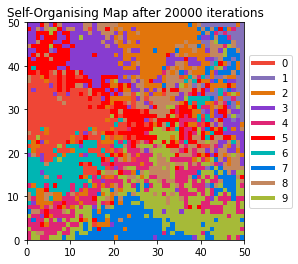

In [18]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, SOM_Network_Shape[0]))
ax.set_ylim((0, SOM_Network_Shape[1]))
ax.set_title('Self-Organising Map after %d iterations' % Max_Epoch)

# plot the rectangles
i = 0
for x in range(0, SOM_Network_Shape[0]):
    for y in range(0, SOM_Network_Shape[1]):
        ax.add_patch(patches.Rectangle((x, y), 1, 1, facecolor=Colour[i], edgecolor='none'))
        i += 1
# Add legends
legend_elements = [Line2D([0], [0], color=Saturation_Norm[0], lw=4, label='0'), 
                  Line2D([0], [0], color=Saturation_Norm[1], lw=4, label='1'),
                  Line2D([0], [0], color=Saturation_Norm[2], lw=4, label='2'),
                  Line2D([0], [0], color=Saturation_Norm[3], lw=4, label='3'),
                  Line2D([0], [0], color=Saturation_Norm[4], lw=4, label='4'),
                  Line2D([0], [0], color=Saturation_Norm[5], lw=4, label='5'),
                  Line2D([0], [0], color=Saturation_Norm[6], lw=4, label='6'),
                  Line2D([0], [0], color=Saturation_Norm[7], lw=4, label='7'),
                  Line2D([0], [0], color=Saturation_Norm[8], lw=4, label='8'),
                  Line2D([0], [0], color=Saturation_Norm[9], lw=4, label='9')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Self-Organising Map.pdf')
plt.show()